In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import LeakyReLU
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers


In [2]:
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100


In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784)
    # so we have 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


In [4]:
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, \
            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator


In [5]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, \
                kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


In [6]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), \
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', \
                   cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


In [8]:
def train(epochs=1, batch_size=128):
    
    #1 Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    #2. Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
    
    # 3
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # 4. Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], \
                                                    size=batch_size)]
    # 5. Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # 6. Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            #7. Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            #8. Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


11490434/11490434 [==============================] - 8s 1us/step
--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▏                                                                                 | 1/468 [00:02<19:11,  2.47s/it]

4/4 [==============================] - 0s 7ms/step


  0%|▎                                                                                 | 2/468 [00:02<08:48,  1.13s/it]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:02<05:31,  1.40it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▋                                                                                 | 4/468 [00:03<04:00,  1.93it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:03<03:05,  2.49it/s]

4/4 [==============================] - 0s 8ms/step


  1%|█                                                                                 | 6/468 [00:03<02:38,  2.91it/s]

4/4 [==============================] - 0s 8ms/step


  1%|█▏                                                                                | 7/468 [00:03<02:17,  3.36it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▍                                                                                | 8/468 [00:03<02:02,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


  2%|█▌                                                                                | 9/468 [00:04<01:56,  3.95it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▋                                                                               | 10/468 [00:04<01:47,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:04<01:44,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██                                                                               | 12/468 [00:04<01:40,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▎                                                                              | 13/468 [00:04<01:39,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▍                                                                              | 14/468 [00:05<01:37,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▌                                                                              | 15/468 [00:05<01:36,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▊                                                                              | 16/468 [00:05<01:35,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  4%|██▉                                                                              | 17/468 [00:05<01:34,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███                                                                              | 18/468 [00:06<01:34,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:06<01:34,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▍                                                                             | 20/468 [00:06<01:32,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▋                                                                             | 21/468 [00:06<01:33,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▊                                                                             | 22/468 [00:06<01:34,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▉                                                                             | 23/468 [00:07<01:33,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▏                                                                            | 24/468 [00:07<01:34,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


  5%|████▎                                                                            | 25/468 [00:07<01:34,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


  6%|████▌                                                                            | 26/468 [00:07<01:36,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


  6%|████▋                                                                            | 27/468 [00:07<01:38,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


  6%|████▊                                                                            | 28/468 [00:08<01:37,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


  6%|█████                                                                            | 29/468 [00:08<01:38,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████▏                                                                           | 30/468 [00:08<01:38,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


  7%|█████▎                                                                           | 31/468 [00:08<01:37,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


  7%|█████▌                                                                           | 32/468 [00:09<01:37,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▋                                                                           | 33/468 [00:09<01:38,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:09<01:36,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


  7%|██████                                                                           | 35/468 [00:09<01:33,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▏                                                                          | 36/468 [00:09<01:32,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▍                                                                          | 37/468 [00:10<01:33,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▌                                                                          | 38/468 [00:10<01:30,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▊                                                                          | 39/468 [00:10<01:31,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


  9%|██████▉                                                                          | 40/468 [00:10<01:32,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████                                                                          | 41/468 [00:11<01:33,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


  9%|███████▎                                                                         | 42/468 [00:11<01:32,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▍                                                                         | 43/468 [00:11<01:32,  4.58it/s]

4/4 [==============================] - 0s 9ms/step


  9%|███████▌                                                                         | 44/468 [00:11<01:34,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 10%|███████▊                                                                         | 45/468 [00:11<01:34,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▉                                                                         | 46/468 [00:12<01:32,  4.54it/s]

4/4 [==============================] - 0s 11ms/step


 10%|████████▏                                                                        | 47/468 [00:12<01:33,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▎                                                                        | 48/468 [00:12<01:32,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▍                                                                        | 49/468 [00:12<01:30,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 11%|████████▋                                                                        | 50/468 [00:13<01:32,  4.54it/s]

4/4 [==============================] - 0s 9ms/step


 11%|████████▊                                                                        | 51/468 [00:13<01:39,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████                                                                        | 52/468 [00:13<01:36,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████▏                                                                       | 53/468 [00:13<01:33,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▎                                                                       | 54/468 [00:13<01:31,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▌                                                                       | 55/468 [00:14<01:31,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▋                                                                       | 56/468 [00:14<01:29,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▊                                                                       | 57/468 [00:14<01:28,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 12%|██████████                                                                       | 58/468 [00:14<01:33,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▏                                                                      | 59/468 [00:15<01:34,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▍                                                                      | 60/468 [00:15<01:33,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▌                                                                      | 61/468 [00:15<01:31,  4.46it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▋                                                                      | 62/468 [00:15<01:32,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▉                                                                      | 63/468 [00:15<01:32,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████                                                                      | 64/468 [00:16<01:29,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▎                                                                     | 65/468 [00:16<01:29,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▍                                                                     | 66/468 [00:16<01:34,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▌                                                                     | 67/468 [00:16<01:36,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 15%|███████████▊                                                                     | 68/468 [00:17<01:36,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 15%|███████████▉                                                                     | 69/468 [00:17<01:37,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 15%|████████████                                                                     | 70/468 [00:17<01:39,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 15%|████████████▎                                                                    | 71/468 [00:17<01:39,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████▍                                                                    | 72/468 [00:18<01:36,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▋                                                                    | 73/468 [00:18<01:35,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▊                                                                    | 74/468 [00:18<01:33,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 16%|████████████▉                                                                    | 75/468 [00:18<01:35,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█████████████▏                                                                   | 76/468 [00:19<01:34,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▎                                                                   | 77/468 [00:19<01:35,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▌                                                                   | 78/468 [00:19<01:34,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█████████████▋                                                                   | 79/468 [00:19<01:34,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█████████████▊                                                                   | 80/468 [00:20<01:35,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


 17%|██████████████                                                                   | 81/468 [00:20<01:33,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▏                                                                  | 82/468 [00:20<01:30,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▎                                                                  | 83/468 [00:20<01:28,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▌                                                                  | 84/468 [00:20<01:26,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▋                                                                  | 85/468 [00:21<01:25,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▉                                                                  | 86/468 [00:21<01:23,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████                                                                  | 87/468 [00:21<01:22,  4.61it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████▏                                                                 | 88/468 [00:21<01:22,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▍                                                                 | 89/468 [00:22<01:20,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▌                                                                 | 90/468 [00:22<01:19,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▊                                                                 | 91/468 [00:22<01:19,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 20%|███████████████▉                                                                 | 92/468 [00:22<01:18,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 20%|████████████████                                                                 | 93/468 [00:22<01:19,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▎                                                                | 94/468 [00:23<01:17,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▍                                                                | 95/468 [00:23<01:15,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▌                                                                | 96/468 [00:23<01:14,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▊                                                                | 97/468 [00:23<01:14,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▉                                                                | 98/468 [00:23<01:16,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████▏                                                               | 99/468 [00:24<01:19,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 21%|█████████████████                                                               | 100/468 [00:24<01:16,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▎                                                              | 101/468 [00:24<01:17,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▍                                                              | 102/468 [00:24<01:16,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▌                                                              | 103/468 [00:24<01:17,  4.69it/s]

4/4 [==============================] - 0s 10ms/step


 22%|█████████████████▊                                                              | 104/468 [00:25<01:19,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:25<01:17,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████                                                              | 106/468 [00:25<01:17,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▎                                                             | 107/468 [00:25<01:19,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▍                                                             | 108/468 [00:26<01:17,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▋                                                             | 109/468 [00:26<01:16,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▊                                                             | 110/468 [00:26<01:14,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▉                                                             | 111/468 [00:26<01:16,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:26<01:14,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▎                                                            | 113/468 [00:27<01:14,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 24%|███████████████████▍                                                            | 114/468 [00:27<01:13,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 25%|███████████████████▋                                                            | 115/468 [00:27<01:12,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 25%|███████████████████▊                                                            | 116/468 [00:27<01:09,  5.07it/s]

4/4 [==============================] - 0s 9ms/step


 25%|████████████████████                                                            | 117/468 [00:27<01:12,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 25%|████████████████████▏                                                           | 118/468 [00:28<01:13,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▎                                                           | 119/468 [00:28<01:13,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▌                                                           | 120/468 [00:28<01:12,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▋                                                           | 121/468 [00:28<01:10,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▊                                                           | 122/468 [00:28<01:11,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████                                                           | 123/468 [00:29<01:12,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:29<01:13,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:29<01:13,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:29<01:14,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:30<01:14,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:30<01:13,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████                                                          | 129/468 [00:30<01:14,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:30<01:15,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:30<01:16,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:31<01:16,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:31<01:15,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:31<01:13,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████                                                         | 135/468 [00:31<01:13,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:32<01:13,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:32<01:10,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:32<01:09,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:32<01:10,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:32<01:09,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████                                                        | 141/468 [00:33<01:09,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:33<01:09,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:33<01:08,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:33<01:09,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:33<01:09,  4.64it/s]

4/4 [==============================] - 0s 9ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:34<01:10,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:34<01:10,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:34<01:10,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:34<01:11,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:35<01:11,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:35<01:12,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:35<01:10,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:35<01:11,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:35<01:08,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:36<01:08,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:36<01:08,  4.54it/s]

4/4 [==============================] - 0s 9ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:36<01:09,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████                                                     | 158/468 [00:36<01:08,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:37<01:08,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:37<01:07,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:37<01:06,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:37<01:05,  4.65it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:37<01:06,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 35%|████████████████████████████                                                    | 164/468 [00:38<01:05,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:38<01:03,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:38<01:04,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:38<01:05,  4.62it/s]

4/4 [==============================] - 0s 10ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:39<01:06,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:39<01:06,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:39<01:04,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:39<01:03,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:39<01:03,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:40<01:06,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:40<01:05,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:40<01:05,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:40<01:04,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:41<01:05,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:41<01:04,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:41<01:06,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:41<01:06,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:41<01:03,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:42<01:03,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:42<01:00,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:42<01:00,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:42<01:00,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:42<00:59,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:43<01:00,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:43<01:00,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:43<00:59,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:43<01:01,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:44<01:00,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:44<00:58,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:44<00:58,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:44<00:56,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:44<00:57,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:45<00:58,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:45<00:56,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:45<00:57,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:45<00:56,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:45<00:57,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:46<00:56,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:46<00:56,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:46<00:56,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:46<00:56,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:47<00:56,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:47<00:54,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:47<00:53,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:47<00:54,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:47<00:53,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:48<00:52,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:48<00:51,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:48<00:50,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:48<00:50,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:48<00:51,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:49<00:54,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:49<00:53,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:49<00:52,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:49<00:52,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:49<00:50,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:50<00:50,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:50<00:51,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:50<00:51,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:50<00:51,  4.79it/s]

4/4 [==============================] - 0s 10ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:50<00:52,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:51<00:50,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:51<00:49,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:51<00:49,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:51<00:49,  4.86it/s]

4/4 [==============================] - 0s 10ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:51<00:50,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:52<00:50,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:52<00:48,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:52<00:47,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:52<00:48,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:52<00:48,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:53<00:50,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:53<00:49,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:53<00:49,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:53<00:49,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:54<00:49,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:54<00:47,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:54<00:45,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:54<00:45,  4.99it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:54<00:45,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:55<00:45,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:55<00:46,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:55<00:46,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:55<00:45,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:55<00:44,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:56<00:44,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:56<00:44,  4.95it/s]

4/4 [==============================] - 0s 8ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:56<00:44,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:56<00:43,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:56<00:45,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:57<00:44,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:57<00:44,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:57<00:44,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:57<00:44,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:57<00:44,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:58<00:43,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:58<00:42,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:58<00:43,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:58<00:43,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:59<00:44,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:59<00:45,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:59<00:44,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:59<00:44,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:59<00:44,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [01:00<00:44,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [01:00<00:43,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [01:00<00:43,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [01:00<00:43,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [01:01<00:41,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [01:01<00:40,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [01:01<00:40,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [01:01<00:39,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [01:01<00:40,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [01:02<00:39,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [01:02<00:39,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [01:02<00:40,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [01:02<00:40,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [01:02<00:40,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [01:03<00:39,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [01:03<00:39,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [01:03<00:39,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [01:03<00:37,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [01:03<00:37,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [01:04<00:36,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [01:04<00:36,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [01:04<00:37,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [01:04<00:37,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [01:04<00:37,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [01:05<00:37,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [01:05<00:37,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [01:05<00:38,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [01:05<00:37,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [01:06<00:36,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [01:06<00:36,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [01:06<00:36,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [01:06<00:35,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [01:06<00:34,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [01:07<00:34,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [01:07<00:33,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [01:07<00:34,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [01:07<00:34,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [01:07<00:33,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [01:08<00:32,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [01:08<00:32,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [01:08<00:32,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [01:08<00:31,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [01:08<00:31,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [01:09<00:31,  4.97it/s]

4/4 [==============================] - 0s 8ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [01:09<00:32,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [01:09<00:32,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [01:09<00:31,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [01:09<00:31,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [01:10<00:31,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [01:10<00:31,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [01:10<00:32,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [01:10<00:31,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [01:11<00:31,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [01:11<00:31,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [01:11<00:30,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [01:11<00:29,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [01:11<00:29,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [01:12<00:28,  4.97it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [01:12<00:28,  4.95it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [01:12<00:28,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [01:12<00:28,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [01:12<00:29,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [01:13<00:28,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [01:13<00:27,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [01:13<00:27,  4.95it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [01:13<00:27,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [01:13<00:27,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [01:14<00:26,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [01:14<00:25,  5.16it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [01:14<00:25,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [01:14<00:25,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [01:14<00:26,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [01:15<00:26,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [01:15<00:25,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [01:15<00:25,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [01:15<00:25,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [01:15<00:26,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:16<00:26,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:16<00:25,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:16<00:26,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:16<00:25,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:17<00:25,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:17<00:31,  3.75it/s]

4/4 [==============================] - 0s 8ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:17<00:29,  3.91it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:17<00:27,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:18<00:26,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:18<00:26,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:18<00:25,  4.48it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:18<00:24,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:18<00:24,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:19<00:24,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:19<00:23,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:19<00:23,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:19<00:22,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:19<00:22,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:20<00:21,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:20<00:20,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:20<00:20,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:20<00:20,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:20<00:20,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:21<00:20,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:21<00:20,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:21<00:19,  4.98it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:21<00:19,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:21<00:18,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:22<00:18,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:22<00:18,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:22<00:18,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:22<00:19,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:22<00:18,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:23<00:18,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:23<00:18,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:23<00:18,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:23<00:18,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:24<00:17,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:24<00:17,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:24<00:17,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:24<00:17,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:24<00:17,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:25<00:17,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:25<00:17,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:25<00:16,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:25<00:16,  4.74it/s]

4/4 [==============================] - 0s 9ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:25<00:16,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:26<00:15,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:26<00:15,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:26<00:15,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:26<00:15,  4.85it/s]

4/4 [==============================] - 0s 9ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:26<00:14,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:27<00:14,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:27<00:13,  5.04it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:27<00:14,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:27<00:14,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:28<00:14,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:28<00:13,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:28<00:13,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:28<00:13,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:28<00:12,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:29<00:12,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:29<00:12,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:29<00:12,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:29<00:12,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:29<00:11,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:30<00:12,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:30<00:11,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:30<00:11,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:30<00:11,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:30<00:10,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:31<00:10,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:31<00:10,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:31<00:10,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:31<00:10,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:31<00:09,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:32<00:09,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:32<00:09,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:32<00:09,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:32<00:09,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:32<00:08,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:33<00:08,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:33<00:08,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:33<00:07,  5.07it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:33<00:08,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:33<00:07,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:34<00:07,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:34<00:07,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:34<00:07,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:34<00:06,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:34<00:06,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:35<00:06,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:35<00:06,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:35<00:06,  4.92it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:35<00:05,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:36<00:05,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:36<00:05,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:36<00:05,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:36<00:05,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:36<00:05,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:37<00:04,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:37<00:04,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:37<00:04,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:37<00:04,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:37<00:03,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:38<00:03,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:38<00:03,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:38<00:03,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:38<00:03,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:38<00:02,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:39<00:02,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:39<00:02,  4.73it/s]

4/4 [==============================] - 0s 11ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:39<00:02,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:39<00:02,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:39<00:01,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:40<00:01,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:40<00:01,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:40<00:01,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:40<00:01,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:41<00:00,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:41<00:00,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:41<00:00,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:41<00:00,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:41<00:00,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


--------------- Epoch 2 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:30,  5.15it/s]

4/4 [==============================] - 0s 8ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:33,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:36,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:39,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:33,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█                                                                                 | 6/468 [00:01<01:34,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:33,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:34,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:34,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:35,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:38,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██                                                                               | 12/468 [00:02<01:39,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:41,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:38,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▌                                                                              | 15/468 [00:03<01:38,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:37,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:34,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:03<01:33,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:34,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▍                                                                             | 20/468 [00:04<01:36,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:37,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:36,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:33,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▏                                                                            | 24/468 [00:05<01:31,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▎                                                                            | 25/468 [00:05<01:30,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▌                                                                            | 26/468 [00:05<01:29,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▋                                                                            | 27/468 [00:05<01:27,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:30,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


  6%|█████                                                                            | 29/468 [00:06<01:31,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████▏                                                                           | 30/468 [00:06<01:31,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:06<01:32,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


  7%|█████▌                                                                           | 32/468 [00:06<01:32,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


  7%|█████▋                                                                           | 33/468 [00:06<01:31,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:07<01:30,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


  7%|██████                                                                           | 35/468 [00:07<01:28,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▏                                                                          | 36/468 [00:07<01:31,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▍                                                                          | 37/468 [00:07<01:33,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▌                                                                          | 38/468 [00:07<01:30,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▊                                                                          | 39/468 [00:08<01:31,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


  9%|██████▉                                                                          | 40/468 [00:08<01:31,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████                                                                          | 41/468 [00:08<01:32,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████▎                                                                         | 42/468 [00:08<01:30,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


  9%|███████▍                                                                         | 43/468 [00:09<01:32,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████▌                                                                         | 44/468 [00:09<01:32,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▊                                                                         | 45/468 [00:09<01:28,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▉                                                                         | 46/468 [00:09<01:30,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▏                                                                        | 47/468 [00:09<01:31,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 10%|████████▎                                                                        | 48/468 [00:10<01:32,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▍                                                                        | 49/468 [00:10<01:32,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 11%|████████▋                                                                        | 50/468 [00:10<01:28,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▊                                                                        | 51/468 [00:10<01:25,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█████████                                                                        | 52/468 [00:10<01:22,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████▏                                                                       | 53/468 [00:11<01:21,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▎                                                                       | 54/468 [00:11<01:23,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▌                                                                       | 55/468 [00:11<01:22,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▋                                                                       | 56/468 [00:11<01:23,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▊                                                                       | 57/468 [00:11<01:20,  5.09it/s]

4/4 [==============================] - 0s 8ms/step


 12%|██████████                                                                       | 58/468 [00:12<01:21,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▏                                                                      | 59/468 [00:12<01:23,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▍                                                                      | 60/468 [00:12<01:20,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▌                                                                      | 61/468 [00:12<01:22,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▋                                                                      | 62/468 [00:12<01:24,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▉                                                                      | 63/468 [00:13<01:26,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████                                                                      | 64/468 [00:13<01:24,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▎                                                                     | 65/468 [00:13<01:20,  4.99it/s]

4/4 [==============================] - 0s 9ms/step


 14%|███████████▍                                                                     | 66/468 [00:13<01:22,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▌                                                                     | 67/468 [00:14<01:23,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 15%|███████████▊                                                                     | 68/468 [00:14<01:25,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 15%|███████████▉                                                                     | 69/468 [00:14<01:25,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████                                                                     | 70/468 [00:14<01:24,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████▎                                                                    | 71/468 [00:14<01:26,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████▍                                                                    | 72/468 [00:15<01:26,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▋                                                                    | 73/468 [00:15<01:26,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▊                                                                    | 74/468 [00:15<01:24,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▉                                                                    | 75/468 [00:15<01:24,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▏                                                                   | 76/468 [00:15<01:27,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▎                                                                   | 77/468 [00:16<01:26,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▌                                                                   | 78/468 [00:16<01:24,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▋                                                                   | 79/468 [00:16<01:23,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▊                                                                   | 80/468 [00:16<01:25,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 17%|██████████████                                                                   | 81/468 [00:17<01:24,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▏                                                                  | 82/468 [00:17<01:24,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▎                                                                  | 83/468 [00:17<01:22,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▌                                                                  | 84/468 [00:17<01:21,  4.71it/s]

4/4 [==============================] - 0s 9ms/step


 18%|██████████████▋                                                                  | 85/468 [00:17<01:22,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▉                                                                  | 86/468 [00:18<01:22,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████                                                                  | 87/468 [00:18<01:22,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▏                                                                 | 88/468 [00:18<01:23,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▍                                                                 | 89/468 [00:18<01:23,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▌                                                                 | 90/468 [00:19<01:22,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▊                                                                 | 91/468 [00:19<01:21,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 20%|███████████████▉                                                                 | 92/468 [00:19<01:23,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 20%|████████████████                                                                 | 93/468 [00:19<01:24,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▎                                                                | 94/468 [00:19<01:22,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


 20%|████████████████▍                                                                | 95/468 [00:20<01:23,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 21%|████████████████▌                                                                | 96/468 [00:20<01:22,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 21%|████████████████▊                                                                | 97/468 [00:20<01:23,  4.46it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▉                                                                | 98/468 [00:20<01:23,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 21%|█████████████████▏                                                               | 99/468 [00:21<01:25,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████                                                               | 100/468 [00:21<01:25,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▎                                                              | 101/468 [00:21<01:24,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▍                                                              | 102/468 [00:21<01:23,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▌                                                              | 103/468 [00:21<01:21,  4.45it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▊                                                              | 104/468 [00:22<01:19,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:22<01:19,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████                                                              | 106/468 [00:22<01:20,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▎                                                             | 107/468 [00:22<01:19,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▍                                                             | 108/468 [00:23<01:17,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██████████████████▋                                                             | 109/468 [00:23<01:16,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██████████████████▊                                                             | 110/468 [00:23<01:15,  4.74it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██████████████████▉                                                             | 111/468 [00:23<01:17,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:23<01:16,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 24%|███████████████████▎                                                            | 113/468 [00:24<01:16,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▍                                                            | 114/468 [00:24<01:15,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 25%|███████████████████▋                                                            | 115/468 [00:24<01:15,  4.66it/s]

4/4 [==============================] - 0s 9ms/step


 25%|███████████████████▊                                                            | 116/468 [00:24<01:15,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████                                                            | 117/468 [00:24<01:15,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▏                                                           | 118/468 [00:25<01:16,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 25%|████████████████████▎                                                           | 119/468 [00:25<01:18,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▌                                                           | 120/468 [00:25<01:20,  4.34it/s]

4/4 [==============================] - 0s 10ms/step


 26%|████████████████████▋                                                           | 121/468 [00:25<01:18,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▊                                                           | 122/468 [00:26<01:16,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████                                                           | 123/468 [00:26<01:15,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:26<01:15,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:26<01:15,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:26<01:14,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:27<01:13,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:27<01:13,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████                                                          | 129/468 [00:27<01:15,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:27<01:15,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:28<01:12,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:28<01:12,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:28<01:15,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:28<01:12,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████                                                         | 135/468 [00:28<01:09,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:29<01:07,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:29<01:09,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:29<01:08,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:29<01:09,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:29<01:09,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████                                                        | 141/468 [00:30<01:08,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:30<01:08,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:30<01:08,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:30<01:06,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:30<01:05,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:31<01:04,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:31<01:04,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:31<01:03,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:31<01:02,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:31<01:01,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:32<01:01,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:32<01:02,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:32<01:01,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:32<01:01,  5.08it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:32<01:03,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:33<01:02,  4.96it/s]

4/4 [==============================] - 0s 8ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:33<01:02,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████                                                     | 158/468 [00:33<01:01,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:33<01:02,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:33<01:04,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:34<01:02,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:34<01:02,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:34<01:01,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████                                                    | 164/468 [00:34<01:01,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:35<01:02,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:35<01:02,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:35<01:01,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:35<01:02,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:35<01:03,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:36<01:06,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:36<01:04,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:36<01:04,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:36<01:02,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:36<01:00,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:37<01:00,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:37<01:01,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:37<01:01,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:37<01:01,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:37<01:01,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:38<01:04,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:38<01:04,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:38<01:03,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:38<01:04,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:39<01:03,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:39<01:01,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:39<01:01,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:39<01:06,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:40<01:05,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:40<01:04,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:40<01:02,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:40<01:01,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:40<01:00,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:41<00:59,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:41<00:56,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:41<00:55,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:41<00:54,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:41<00:53,  5.02it/s]

4/4 [==============================] - 0s 8ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:42<00:58,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:42<00:59,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:42<00:56,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:42<00:53,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:42<00:52,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:43<00:51,  5.14it/s]

4/4 [==============================] - 0s 7ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:43<00:51,  5.15it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:43<00:51,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:43<00:52,  5.00it/s]

4/4 [==============================] - 0s 9ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:43<00:53,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:44<00:53,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:44<00:52,  4.96it/s]

4/4 [==============================] - 0s 8ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:44<00:53,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:44<00:53,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:44<00:53,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:45<00:54,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:45<00:54,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:45<00:53,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:45<00:51,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:46<00:51,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:46<00:52,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:46<00:52,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:46<00:53,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:46<00:52,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:47<00:52,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:47<00:54,  4.52it/s]

4/4 [==============================] - 0s 9ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:47<00:53,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:47<00:52,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:48<00:53,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:48<00:53,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:48<00:53,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:48<00:52,  4.59it/s]

4/4 [==============================] - 0s 9ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:48<00:51,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:49<00:50,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:49<00:51,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:49<00:50,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:49<00:51,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:49<00:50,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:50<00:49,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:50<00:49,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:50<00:49,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:50<00:49,  4.64it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:51<00:49,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:51<00:50,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:51<00:51,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:51<00:51,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:51<00:50,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:52<00:49,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:52<00:49,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:52<00:48,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:52<00:47,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:53<00:47,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:53<00:47,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:53<00:46,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:53<00:47,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:53<00:47,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:54<00:46,  4.59it/s]

4/4 [==============================] - 0s 9ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:54<00:46,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:54<00:46,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:54<00:45,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:55<00:45,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:55<00:44,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:55<00:44,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:55<00:44,  4.62it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:55<00:43,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:56<00:43,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:56<00:42,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:56<00:42,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:56<00:42,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:56<00:42,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:57<00:42,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:57<00:41,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:57<00:41,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:57<00:42,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:57<00:42,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:58<00:43,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:58<00:41,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:58<00:40,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:58<00:40,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:59<00:39,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:59<00:39,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:59<00:39,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:59<00:39,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:59<00:39,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [01:00<00:39,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [01:00<00:40,  4.61it/s]

4/4 [==============================] - 0s 9ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [01:00<00:40,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [01:00<00:40,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [01:00<00:40,  4.52it/s]

4/4 [==============================] - 0s 10ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [01:01<00:40,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [01:01<00:39,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [01:01<00:40,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [01:01<00:40,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [01:02<00:38,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [01:02<00:38,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [01:02<00:37,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [01:02<00:37,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [01:02<00:37,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [01:03<00:36,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [01:03<00:35,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [01:03<00:34,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [01:03<00:33,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [01:03<00:33,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [01:04<00:34,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [01:04<00:33,  4.97it/s]

4/4 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [01:04<00:33,  4.99it/s]

4/4 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [01:04<00:33,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [01:04<00:33,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [01:05<00:33,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [01:05<00:33,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [01:05<00:33,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [01:05<00:32,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [01:06<00:33,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [01:06<00:32,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [01:06<00:31,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [01:06<00:31,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [01:06<00:32,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [01:07<00:31,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [01:07<00:30,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [01:07<00:29,  5.07it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [01:07<00:30,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [01:07<00:29,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [01:08<00:29,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [01:08<00:30,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [01:08<00:28,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [01:08<00:29,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [01:08<00:30,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [01:09<00:30,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [01:09<00:29,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [01:09<00:29,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [01:09<00:29,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [01:09<00:28,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [01:10<00:28,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [01:10<00:28,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [01:10<00:28,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [01:10<00:28,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [01:10<00:28,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [01:11<00:28,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [01:11<00:29,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [01:11<00:27,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [01:11<00:26,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [01:12<00:26,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [01:12<00:26,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [01:12<00:25,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [01:12<00:24,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [01:12<00:24,  5.08it/s]

4/4 [==============================] - 0s 8ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [01:12<00:24,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:13<00:24,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:13<00:25,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:13<00:25,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:13<00:26,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:14<00:25,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:14<00:25,  4.65it/s]

4/4 [==============================] - 0s 10ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:14<00:25,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:14<00:25,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:14<00:24,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:15<00:24,  4.71it/s]

4/4 [==============================] - 0s 9ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:15<00:24,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:15<00:24,  4.64it/s]

4/4 [==============================] - 0s 9ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:15<00:24,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:16<00:23,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:16<00:23,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:16<00:23,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:16<00:22,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:16<00:22,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:17<00:22,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:17<00:21,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:17<00:22,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:17<00:22,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:17<00:22,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:18<00:21,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:18<00:21,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:18<00:20,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:18<00:19,  4.98it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:18<00:19,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:19<00:19,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:19<00:19,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:19<00:19,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:19<00:18,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:19<00:18,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:20<00:18,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:20<00:18,  4.94it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:20<00:18,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:20<00:18,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:21<00:18,  4.71it/s]

4/4 [==============================] - 0s 11ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:21<00:18,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:21<00:18,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:21<00:17,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:21<00:17,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:22<00:17,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:22<00:17,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:22<00:16,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:22<00:16,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:22<00:16,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:23<00:15,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:23<00:15,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:23<00:15,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:23<00:14,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:24<00:14,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:24<00:14,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:24<00:14,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:24<00:14,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:24<00:14,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:25<00:14,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:25<00:14,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:25<00:14,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:25<00:13,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:25<00:13,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:26<00:13,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:26<00:13,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:26<00:12,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:26<00:12,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:26<00:11,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:27<00:11,  4.93it/s]

4/4 [==============================] - 0s 9ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:27<00:11,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:27<00:11,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:27<00:11,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:28<00:11,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:28<00:10,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:28<00:10,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:28<00:10,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:28<00:09,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:29<00:09,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:29<00:09,  5.14it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:29<00:09,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:29<00:09,  4.92it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:29<00:08,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:30<00:08,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:30<00:08,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:30<00:08,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:30<00:08,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:30<00:08,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:31<00:08,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:31<00:07,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:31<00:07,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:31<00:07,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:31<00:06,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:32<00:06,  5.03it/s]

4/4 [==============================] - 0s 11ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:32<00:06,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:32<00:06,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:32<00:06,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:33<00:06,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:33<00:05,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:33<00:05,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:33<00:05,  5.02it/s]

4/4 [==============================] - 0s 8ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:33<00:04,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:33<00:04,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:34<00:04,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:34<00:04,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:34<00:04,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:34<00:03,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:34<00:03,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:35<00:03,  5.01it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:35<00:03,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:35<00:03,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:35<00:02,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:35<00:02,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:36<00:02,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:36<00:02,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:36<00:02,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:36<00:01,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:36<00:01,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:37<00:01,  5.01it/s]

4/4 [==============================] - 0s 8ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:37<00:01,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:37<00:01,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:37<00:00,  5.16it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:37<00:00,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:38<00:00,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:38<00:00,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:38<00:00,  5.28it/s]

4/4 [==============================] - 0s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:38<00:00,  4.74it/s]


--------------- Epoch 3 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:39,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:37,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:37,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:39,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:38,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█                                                                                 | 6/468 [00:01<01:36,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:35,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:38,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:41,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:37,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:36,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██                                                                               | 12/468 [00:02<01:36,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:35,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:38,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▌                                                                              | 15/468 [00:03<01:36,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:36,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:39,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███                                                                              | 18/468 [00:03<01:37,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:04<01:38,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▍                                                                             | 20/468 [00:04<01:36,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:39,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:36,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:38,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▏                                                                            | 24/468 [00:05<01:37,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▎                                                                            | 25/468 [00:05<01:36,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▌                                                                            | 26/468 [00:05<01:34,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▋                                                                            | 27/468 [00:05<01:34,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▊                                                                            | 28/468 [00:06<01:33,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████                                                                            | 29/468 [00:06<01:32,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████▏                                                                           | 30/468 [00:06<01:30,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:06<01:29,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▌                                                                           | 32/468 [00:06<01:29,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▋                                                                           | 33/468 [00:07<01:30,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


  7%|█████▉                                                                           | 34/468 [00:07<01:30,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  7%|██████                                                                           | 35/468 [00:07<01:29,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▏                                                                          | 36/468 [00:07<01:29,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▍                                                                          | 37/468 [00:07<01:32,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▌                                                                          | 38/468 [00:08<01:33,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


  8%|██████▊                                                                          | 39/468 [00:08<01:32,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


  9%|██████▉                                                                          | 40/468 [00:08<01:31,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████                                                                          | 41/468 [00:08<01:33,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▎                                                                         | 42/468 [00:08<01:29,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████▍                                                                         | 43/468 [00:09<01:30,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▌                                                                         | 44/468 [00:09<01:31,  4.64it/s]

4/4 [==============================] - 0s 9ms/step


 10%|███████▊                                                                         | 45/468 [00:09<01:33,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 10%|███████▉                                                                         | 46/468 [00:09<01:34,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 10%|████████▏                                                                        | 47/468 [00:10<01:34,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 10%|████████▎                                                                        | 48/468 [00:10<01:35,  4.38it/s]

4/4 [==============================] - 0s 9ms/step


 10%|████████▍                                                                        | 49/468 [00:10<01:35,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 11%|████████▋                                                                        | 50/468 [00:10<01:29,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 11%|████████▊                                                                        | 51/468 [00:10<01:28,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████                                                                        | 52/468 [00:11<01:26,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████▏                                                                       | 53/468 [00:11<01:25,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▎                                                                       | 54/468 [00:11<01:25,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▌                                                                       | 55/468 [00:11<01:26,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▋                                                                       | 56/468 [00:11<01:26,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▊                                                                       | 57/468 [00:12<01:28,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 12%|██████████                                                                       | 58/468 [00:12<01:24,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▏                                                                      | 59/468 [00:12<01:22,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▍                                                                      | 60/468 [00:12<01:21,  5.02it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▌                                                                      | 61/468 [00:12<01:21,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▋                                                                      | 62/468 [00:13<01:22,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▉                                                                      | 63/468 [00:13<01:21,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████                                                                      | 64/468 [00:13<01:22,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████▎                                                                     | 65/468 [00:13<01:22,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▍                                                                     | 66/468 [00:14<01:22,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▌                                                                     | 67/468 [00:14<01:21,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 15%|███████████▊                                                                     | 68/468 [00:14<01:21,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 15%|███████████▉                                                                     | 69/468 [00:14<01:23,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 15%|████████████                                                                     | 70/468 [00:14<01:20,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████▎                                                                    | 71/468 [00:15<01:21,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████▍                                                                    | 72/468 [00:15<01:21,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▋                                                                    | 73/468 [00:15<01:21,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▊                                                                    | 74/468 [00:15<01:23,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▉                                                                    | 75/468 [00:15<01:21,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█████████████▏                                                                   | 76/468 [00:16<01:21,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█████████████▎                                                                   | 77/468 [00:16<01:20,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█████████████▌                                                                   | 78/468 [00:16<01:22,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▋                                                                   | 79/468 [00:16<01:20,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█████████████▊                                                                   | 80/468 [00:16<01:18,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


 17%|██████████████                                                                   | 81/468 [00:17<01:20,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


 18%|██████████████▏                                                                  | 82/468 [00:17<01:23,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▎                                                                  | 83/468 [00:17<01:21,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▌                                                                  | 84/468 [00:17<01:25,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 18%|██████████████▋                                                                  | 85/468 [00:18<01:27,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▉                                                                  | 86/468 [00:18<01:26,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████                                                                  | 87/468 [00:18<01:24,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▏                                                                 | 88/468 [00:18<01:23,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:18<01:22,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▌                                                                 | 90/468 [00:19<01:20,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▊                                                                 | 91/468 [00:19<01:19,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 20%|███████████████▉                                                                 | 92/468 [00:19<01:18,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 20%|████████████████                                                                 | 93/468 [00:19<01:21,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▎                                                                | 94/468 [00:19<01:19,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▍                                                                | 95/468 [00:20<01:19,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▌                                                                | 96/468 [00:20<01:17,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 21%|████████████████▊                                                                | 97/468 [00:20<01:15,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 21%|████████████████▉                                                                | 98/468 [00:20<01:16,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████▏                                                               | 99/468 [00:20<01:15,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████                                                               | 100/468 [00:21<01:15,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▎                                                              | 101/468 [00:21<01:16,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▍                                                              | 102/468 [00:21<01:17,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▌                                                              | 103/468 [00:21<01:16,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▊                                                              | 104/468 [00:22<01:16,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:22<01:17,  4.66it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██████████████████                                                              | 106/468 [00:22<01:26,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██████████████████▎                                                             | 107/468 [00:22<01:28,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▍                                                             | 108/468 [00:23<01:35,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██████████████████▋                                                             | 109/468 [00:23<01:31,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██████████████████▊                                                             | 110/468 [00:23<01:27,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██████████████████▉                                                             | 111/468 [00:23<01:23,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:23<01:20,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 24%|███████████████████▎                                                            | 113/468 [00:24<01:19,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 24%|███████████████████▍                                                            | 114/468 [00:24<01:18,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▋                                                            | 115/468 [00:24<01:18,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▊                                                            | 116/468 [00:24<01:18,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 25%|████████████████████                                                            | 117/468 [00:25<01:18,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▏                                                           | 118/468 [00:25<01:16,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▎                                                           | 119/468 [00:25<01:16,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▌                                                           | 120/468 [00:25<01:14,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▋                                                           | 121/468 [00:25<01:13,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▊                                                           | 122/468 [00:26<01:13,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 26%|█████████████████████                                                           | 123/468 [00:26<01:11,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:26<01:10,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:26<01:09,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:26<01:10,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:27<01:10,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:27<01:11,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████                                                          | 129/468 [00:27<01:09,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:27<01:10,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:27<01:09,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:28<01:11,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:28<01:12,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:28<01:11,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████                                                         | 135/468 [00:28<01:09,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:29<01:10,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:29<01:09,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:29<01:10,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:29<01:09,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:29<01:09,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████                                                        | 141/468 [00:30<01:09,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:30<01:09,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:30<01:09,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:30<01:07,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:30<01:07,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:31<01:08,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:31<01:08,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:31<01:06,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:31<01:06,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:32<01:06,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:32<01:06,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:32<01:05,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:32<01:05,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:32<01:06,  4.76it/s]

4/4 [==============================] - 0s 12ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:33<01:07,  4.62it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:33<01:06,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:33<01:06,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████                                                     | 158/468 [00:33<01:06,  4.66it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:33<01:06,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:34<01:05,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:34<01:06,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:34<01:06,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:34<01:06,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████                                                    | 164/468 [00:34<01:05,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:35<01:03,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:35<01:05,  4.58it/s]

4/4 [==============================] - 0s 10ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:35<01:10,  4.28it/s]

4/4 [==============================] - 0s 10ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:35<01:11,  4.17it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:36<01:07,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:36<01:06,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:36<01:04,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:36<01:04,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:36<01:03,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:37<01:04,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:37<01:01,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:37<01:01,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:37<01:03,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:38<01:02,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:38<00:59,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:38<00:59,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:38<00:59,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:38<01:01,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:39<00:58,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:39<00:57,  4.95it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:39<00:59,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:39<01:00,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:39<01:00,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:40<01:00,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:40<00:58,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:40<00:59,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:40<00:58,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:41<01:01,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:41<01:02,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:41<01:01,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:41<01:02,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:41<01:01,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:42<01:01,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:42<01:01,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:42<01:01,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:42<01:01,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:43<00:58,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:43<00:57,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:43<00:55,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:43<00:55,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:43<00:54,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:44<00:55,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:44<00:55,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:44<00:55,  4.65it/s]

4/4 [==============================] - 0s 10ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:44<00:56,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:45<00:58,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:45<00:58,  4.41it/s]

4/4 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:45<00:59,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:45<01:00,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:45<01:00,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:46<01:00,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:46<00:59,  4.26it/s]

4/4 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:46<01:01,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:46<01:00,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:47<00:58,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:47<00:56,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:47<00:55,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:47<00:55,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:48<00:54,  4.48it/s]

4/4 [==============================] - 0s 12ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:48<00:57,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:48<00:55,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:48<00:54,  4.45it/s]

4/4 [==============================] - 0s 8ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:48<00:53,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:49<00:51,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:49<00:50,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:49<00:50,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:49<00:48,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:49<00:48,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:50<00:49,  4.71it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:50<00:50,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:50<00:48,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:50<00:48,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:51<00:49,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:51<00:49,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:51<00:48,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:51<00:47,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:51<00:46,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:52<00:46,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:52<00:46,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:52<00:45,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:52<00:46,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:52<00:45,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:53<00:45,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:53<00:45,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:53<00:45,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:53<00:44,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:53<00:44,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:54<00:44,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:54<00:44,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:54<00:44,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:54<00:44,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:54<00:44,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:55<00:44,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:55<00:44,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:55<00:44,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:55<00:43,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:56<00:43,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:56<00:43,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:56<00:42,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:56<00:42,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:56<00:44,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:57<00:42,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:57<00:41,  4.80it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:57<00:41,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:57<00:42,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:57<00:45,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:58<00:45,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:58<00:44,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:58<00:43,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:58<00:42,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:59<00:41,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:59<00:41,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:59<00:40,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:59<00:39,  4.85it/s]

4/4 [==============================] - 0s 9ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:59<00:39,  4.76it/s]

4/4 [==============================] - 0s 10ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [01:00<00:39,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [01:00<00:38,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [01:00<00:38,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [01:00<00:37,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [01:00<00:38,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [01:01<00:37,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [01:01<00:38,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [01:01<00:37,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [01:01<00:37,  4.83it/s]

4/4 [==============================] - 0s 9ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [01:01<00:37,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [01:02<00:36,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [01:02<00:36,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [01:02<00:34,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [01:02<00:33,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [01:02<00:33,  5.19it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [01:03<00:33,  5.21it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [01:03<00:32,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [01:03<00:32,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [01:03<00:31,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [01:03<00:30,  5.48it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [01:04<00:30,  5.43it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [01:04<00:31,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [01:04<00:30,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [01:04<00:30,  5.36it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [01:04<00:30,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [01:04<00:30,  5.28it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [01:05<00:30,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [01:05<00:30,  5.25it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [01:05<00:30,  5.30it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [01:05<00:30,  5.28it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [01:05<00:30,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [01:06<00:30,  5.19it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [01:06<00:30,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [01:06<00:30,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [01:06<00:30,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [01:06<00:31,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [01:07<00:31,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [01:07<00:31,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [01:07<00:30,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [01:07<00:31,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [01:08<00:31,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [01:08<00:31,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [01:08<00:31,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [01:08<00:31,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [01:08<00:31,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [01:09<00:31,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [01:09<00:30,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [01:09<00:30,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [01:09<00:29,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [01:09<00:28,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [01:10<00:28,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [01:10<00:28,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [01:10<00:30,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [01:10<00:29,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [01:11<00:28,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [01:11<00:28,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [01:11<00:28,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [01:11<00:27,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [01:11<00:27,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [01:12<00:26,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [01:12<00:26,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [01:12<00:26,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [01:12<00:26,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [01:12<00:26,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [01:13<00:26,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:13<00:25,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:13<00:25,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:13<00:25,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:13<00:24,  4.92it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:14<00:24,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:14<00:24,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:14<00:23,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:14<00:23,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:15<00:24,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:15<00:23,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:15<00:23,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:15<00:23,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:15<00:22,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:16<00:22,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:16<00:22,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:16<00:21,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:16<00:21,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:16<00:21,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:17<00:21,  4.87it/s]

4/4 [==============================] - 0s 9ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:17<00:22,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:17<00:21,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:17<00:20,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:17<00:21,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:18<00:21,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:18<00:20,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:18<00:19,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:18<00:20,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:18<00:19,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:19<00:19,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:19<00:19,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:19<00:19,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:19<00:18,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:19<00:18,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:20<00:17,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:20<00:17,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:20<00:17,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:20<00:17,  4.97it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:20<00:17,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:21<00:17,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:21<00:17,  4.77it/s]

4/4 [==============================] - 0s 12ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:21<00:17,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:21<00:17,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:22<00:17,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:22<00:17,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:22<00:16,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:22<00:16,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:22<00:16,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:23<00:16,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:23<00:15,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:23<00:15,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:23<00:15,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:23<00:14,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:24<00:14,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:24<00:14,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:24<00:14,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:24<00:14,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:24<00:14,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:25<00:13,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:25<00:13,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:25<00:13,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:25<00:12,  4.87it/s]

4/4 [==============================] - 0s 9ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:26<00:12,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:26<00:12,  4.87it/s]

4/4 [==============================] - 0s 9ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:26<00:12,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:26<00:12,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:26<00:12,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:27<00:12,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:27<00:11,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:27<00:11,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:27<00:11,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:27<00:11,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:28<00:10,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:28<00:10,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:28<00:10,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:28<00:10,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:28<00:10,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:29<00:09,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:29<00:09,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:29<00:09,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:29<00:09,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:29<00:09,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:30<00:08,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:30<00:08,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:30<00:08,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:30<00:07,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:30<00:07,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:31<00:07,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:31<00:07,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:31<00:07,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:31<00:06,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:32<00:06,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:32<00:06,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:32<00:06,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:32<00:06,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:32<00:06,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:33<00:05,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:33<00:05,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:33<00:05,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:33<00:05,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:33<00:05,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:34<00:04,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:34<00:04,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:34<00:04,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:34<00:04,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:34<00:03,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:35<00:03,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:35<00:03,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:35<00:03,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:35<00:03,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:35<00:02,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:36<00:02,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:36<00:02,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:36<00:02,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:36<00:02,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:37<00:01,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:37<00:01,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:37<00:01,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:37<00:01,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:37<00:01,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:38<00:00,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:38<00:00,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:38<00:00,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:38<00:00,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:38<00:00,  4.73it/s]


--------------- Epoch 4 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:34,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:38,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:38,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:37,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:35,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█                                                                                 | 6/468 [00:01<01:35,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:35,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:36,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:35,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:34,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:34,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██                                                                               | 12/468 [00:02<01:35,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:33,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:33,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▌                                                                              | 15/468 [00:03<01:33,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:32,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:31,  4.95it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███                                                                              | 18/468 [00:03<01:32,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:32,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▍                                                                             | 20/468 [00:04<01:32,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:32,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:32,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:31,  4.86it/s]

4/4 [==============================] - 0s 9ms/step


  5%|████▏                                                                            | 24/468 [00:04<01:30,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▎                                                                            | 25/468 [00:05<01:31,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


  6%|████▌                                                                            | 26/468 [00:05<01:30,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▋                                                                            | 27/468 [00:05<01:30,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:32,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████                                                                            | 29/468 [00:05<01:31,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


  6%|█████▏                                                                           | 30/468 [00:06<01:30,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:06<01:31,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▌                                                                           | 32/468 [00:06<01:28,  4.92it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▋                                                                           | 33/468 [00:06<01:31,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:07<01:29,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  7%|██████                                                                           | 35/468 [00:07<01:29,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▏                                                                          | 36/468 [00:07<01:29,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▍                                                                          | 37/468 [00:07<01:29,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▌                                                                          | 38/468 [00:07<01:27,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▊                                                                          | 39/468 [00:08<01:28,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


  9%|██████▉                                                                          | 40/468 [00:08<01:28,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:08<01:28,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████▎                                                                         | 42/468 [00:08<01:27,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▍                                                                         | 43/468 [00:08<01:26,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▌                                                                         | 44/468 [00:09<01:27,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▊                                                                         | 45/468 [00:09<01:29,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 10%|███████▉                                                                         | 46/468 [00:09<01:29,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▏                                                                        | 47/468 [00:09<01:29,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 10%|████████▎                                                                        | 48/468 [00:09<01:30,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▍                                                                        | 49/468 [00:10<01:28,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▋                                                                        | 50/468 [00:10<01:27,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


 11%|████████▊                                                                        | 51/468 [00:10<01:27,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████                                                                        | 52/468 [00:10<01:28,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████▏                                                                       | 53/468 [00:11<01:27,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▎                                                                       | 54/468 [00:11<01:23,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▌                                                                       | 55/468 [00:11<01:22,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▋                                                                       | 56/468 [00:11<01:21,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▊                                                                       | 57/468 [00:11<01:23,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 12%|██████████                                                                       | 58/468 [00:12<01:25,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▏                                                                      | 59/468 [00:12<01:28,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▍                                                                      | 60/468 [00:12<01:29,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▌                                                                      | 61/468 [00:12<01:29,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▋                                                                      | 62/468 [00:12<01:26,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▉                                                                      | 63/468 [00:13<01:27,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████                                                                      | 64/468 [00:13<01:26,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▎                                                                     | 65/468 [00:13<01:26,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████▍                                                                     | 66/468 [00:13<01:25,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▌                                                                     | 67/468 [00:13<01:24,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 15%|███████████▊                                                                     | 68/468 [00:14<01:24,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 15%|███████████▉                                                                     | 69/468 [00:14<01:24,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████                                                                     | 70/468 [00:14<01:22,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████▎                                                                    | 71/468 [00:14<01:21,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████▍                                                                    | 72/468 [00:14<01:23,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▋                                                                    | 73/468 [00:15<01:22,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▊                                                                    | 74/468 [00:15<01:23,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▉                                                                    | 75/468 [00:15<01:21,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▏                                                                   | 76/468 [00:15<01:23,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▎                                                                   | 77/468 [00:16<01:23,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▌                                                                   | 78/468 [00:16<01:21,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█████████████▋                                                                   | 79/468 [00:16<01:20,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█████████████▊                                                                   | 80/468 [00:16<01:19,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 17%|██████████████                                                                   | 81/468 [00:16<01:18,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▏                                                                  | 82/468 [00:17<01:19,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▎                                                                  | 83/468 [00:17<01:18,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▌                                                                  | 84/468 [00:17<01:20,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▋                                                                  | 85/468 [00:17<01:20,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▉                                                                  | 86/468 [00:17<01:19,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████                                                                  | 87/468 [00:18<01:18,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▏                                                                 | 88/468 [00:18<01:17,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:18<01:17,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▌                                                                 | 90/468 [00:18<01:17,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▊                                                                 | 91/468 [00:18<01:17,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 20%|███████████████▉                                                                 | 92/468 [00:19<01:18,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████                                                                 | 93/468 [00:19<01:18,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 20%|████████████████▎                                                                | 94/468 [00:19<01:18,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▍                                                                | 95/468 [00:19<01:17,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▌                                                                | 96/468 [00:19<01:17,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 21%|████████████████▊                                                                | 97/468 [00:20<01:16,  4.85it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▉                                                                | 98/468 [00:20<01:17,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 21%|█████████████████▏                                                               | 99/468 [00:20<01:16,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 21%|█████████████████                                                               | 100/468 [00:20<01:15,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▎                                                              | 101/468 [00:21<01:15,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▍                                                              | 102/468 [00:21<01:16,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▌                                                              | 103/468 [00:21<01:19,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▊                                                              | 104/468 [00:21<01:16,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:21<01:16,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██████████████████                                                              | 106/468 [00:22<01:16,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▎                                                             | 107/468 [00:22<01:16,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▍                                                             | 108/468 [00:22<01:16,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▋                                                             | 109/468 [00:22<01:16,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██████████████████▊                                                             | 110/468 [00:22<01:16,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▉                                                             | 111/468 [00:23<01:16,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:23<01:15,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▎                                                            | 113/468 [00:23<01:15,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 24%|███████████████████▍                                                            | 114/468 [00:23<01:14,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 25%|███████████████████▋                                                            | 115/468 [00:23<01:14,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▊                                                            | 116/468 [00:24<01:13,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████                                                            | 117/468 [00:24<01:13,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 25%|████████████████████▏                                                           | 118/468 [00:24<01:13,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▎                                                           | 119/468 [00:24<01:13,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▌                                                           | 120/468 [00:25<01:12,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 26%|████████████████████▋                                                           | 121/468 [00:25<01:11,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▊                                                           | 122/468 [00:25<01:12,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████                                                           | 123/468 [00:25<01:12,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:25<01:12,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:26<01:13,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:26<01:14,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:26<01:13,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:26<01:11,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████                                                          | 129/468 [00:26<01:11,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:27<01:10,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:27<01:09,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:27<01:09,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:27<01:10,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:27<01:09,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████                                                         | 135/468 [00:28<01:09,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:28<01:08,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:28<01:07,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:28<01:08,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:29<01:08,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:29<01:07,  4.89it/s]

4/4 [==============================] - 0s 9ms/step


 30%|████████████████████████                                                        | 141/468 [00:29<01:07,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:29<01:07,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:29<01:08,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:30<01:08,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:30<01:06,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:30<01:07,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:30<01:05,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:30<01:06,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:31<01:05,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:31<01:05,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:31<01:04,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:31<01:05,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:31<01:05,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:32<01:06,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:32<01:06,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:32<01:06,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:32<01:05,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████                                                     | 158/468 [00:32<01:05,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:33<01:03,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:33<01:02,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:33<01:01,  5.01it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:33<01:01,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:33<01:00,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████                                                    | 164/468 [00:34<01:02,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:34<01:01,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:34<01:02,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:34<01:03,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:35<01:02,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:35<01:03,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:35<01:03,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:35<01:01,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:35<01:01,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:36<01:02,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:36<01:02,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:36<01:01,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:36<01:01,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:36<01:00,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:37<01:00,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:37<01:00,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:37<01:01,  4.65it/s]

4/4 [==============================] - 0s 9ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:37<01:02,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:38<01:03,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:38<01:02,  4.54it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:38<01:00,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:38<00:59,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:38<00:59,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:39<00:57,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:39<00:59,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:39<00:58,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:39<00:59,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:39<00:58,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:40<00:57,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:40<00:57,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:40<00:57,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:40<00:58,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:40<00:57,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:41<00:56,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:41<00:55,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:41<00:54,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:41<00:55,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:41<00:54,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:42<00:56,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:42<00:58,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:42<00:58,  4.52it/s]

4/4 [==============================] - 0s 10ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:42<01:00,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:43<01:01,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:43<01:00,  4.34it/s]

4/4 [==============================] - 0s 12ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:43<01:05,  3.95it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:43<01:05,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:44<01:05,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:44<01:03,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:44<01:01,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:44<01:00,  4.21it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:45<00:59,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:45<00:58,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:45<00:58,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:45<00:57,  4.37it/s]

4/4 [==============================] - 0s 6ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:45<00:56,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:46<00:54,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:46<00:54,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:46<00:53,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:46<00:52,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:47<00:51,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:47<00:50,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:47<00:50,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:47<00:51,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:47<00:51,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:48<00:51,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:48<00:51,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:48<00:51,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:48<00:51,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:48<00:51,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:49<00:50,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:49<00:49,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:49<00:49,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:49<00:48,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:50<00:50,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:50<00:49,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:50<00:47,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:50<00:47,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:50<00:49,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:51<00:49,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:51<00:48,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:51<00:48,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:51<00:49,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:51<00:48,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:52<00:49,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:52<00:48,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:52<00:45,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:52<00:44,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:53<00:44,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:53<00:44,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:53<00:44,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:53<00:44,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:53<00:44,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:54<00:43,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:54<00:43,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:54<00:43,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:54<00:43,  4.86it/s]

4/4 [==============================] - 0s 9ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:54<00:43,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:55<00:43,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:55<00:43,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:55<00:43,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:55<00:42,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:55<00:42,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:56<00:41,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:56<00:41,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:56<00:42,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:56<00:42,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:57<00:41,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:57<00:41,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:57<00:41,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:57<00:41,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:57<00:41,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:58<00:41,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:58<00:41,  4.62it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:58<00:41,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:58<00:42,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:58<00:41,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:59<00:41,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:59<00:40,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:59<00:40,  4.62it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:59<00:39,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [01:00<00:39,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [01:00<00:39,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [01:00<00:38,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [01:00<00:37,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [01:00<00:38,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [01:01<00:37,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [01:01<00:37,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [01:01<00:36,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [01:01<00:36,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [01:01<00:36,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [01:02<00:36,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [01:02<00:36,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [01:02<00:36,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [01:02<00:35,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [01:02<00:36,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [01:03<00:37,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [01:03<00:36,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [01:03<00:36,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [01:03<00:35,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [01:04<00:35,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [01:04<00:35,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [01:04<00:34,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [01:04<00:34,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [01:04<00:34,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [01:05<00:34,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [01:05<00:34,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [01:05<00:33,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [01:05<00:33,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [01:05<00:33,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [01:06<00:32,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [01:06<00:32,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [01:06<00:31,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [01:06<00:31,  4.83it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [01:07<00:31,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [01:07<00:31,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [01:07<00:31,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [01:07<00:31,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [01:07<00:31,  4.74it/s]

4/4 [==============================] - 0s 9ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [01:08<00:30,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [01:08<00:30,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [01:08<00:30,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [01:08<00:30,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [01:08<00:30,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [01:09<00:30,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [01:09<00:30,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [01:09<00:29,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [01:09<00:29,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [01:10<00:29,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [01:10<00:28,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [01:10<00:28,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [01:10<00:27,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [01:10<00:26,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [01:11<00:27,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [01:11<00:26,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [01:11<00:26,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [01:11<00:26,  4.89it/s]

4/4 [==============================] - 0s 9ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [01:11<00:26,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [01:12<00:26,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [01:12<00:26,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [01:12<00:26,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [01:12<00:26,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:12<00:26,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:13<00:26,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:13<00:27,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:13<00:26,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:13<00:25,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:14<00:25,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:14<00:25,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:14<00:25,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:14<00:24,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:14<00:24,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:15<00:23,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:15<00:23,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:15<00:23,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:15<00:24,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:15<00:24,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:16<00:23,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:16<00:23,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:16<00:23,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:16<00:22,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:17<00:22,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:17<00:22,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:17<00:21,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:17<00:21,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:17<00:21,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:18<00:21,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:18<00:20,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:18<00:20,  4.65it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:18<00:20,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:18<00:20,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:19<00:20,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:19<00:19,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:19<00:19,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:19<00:19,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:20<00:19,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:20<00:18,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:20<00:18,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:20<00:18,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:20<00:18,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:21<00:18,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:21<00:17,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:21<00:17,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:21<00:17,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:21<00:17,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:22<00:17,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:22<00:17,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:22<00:17,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:22<00:16,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:23<00:16,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:23<00:16,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:23<00:16,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:23<00:15,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:23<00:14,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:24<00:13,  5.13it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:24<00:13,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:24<00:12,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:24<00:12,  5.37it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:24<00:12,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:24<00:12,  5.42it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:25<00:18,  3.60it/s]

4/4 [==============================] - 0s 6ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:25<00:16,  3.98it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:25<00:14,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:26<00:13,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:26<00:12,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:26<00:12,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:26<00:11,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:26<00:11,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:26<00:11,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:27<00:11,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:27<00:11,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:27<00:10,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:27<00:10,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:27<00:10,  5.16it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:28<00:10,  4.96it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:28<00:10,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:28<00:09,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:28<00:09,  5.13it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:28<00:09,  5.18it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:29<00:09,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:29<00:09,  4.97it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:29<00:08,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:29<00:08,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:30<00:08,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:30<00:08,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:30<00:08,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:30<00:08,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:30<00:08,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:31<00:08,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:31<00:07,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:31<00:07,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:31<00:07,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:31<00:07,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:32<00:07,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:32<00:06,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:32<00:06,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:32<00:06,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:33<00:05,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:33<00:05,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:33<00:05,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:33<00:05,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:33<00:05,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:34<00:05,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:34<00:04,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:34<00:04,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:34<00:04,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:35<00:04,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:35<00:04,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:35<00:03,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:35<00:03,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:35<00:03,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:36<00:03,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:36<00:02,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:36<00:02,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:36<00:02,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:36<00:02,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:37<00:01,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:37<00:01,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:37<00:01,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:37<00:01,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:38<00:01,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:38<00:00,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:38<00:00,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:38<00:00,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:38<00:00,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:39<00:00,  4.72it/s]


--------------- Epoch 5 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:50,  4.22it/s]

4/4 [==============================] - 0s 9ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:45,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:40,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:43,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:40,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█                                                                                 | 6/468 [00:01<01:39,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:40,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:39,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:37,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:38,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:42,  4.48it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██                                                                               | 12/468 [00:02<01:41,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:40,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▍                                                                              | 14/468 [00:03<01:39,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▌                                                                              | 15/468 [00:03<01:37,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:38,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:36,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███                                                                              | 18/468 [00:03<01:35,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:04<01:35,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▍                                                                             | 20/468 [00:04<01:35,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:34,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:32,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:33,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▏                                                                            | 24/468 [00:05<01:33,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▎                                                                            | 25/468 [00:05<01:33,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▌                                                                            | 26/468 [00:05<01:32,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▋                                                                            | 27/468 [00:05<01:32,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:30,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████                                                                            | 29/468 [00:06<01:31,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████▏                                                                           | 30/468 [00:06<01:31,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:06<01:30,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▌                                                                           | 32/468 [00:06<01:31,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▋                                                                           | 33/468 [00:07<01:29,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:07<01:31,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


  7%|██████                                                                           | 35/468 [00:07<01:31,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▏                                                                          | 36/468 [00:07<01:30,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▍                                                                          | 37/468 [00:07<01:30,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▌                                                                          | 38/468 [00:08<01:30,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▊                                                                          | 39/468 [00:08<01:33,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


  9%|██████▉                                                                          | 40/468 [00:08<01:33,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████                                                                          | 41/468 [00:08<01:35,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▎                                                                         | 42/468 [00:08<01:34,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


  9%|███████▍                                                                         | 43/468 [00:09<01:36,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


  9%|███████▌                                                                         | 44/468 [00:09<01:35,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 10%|███████▊                                                                         | 45/468 [00:09<01:33,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 10%|███████▉                                                                         | 46/468 [00:09<01:32,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 10%|████████▏                                                                        | 47/468 [00:10<01:36,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 10%|████████▎                                                                        | 48/468 [00:10<01:37,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▍                                                                        | 49/468 [00:10<01:36,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 11%|████████▋                                                                        | 50/468 [00:10<01:36,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 11%|████████▊                                                                        | 51/468 [00:11<01:35,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█████████                                                                        | 52/468 [00:11<01:33,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█████████▏                                                                       | 53/468 [00:11<01:34,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▎                                                                       | 54/468 [00:11<01:33,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█████████▌                                                                       | 55/468 [00:11<01:34,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█████████▋                                                                       | 56/468 [00:12<01:34,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▊                                                                       | 57/468 [00:12<01:36,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 12%|██████████                                                                       | 58/468 [00:12<01:35,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▏                                                                      | 59/468 [00:12<01:32,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▍                                                                      | 60/468 [00:13<01:30,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▌                                                                      | 61/468 [00:13<01:27,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▋                                                                      | 62/468 [00:13<01:25,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▉                                                                      | 63/468 [00:13<01:25,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████                                                                      | 64/468 [00:13<01:25,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████▎                                                                     | 65/468 [00:14<01:24,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▍                                                                     | 66/468 [00:14<01:26,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 14%|███████████▌                                                                     | 67/468 [00:14<01:25,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 15%|███████████▊                                                                     | 68/468 [00:14<01:25,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 15%|███████████▉                                                                     | 69/468 [00:14<01:24,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████                                                                     | 70/468 [00:15<01:25,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 15%|████████████▎                                                                    | 71/468 [00:15<01:25,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████▍                                                                    | 72/468 [00:15<01:25,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▋                                                                    | 73/468 [00:15<01:25,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▊                                                                    | 74/468 [00:16<01:24,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 16%|████████████▉                                                                    | 75/468 [00:16<01:24,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▏                                                                   | 76/468 [00:16<01:26,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█████████████▎                                                                   | 77/468 [00:16<01:27,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█████████████▌                                                                   | 78/468 [00:16<01:25,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█████████████▋                                                                   | 79/468 [00:17<01:25,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▊                                                                   | 80/468 [00:17<01:24,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 17%|██████████████                                                                   | 81/468 [00:17<01:25,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▏                                                                  | 82/468 [00:17<01:24,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 18%|██████████████▎                                                                  | 83/468 [00:18<01:25,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▌                                                                  | 84/468 [00:18<01:26,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▋                                                                  | 85/468 [00:18<01:24,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▉                                                                  | 86/468 [00:18<01:23,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████                                                                  | 87/468 [00:18<01:23,  4.54it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████▏                                                                 | 88/468 [00:19<01:23,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:19<01:23,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▌                                                                 | 90/468 [00:19<01:22,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████▊                                                                 | 91/468 [00:19<01:22,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 20%|███████████████▉                                                                 | 92/468 [00:20<01:22,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████                                                                 | 93/468 [00:20<01:21,  4.58it/s]

4/4 [==============================] - 0s 9ms/step


 20%|████████████████▎                                                                | 94/468 [00:20<01:22,  4.54it/s]

4/4 [==============================] - 0s 6ms/step


 20%|████████████████▍                                                                | 95/468 [00:20<01:20,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▌                                                                | 96/468 [00:20<01:21,  4.59it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▊                                                                | 97/468 [00:21<01:22,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▉                                                                | 98/468 [00:21<01:22,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████▏                                                               | 99/468 [00:21<01:24,  4.38it/s]

4/4 [==============================] - 0s 10ms/step


 21%|█████████████████                                                               | 100/468 [00:21<01:23,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▎                                                              | 101/468 [00:22<01:22,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▍                                                              | 102/468 [00:22<01:23,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 22%|█████████████████▌                                                              | 103/468 [00:22<01:24,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▊                                                              | 104/468 [00:22<01:23,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▉                                                              | 105/468 [00:22<01:24,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████                                                              | 106/468 [00:23<01:22,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▎                                                             | 107/468 [00:23<01:22,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▍                                                             | 108/468 [00:23<01:20,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▋                                                             | 109/468 [00:23<01:20,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▊                                                             | 110/468 [00:24<01:20,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██████████████████▉                                                             | 111/468 [00:24<01:20,  4.45it/s]

4/4 [==============================] - 0s 9ms/step


 24%|███████████████████▏                                                            | 112/468 [00:24<01:19,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▎                                                            | 113/468 [00:24<01:21,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 24%|███████████████████▍                                                            | 114/468 [00:25<01:20,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 25%|███████████████████▋                                                            | 115/468 [00:25<01:20,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▊                                                            | 116/468 [00:25<01:19,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 25%|████████████████████                                                            | 117/468 [00:25<01:19,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 25%|████████████████████▏                                                           | 118/468 [00:25<01:19,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▎                                                           | 119/468 [00:26<01:18,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▌                                                           | 120/468 [00:26<01:20,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▋                                                           | 121/468 [00:26<01:19,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▊                                                           | 122/468 [00:26<01:17,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 26%|█████████████████████                                                           | 123/468 [00:27<01:16,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:27<01:17,  4.45it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:27<01:16,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:27<01:16,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:27<01:18,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:28<01:19,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████                                                          | 129/468 [00:28<01:17,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:28<01:20,  4.22it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:28<01:20,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:29<01:18,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:29<01:17,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:29<01:14,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████                                                         | 135/468 [00:29<01:15,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:30<01:17,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:30<01:16,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:30<01:15,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:30<01:15,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:30<01:15,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 30%|████████████████████████                                                        | 141/468 [00:31<01:14,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:31<01:12,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:31<01:13,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:31<01:14,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:32<01:15,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:32<01:12,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:32<01:11,  4.48it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:32<01:09,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:32<01:11,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:33<01:09,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:33<01:08,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:33<01:07,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:33<01:08,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:34<01:10,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:34<01:09,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:34<01:08,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:34<01:09,  4.51it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███████████████████████████                                                     | 158/468 [00:34<01:07,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:35<01:10,  4.39it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:35<01:10,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:35<01:11,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:35<01:11,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:36<01:07,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████                                                    | 164/468 [00:36<01:07,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:36<01:07,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:36<01:06,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:36<01:06,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:37<01:07,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:37<01:06,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:37<01:06,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:37<01:06,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:38<01:04,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:38<01:04,  4.59it/s]

4/4 [==============================] - 0s 9ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:38<01:03,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:38<01:03,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:38<01:03,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:39<01:01,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:39<01:02,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:39<01:02,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:39<01:02,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:40<01:02,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:40<01:00,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:40<00:59,  4.80it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:40<00:59,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:40<00:59,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:41<00:59,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:41<01:01,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:41<01:00,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:41<01:00,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:41<00:58,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:42<00:59,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:42<01:00,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:42<00:59,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:42<00:59,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:43<00:58,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:43<00:56,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:43<00:56,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:43<00:57,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:43<00:57,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:44<00:57,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:44<00:56,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:44<00:58,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:44<00:58,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:44<00:58,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:45<00:56,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:45<00:57,  4.53it/s]

4/4 [==============================] - 0s 10ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:45<00:57,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:45<00:56,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:46<00:55,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:46<00:55,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:46<00:54,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:46<00:54,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:46<00:55,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:47<00:55,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:47<00:56,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:47<00:57,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:47<00:59,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:48<00:58,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:48<00:58,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:48<00:57,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:48<00:57,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:48<00:57,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:49<00:55,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:49<00:54,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:49<00:54,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:49<00:53,  4.54it/s]

4/4 [==============================] - 0s 9ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:50<00:53,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:50<00:52,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:50<00:52,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:50<00:51,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:50<00:51,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:51<00:50,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:51<00:51,  4.59it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:51<00:52,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:51<00:51,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:52<00:52,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:52<00:52,  4.37it/s]

4/4 [==============================] - 0s 6ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:52<00:51,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:52<00:51,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:52<00:50,  4.56it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:53<00:51,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:53<00:49,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:53<00:48,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:53<00:47,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:54<00:48,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:54<00:47,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:54<00:47,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:54<00:47,  4.65it/s]

4/4 [==============================] - 0s 9ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:54<00:47,  4.59it/s]

4/4 [==============================] - 0s 10ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:55<00:48,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:55<00:48,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:55<00:47,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:55<00:46,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:55<00:46,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:56<00:44,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:56<00:45,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:56<00:44,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:56<00:45,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:57<00:44,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:57<00:44,  4.68it/s]

4/4 [==============================] - 0s 10ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:57<00:44,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:57<00:44,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:57<00:43,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:58<00:43,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:58<00:41,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:58<00:42,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:58<00:41,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:58<00:41,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:59<00:43,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:59<00:42,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:59<00:42,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:59<00:42,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [01:00<00:42,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [01:00<00:42,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [01:00<00:42,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [01:00<00:41,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [01:00<00:41,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [01:01<00:40,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [01:01<00:39,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [01:01<00:39,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [01:01<00:39,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [01:01<00:38,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [01:02<00:39,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [01:02<00:37,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [01:02<00:37,  4.84it/s]

4/4 [==============================] - 0s 9ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [01:02<00:37,  4.81it/s]

4/4 [==============================] - 0s 10ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [01:03<00:38,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [01:03<00:38,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [01:03<00:38,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [01:03<00:38,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [01:03<00:38,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [01:04<00:37,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [01:04<00:37,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [01:04<00:37,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [01:04<00:37,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [01:04<00:36,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [01:05<00:36,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [01:05<00:35,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [01:05<00:36,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [01:05<00:35,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [01:05<00:35,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [01:06<00:34,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [01:06<00:34,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [01:06<00:34,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [01:06<00:34,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [01:07<00:34,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [01:07<00:34,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [01:07<00:33,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [01:07<00:33,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [01:07<00:32,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [01:08<00:32,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [01:08<00:32,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [01:08<00:31,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [01:08<00:31,  4.85it/s]

4/4 [==============================] - 0s 10ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [01:08<00:32,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [01:09<00:32,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [01:09<00:32,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [01:09<00:32,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [01:09<00:31,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [01:09<00:31,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [01:10<00:31,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [01:10<00:32,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [01:10<00:31,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [01:10<00:31,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [01:11<00:31,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [01:11<00:31,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [01:11<00:30,  4.63it/s]

4/4 [==============================] - 0s 10ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [01:11<00:30,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [01:11<00:30,  4.56it/s]

4/4 [==============================] - 0s 9ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [01:12<00:29,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [01:12<00:29,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [01:12<00:28,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [01:12<00:28,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [01:13<00:28,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [01:13<00:27,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [01:13<00:27,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [01:13<00:27,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [01:13<00:26,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [01:14<00:26,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [01:14<00:26,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [01:14<00:27,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [01:14<00:26,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [01:14<00:26,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [01:15<00:26,  4.69it/s]

4/4 [==============================] - 0s 10ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:15<00:26,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:15<00:26,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:15<00:26,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:15<00:25,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:16<00:25,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:16<00:24,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:16<00:24,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:16<00:23,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:16<00:23,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:17<00:23,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:17<00:23,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:17<00:23,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:17<00:23,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:18<00:23,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:18<00:22,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:18<00:22,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:18<00:22,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:18<00:22,  4.71it/s]

4/4 [==============================] - 0s 9ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:19<00:22,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:19<00:21,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:19<00:21,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:19<00:21,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:19<00:21,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:20<00:21,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:20<00:20,  4.74it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:20<00:21,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:20<00:20,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:21<00:20,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:21<00:20,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:21<00:19,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:21<00:19,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:21<00:19,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:22<00:19,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:22<00:19,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:22<00:19,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:22<00:19,  4.54it/s]

4/4 [==============================] - 0s 9ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:22<00:18,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:23<00:18,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:23<00:18,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:23<00:17,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:23<00:17,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:23<00:17,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:24<00:16,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:24<00:16,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:24<00:16,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:24<00:15,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:25<00:16,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:25<00:15,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:25<00:15,  4.92it/s]

4/4 [==============================] - 0s 8ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:25<00:15,  4.92it/s]

4/4 [==============================] - 0s 8ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:25<00:15,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:26<00:15,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:26<00:14,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:26<00:14,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:26<00:14,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:26<00:14,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:27<00:14,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:27<00:13,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:27<00:13,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:27<00:13,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:27<00:13,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:28<00:13,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:28<00:12,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:28<00:12,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:28<00:12,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:28<00:12,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:29<00:11,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:29<00:11,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:29<00:11,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:29<00:11,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:30<00:11,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:30<00:11,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:30<00:10,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:30<00:10,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:30<00:10,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:31<00:10,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:31<00:09,  4.73it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:31<00:09,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:31<00:09,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:31<00:09,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:32<00:09,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:32<00:08,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:32<00:08,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:32<00:08,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:32<00:08,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:33<00:08,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:33<00:07,  4.66it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:33<00:07,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:33<00:07,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:34<00:07,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:34<00:07,  4.64it/s]

4/4 [==============================] - 0s 9ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:34<00:06,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:34<00:06,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:34<00:06,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:35<00:06,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:35<00:06,  4.57it/s]

4/4 [==============================] - 0s 9ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:35<00:05,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:35<00:05,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:36<00:05,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:36<00:05,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:36<00:04,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:36<00:04,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:36<00:04,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:37<00:04,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:37<00:03,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:37<00:03,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:37<00:03,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:37<00:03,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:38<00:03,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:38<00:02,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:38<00:02,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:38<00:02,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:38<00:02,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:39<00:02,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:39<00:01,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:39<00:01,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:39<00:01,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:40<00:01,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:40<00:01,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:40<00:00,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:40<00:00,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:40<00:00,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:41<00:00,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:41<00:00,  4.62it/s]


--------------- Epoch 6 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:36,  4.82it/s]

4/4 [==============================] - 0s 9ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:35,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:38,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:38,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:38,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█                                                                                 | 6/468 [00:01<01:36,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:35,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:35,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:35,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:35,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:32,  4.95it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██                                                                               | 12/468 [00:02<01:34,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:35,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:35,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


  3%|██▌                                                                              | 15/468 [00:03<01:35,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:31,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:28,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███                                                                              | 18/468 [00:03<01:27,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:25,  5.26it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▍                                                                             | 20/468 [00:04<01:24,  5.29it/s]

4/4 [==============================] - 0s 8ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:25,  5.25it/s]

4/4 [==============================] - 0s 7ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:25,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:24,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


  5%|████▏                                                                            | 24/468 [00:04<01:23,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


  5%|████▎                                                                            | 25/468 [00:04<01:22,  5.39it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▌                                                                            | 26/468 [00:05<01:23,  5.30it/s]

4/4 [==============================] - 0s 7ms/step


  6%|████▋                                                                            | 27/468 [00:05<01:21,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:20,  5.47it/s]

4/4 [==============================] - 0s 7ms/step


  6%|█████                                                                            | 29/468 [00:05<01:20,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


  6%|█████▏                                                                           | 30/468 [00:05<01:20,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▎                                                                           | 31/468 [00:06<01:19,  5.51it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▌                                                                           | 32/468 [00:06<01:20,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▋                                                                           | 33/468 [00:06<01:19,  5.46it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:06<01:20,  5.36it/s]

4/4 [==============================] - 0s 7ms/step


  7%|██████                                                                           | 35/468 [00:06<01:19,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▏                                                                          | 36/468 [00:07<01:18,  5.51it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▍                                                                          | 37/468 [00:07<01:18,  5.52it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▌                                                                          | 38/468 [00:07<01:18,  5.46it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▊                                                                          | 39/468 [00:07<01:20,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


  9%|██████▉                                                                          | 40/468 [00:07<01:18,  5.45it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:07<01:20,  5.32it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▎                                                                         | 42/468 [00:08<01:19,  5.34it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▍                                                                         | 43/468 [00:08<01:18,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████▌                                                                         | 44/468 [00:08<01:18,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 10%|███████▊                                                                         | 45/468 [00:08<01:18,  5.39it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▉                                                                         | 46/468 [00:08<01:20,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▏                                                                        | 47/468 [00:09<01:20,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▎                                                                        | 48/468 [00:09<01:19,  5.28it/s]

4/4 [==============================] - 0s 8ms/step


 10%|████████▍                                                                        | 49/468 [00:09<01:22,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 11%|████████▋                                                                        | 50/468 [00:09<01:20,  5.17it/s]

4/4 [==============================] - 0s 8ms/step


 11%|████████▊                                                                        | 51/468 [00:09<01:20,  5.16it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█████████                                                                        | 52/468 [00:10<01:23,  4.99it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█████████▏                                                                       | 53/468 [00:10<01:23,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▎                                                                       | 54/468 [00:10<01:24,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▌                                                                       | 55/468 [00:10<01:26,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█████████▋                                                                       | 56/468 [00:10<01:25,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▊                                                                       | 57/468 [00:11<01:25,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 12%|██████████                                                                       | 58/468 [00:11<01:26,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▏                                                                      | 59/468 [00:11<01:26,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▍                                                                      | 60/468 [00:11<01:25,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▌                                                                      | 61/468 [00:11<01:25,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▋                                                                      | 62/468 [00:12<01:23,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 13%|██████████▉                                                                      | 63/468 [00:12<01:24,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████                                                                      | 64/468 [00:12<01:24,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▎                                                                     | 65/468 [00:12<01:24,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 14%|███████████▍                                                                     | 66/468 [00:13<01:23,  4.82it/s]

4/4 [==============================] - 0s 10ms/step


 14%|███████████▌                                                                     | 67/468 [00:13<01:23,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 15%|███████████▊                                                                     | 68/468 [00:13<01:24,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 15%|███████████▉                                                                     | 69/468 [00:13<01:24,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████                                                                     | 70/468 [00:13<01:22,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████▎                                                                    | 71/468 [00:14<01:23,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 15%|████████████▍                                                                    | 72/468 [00:14<01:22,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 16%|████████████▋                                                                    | 73/468 [00:14<01:20,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▊                                                                    | 74/468 [00:14<01:22,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 16%|████████████▉                                                                    | 75/468 [00:14<01:22,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█████████████▏                                                                   | 76/468 [00:15<01:21,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█████████████▎                                                                   | 77/468 [00:15<01:22,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█████████████▌                                                                   | 78/468 [00:15<01:21,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█████████████▋                                                                   | 79/468 [00:15<01:20,  4.83it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█████████████▊                                                                   | 80/468 [00:15<01:22,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 17%|██████████████                                                                   | 81/468 [00:16<01:21,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▏                                                                  | 82/468 [00:16<01:20,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▎                                                                  | 83/468 [00:16<01:20,  4.80it/s]

4/4 [==============================] - 0s 9ms/step


 18%|██████████████▌                                                                  | 84/468 [00:16<01:21,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 18%|██████████████▋                                                                  | 85/468 [00:16<01:20,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▉                                                                  | 86/468 [00:17<01:21,  4.71it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████                                                                  | 87/468 [00:17<01:20,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████▏                                                                 | 88/468 [00:17<01:19,  4.80it/s]

4/4 [==============================] - 0s 9ms/step


 19%|███████████████▍                                                                 | 89/468 [00:17<01:18,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 19%|███████████████▌                                                                 | 90/468 [00:18<01:18,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▊                                                                 | 91/468 [00:18<01:19,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 20%|███████████████▉                                                                 | 92/468 [00:18<01:19,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████                                                                 | 93/468 [00:18<01:20,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 20%|████████████████▎                                                                | 94/468 [00:18<01:21,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 20%|████████████████▍                                                                | 95/468 [00:19<01:20,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▌                                                                | 96/468 [00:19<01:18,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 21%|████████████████▊                                                                | 97/468 [00:19<01:17,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


 21%|████████████████▉                                                                | 98/468 [00:19<01:16,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


 21%|█████████████████▏                                                               | 99/468 [00:19<01:18,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 21%|█████████████████                                                               | 100/468 [00:20<01:17,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▎                                                              | 101/468 [00:20<01:17,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▍                                                              | 102/468 [00:20<01:16,  4.81it/s]

4/4 [==============================] - 0s 14ms/step


 22%|█████████████████▌                                                              | 103/468 [00:20<01:18,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 22%|█████████████████▊                                                              | 104/468 [00:21<01:16,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:21<01:14,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████                                                              | 106/468 [00:21<01:15,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▎                                                             | 107/468 [00:21<01:17,  4.65it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██████████████████▍                                                             | 108/468 [00:21<01:16,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██████████████████▋                                                             | 109/468 [00:22<01:16,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▊                                                             | 110/468 [00:22<01:15,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██████████████████▉                                                             | 111/468 [00:22<01:15,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:22<01:15,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


 24%|███████████████████▎                                                            | 113/468 [00:22<01:15,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▍                                                            | 114/468 [00:23<01:16,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▋                                                            | 115/468 [00:23<01:15,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 25%|███████████████████▊                                                            | 116/468 [00:23<01:15,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████                                                            | 117/468 [00:23<01:15,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 25%|████████████████████▏                                                           | 118/468 [00:23<01:14,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 25%|████████████████████▎                                                           | 119/468 [00:24<01:18,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 26%|████████████████████▌                                                           | 120/468 [00:24<01:16,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 26%|████████████████████▋                                                           | 121/468 [00:24<01:15,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 26%|████████████████████▊                                                           | 122/468 [00:24<01:15,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 26%|█████████████████████                                                           | 123/468 [00:25<01:13,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:25<01:13,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:25<01:12,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:25<01:12,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:25<01:12,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:26<01:13,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██████████████████████                                                          | 129/468 [00:26<01:12,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:26<01:10,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:26<01:10,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:26<01:10,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:27<01:09,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:27<01:09,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████                                                         | 135/468 [00:27<01:09,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:27<01:08,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:28<01:09,  4.77it/s]

4/4 [==============================] - 0s 9ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:28<01:07,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:28<01:07,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:28<01:09,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████                                                        | 141/468 [00:28<01:08,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:29<01:08,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:29<01:08,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:29<01:07,  4.77it/s]

4/4 [==============================] - 0s 8ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:29<01:08,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:29<01:08,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:30<01:08,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:30<01:08,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:30<01:08,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:30<01:07,  4.69it/s]

4/4 [==============================] - 0s 9ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:30<01:07,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:31<01:05,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:31<01:07,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:31<01:06,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:31<01:06,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:32<01:05,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:32<01:05,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████                                                     | 158/468 [00:32<01:05,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:32<01:04,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:32<01:04,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:33<01:03,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:33<01:03,  4.82it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:33<01:03,  4.83it/s]

4/4 [==============================] - 0s 10ms/step


 35%|████████████████████████████                                                    | 164/468 [00:33<01:03,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:33<01:02,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:34<01:03,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:34<01:03,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:34<01:02,  4.81it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:34<01:03,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:34<01:03,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:35<01:02,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:35<01:00,  4.86it/s]

4/4 [==============================] - 0s 9ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:35<01:02,  4.75it/s]

4/4 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:35<01:00,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:35<01:00,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:36<01:00,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:36<01:01,  4.75it/s]

4/4 [==============================] - 0s 9ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:36<01:00,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:36<01:01,  4.73it/s]

4/4 [==============================] - 0s 8ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:37<01:00,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:37<00:59,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:37<00:59,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:37<01:03,  4.52it/s]

4/4 [==============================] - 0s 15ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:38<01:17,  3.64it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:38<01:24,  3.35it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:38<01:26,  3.24it/s]

4/4 [==============================] - 0s 11ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:39<01:24,  3.33it/s]

4/4 [==============================] - 0s 11ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:39<01:30,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:39<01:27,  3.20it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:40<01:24,  3.31it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:40<01:16,  3.61it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:40<01:10,  3.89it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:40<01:06,  4.16it/s]

4/4 [==============================] - 0s 6ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:40<01:02,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:41<00:59,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:41<00:55,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:41<00:52,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:41<00:51,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:41<00:49,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:41<00:48,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:42<00:46,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:42<00:43,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:42<00:40,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:42<00:37,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:42<00:36,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:42<00:34,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:42<00:33,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:42<00:32,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:43<00:32,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:43<00:33,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:43<00:32,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:43<00:31,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:43<00:31,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:43<00:31,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:43<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:43<00:31,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:44<00:31,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:44<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:44<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:44<00:30,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:44<00:30,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:44<00:30,  8.05it/s]

4/4 [==============================] - 0s 7ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:44<00:31,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:44<00:31,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:45<00:30,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:45<00:29,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:45<00:29,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:45<00:28,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:45<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:45<00:29,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:45<00:29,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:45<00:29,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:46<00:29,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:46<00:29,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:46<00:28,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:46<00:28,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:46<00:28,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:46<00:28,  8.05it/s]

4/4 [==============================] - 0s 6ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:46<00:28,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:46<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:47<00:28,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:47<00:28,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:47<00:27,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:47<00:27,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:47<00:28,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:47<00:28,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:47<00:28,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:47<00:28,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:48<00:27,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:48<00:27,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:48<00:27,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:48<00:27,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:48<00:26,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:48<00:25,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:48<00:25,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:48<00:25,  8.35it/s]

4/4 [==============================] - 0s 3ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:49<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:49<00:26,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:49<00:26,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:49<00:25,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:49<00:25,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:49<00:25,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:49<00:25,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:49<00:25,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:50<00:25,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:50<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:50<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:50<00:24,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:50<00:24,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:50<00:24,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:50<00:24,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:50<00:24,  7.89it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:51<00:25,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:51<00:23,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:51<00:23,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:51<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:51<00:22,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:51<00:23,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:51<00:23,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:51<00:23,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:52<00:23,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:52<00:23,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:52<00:23,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:52<00:22,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:52<00:22,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:52<00:22,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:52<00:22,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:52<00:21,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:53<00:22,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:53<00:21,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:53<00:21,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:53<00:21,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:53<00:22,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:53<00:22,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:53<00:21,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:53<00:21,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:54<00:21,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:54<00:21,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:54<00:21,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:54<00:20,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:54<00:20,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:54<00:21,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:54<00:21,  7.76it/s]

4/4 [==============================] - 0s 6ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:54<00:20,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:55<00:21,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:55<00:20,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:55<00:20,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:55<00:19,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:55<00:19,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:55<00:19,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:55<00:19,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:55<00:18,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:56<00:18,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:56<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:56<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:56<00:18,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:56<00:18,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:56<00:17,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:56<00:18,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:56<00:18,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:56<00:17,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:57<00:17,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:57<00:17,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:57<00:17,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:57<00:17,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:57<00:17,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:57<00:18,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:57<00:18,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:57<00:17,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:58<00:17,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:58<00:17,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:58<00:17,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:58<00:17,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:58<00:17,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:58<00:17,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:58<00:16,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:59<00:16,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:59<00:16,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:59<00:16,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:59<00:16,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:59<00:16,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:59<00:16,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:59<00:16,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:59<00:17,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [01:00<00:17,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [01:00<00:18,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [01:00<00:18,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [01:00<00:19,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [01:00<00:18,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [01:00<00:18,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [01:01<00:17,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [01:01<00:17,  6.47it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [01:01<00:17,  6.51it/s]

4/4 [==============================] - 0s 9ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [01:01<00:17,  6.47it/s]

4/4 [==============================] - 0s 7ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [01:01<00:17,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [01:01<00:18,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [01:02<00:17,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [01:02<00:17,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [01:02<00:16,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [01:02<00:16,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [01:02<00:16,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [01:02<00:16,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [01:02<00:15,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [01:03<00:15,  6.61it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [01:03<00:15,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [01:03<00:15,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [01:03<00:15,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [01:03<00:15,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [01:03<00:14,  6.69it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [01:03<00:14,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [01:04<00:14,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [01:04<00:14,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [01:04<00:13,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [01:04<00:13,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [01:04<00:13,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [01:04<00:13,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [01:05<00:13,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [01:05<00:13,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [01:05<00:13,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [01:05<00:13,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [01:05<00:12,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [01:05<00:12,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [01:05<00:12,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [01:06<00:12,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [01:06<00:12,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [01:06<00:12,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [01:06<00:12,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [01:06<00:11,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [01:06<00:11,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [01:06<00:11,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [01:07<00:11,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [01:07<00:11,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [01:07<00:11,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [01:07<00:10,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [01:07<00:10,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [01:07<00:10,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:07<00:10,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:08<00:10,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:08<00:10,  6.68it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:08<00:10,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:08<00:09,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:08<00:09,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:08<00:09,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:09<00:09,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:09<00:09,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:09<00:09,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:09<00:09,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:09<00:09,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:09<00:09,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:09<00:08,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:10<00:08,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:10<00:08,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:10<00:08,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:10<00:07,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:10<00:07,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:10<00:07,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:10<00:07,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:11<00:07,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:11<00:07,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:11<00:07,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:11<00:06,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:11<00:06,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:11<00:06,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:12<00:06,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:12<00:06,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:12<00:06,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:12<00:06,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:12<00:05,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:12<00:05,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:12<00:05,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:13<00:05,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:13<00:05,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:13<00:05,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:13<00:04,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:13<00:04,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:13<00:04,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:13<00:04,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:14<00:04,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:14<00:04,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:14<00:04,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:14<00:03,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:14<00:03,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:14<00:03,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:14<00:03,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:15<00:03,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:15<00:03,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:15<00:03,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:15<00:02,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:15<00:02,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:15<00:02,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:15<00:02,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:16<00:02,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:16<00:02,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:16<00:02,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:16<00:01,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:16<00:01,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:16<00:01,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:17<00:01,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:17<00:01,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:17<00:01,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:17<00:01,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:17<00:00,  6.91it/s]

4/4 [==============================] - 0s 6ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:17<00:00,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:17<00:00,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:18<00:00,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:18<00:00,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:18<00:00,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:18<00:00,  5.96it/s]


--------------- Epoch 7 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:08,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:11,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:11,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:10,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:08,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:09,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:08,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:06,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:05,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:04,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:07,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:07,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:06,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:05,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:05,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:09,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:08,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<01:07,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:06,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:04,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███▋                                                                             | 21/468 [00:03<01:06,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:06,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:08,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:08,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<01:09,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:08,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:04<01:09,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:04<01:08,  6.46it/s]

4/4 [==============================] - 0s 6ms/step


  6%|█████                                                                            | 29/468 [00:04<01:10,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:12,  6.05it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:04<01:14,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<01:13,  5.96it/s]

4/4 [==============================] - 0s 8ms/step


  7%|█████▋                                                                           | 33/468 [00:05<01:13,  5.88it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▉                                                                           | 34/468 [00:05<01:15,  5.77it/s]

4/4 [==============================] - 0s 7ms/step


  7%|██████                                                                           | 35/468 [00:05<01:15,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▏                                                                          | 36/468 [00:05<01:14,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▍                                                                          | 37/468 [00:05<01:15,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▌                                                                          | 38/468 [00:05<01:13,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:06<01:11,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:06<01:08,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:06<01:06,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:06<01:07,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:06<01:04,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:06<01:03,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<01:02,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:07<01:02,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:07<01:01,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:07<01:01,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:07<01:01,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:07<01:00,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:07<01:00,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:08<01:02,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:08<01:01,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▎                                                                       | 54/468 [00:08<01:01,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▌                                                                       | 55/468 [00:08<01:00,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:08<01:00,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:08<00:59,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:08<01:00,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:09<01:00,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:09<01:00,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:09<00:58,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:09<00:58,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:09<00:59,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:09<00:59,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:09<01:00,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:10<00:59,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▌                                                                     | 67/468 [00:10<00:58,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 15%|███████████▊                                                                     | 68/468 [00:10<00:58,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:10<00:58,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 15%|████████████                                                                     | 70/468 [00:10<00:59,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:10<01:00,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:10<00:59,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:11<00:59,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:11<00:58,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:11<00:57,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:11<00:57,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:11<00:57,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:11<00:56,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:11<00:55,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:12<00:55,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:12<00:55,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:12<00:56,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:12<00:57,  6.74it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▌                                                                  | 84/468 [00:12<00:56,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:12<00:56,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▉                                                                  | 86/468 [00:13<00:55,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:13<00:56,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▏                                                                 | 88/468 [00:13<00:55,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:13<00:56,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:13<00:54,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:13<00:54,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:13<00:54,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:14<00:57,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:14<00:55,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:14<00:56,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


 21%|████████████████▌                                                                | 96/468 [00:14<00:55,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:14<00:54,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:14<00:53,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:14<00:53,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:15<00:53,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:15<00:53,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:15<00:53,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:15<00:52,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:15<00:54,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:15<00:54,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:15<00:54,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:16<00:54,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:16<00:53,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:16<00:52,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:16<00:53,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:16<00:51,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 24%|███████████████████▏                                                            | 112/468 [00:16<00:51,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:16<00:51,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 24%|███████████████████▍                                                            | 114/468 [00:17<00:52,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:17<00:51,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 25%|███████████████████▊                                                            | 116/468 [00:17<00:50,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:17<00:50,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:17<00:50,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:17<00:50,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:17<00:50,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 26%|████████████████████▋                                                           | 121/468 [00:18<00:50,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:18<00:49,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:18<00:49,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:18<00:50,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:18<00:50,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:18<00:50,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:19<00:49,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:19<00:49,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:19<00:49,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:19<00:48,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:19<00:48,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:19<00:48,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:19<00:49,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:20<00:47,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:20<00:48,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:20<00:48,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:20<00:49,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:20<00:48,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:20<00:49,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:20<00:49,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:21<00:49,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:21<00:48,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:21<00:48,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:21<00:48,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:21<00:48,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:21<00:47,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:21<00:47,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:22<00:47,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:22<00:47,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:22<00:46,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:22<00:47,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:22<00:47,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:22<00:46,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:22<00:45,  6.88it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:23<00:46,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:23<00:46,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:23<00:45,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:23<00:44,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:23<00:44,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:23<00:45,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:24<00:45,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:24<00:45,  6.72it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:24<00:46,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████                                                    | 164/468 [00:24<00:48,  6.22it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:24<00:50,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:24<00:53,  5.59it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:25<00:55,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:25<00:54,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:25<00:52,  5.69it/s]

4/4 [==============================] - 0s 8ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:25<00:54,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:25<00:52,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:25<00:51,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:26<00:50,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:26<00:49,  5.92it/s]

4/4 [==============================] - 0s 6ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:26<00:48,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:26<00:47,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:26<00:45,  6.35it/s]

4/4 [==============================] - 0s 12ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:26<00:46,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:27<00:44,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:27<00:45,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:27<00:44,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:27<00:43,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:27<00:43,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:27<00:43,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:27<00:43,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:28<00:43,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:28<00:42,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:28<00:41,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:28<00:41,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:28<00:41,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:28<00:42,  6.47it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:29<00:43,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:29<00:43,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:29<00:42,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:29<00:42,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:29<00:40,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:29<00:39,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:29<00:38,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:30<00:37,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:30<00:37,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:30<00:36,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:30<00:37,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:30<00:36,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:30<00:35,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:30<00:35,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:31<00:34,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:31<00:34,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:31<00:34,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:31<00:34,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:31<00:34,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:31<00:34,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:31<00:34,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:31<00:34,  7.42it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:32<00:34,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:32<00:34,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:32<00:34,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:32<00:37,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:32<00:40,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:32<00:38,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:33<00:38,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:33<00:39,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:33<00:39,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:33<00:38,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:33<00:37,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:33<00:37,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:33<00:36,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:34<00:36,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:34<00:36,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:34<00:35,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:34<00:35,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:34<00:35,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:34<00:35,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:34<00:34,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:35<00:34,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:35<00:34,  6.72it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:35<00:34,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:35<00:34,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:35<00:34,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:35<00:33,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:36<00:33,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:36<00:32,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:36<00:32,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:36<00:32,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:36<00:32,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:36<00:32,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:36<00:31,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:37<00:32,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:37<00:32,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:37<00:31,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:37<00:32,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:37<00:32,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:37<00:31,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:37<00:31,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:38<00:31,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:38<00:31,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:38<00:30,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:38<00:30,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:38<00:30,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:38<00:31,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:38<00:30,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:39<00:30,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:39<00:29,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:39<00:29,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:39<00:29,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:39<00:30,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:39<00:30,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:39<00:31,  6.48it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:40<00:31,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:40<00:32,  6.12it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:40<00:31,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:40<00:30,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:40<00:29,  6.60it/s]

4/4 [==============================] - 0s 7ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:40<00:29,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:41<00:28,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:41<00:28,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:41<00:29,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:41<00:28,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:41<00:28,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:41<00:28,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:41<00:28,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:42<00:28,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:42<00:28,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:42<00:27,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:42<00:27,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:42<00:27,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:42<00:26,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:43<00:26,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:43<00:26,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:43<00:26,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:43<00:27,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:43<00:27,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:43<00:26,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:43<00:26,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:44<00:25,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:44<00:25,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:44<00:25,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:44<00:24,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:44<00:24,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:44<00:24,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:44<00:24,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:45<00:23,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:45<00:23,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:45<00:22,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:45<00:22,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:45<00:22,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:45<00:22,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:45<00:22,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:46<00:23,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:46<00:23,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:46<00:23,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:46<00:23,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:46<00:23,  6.73it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:46<00:22,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:46<00:21,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:47<00:21,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:47<00:20,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:47<00:20,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:47<00:20,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:47<00:20,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:47<00:19,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:47<00:20,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:47<00:19,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:48<00:19,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:48<00:19,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:48<00:18,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:48<00:18,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:48<00:18,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:48<00:18,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:48<00:18,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:49<00:18,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:49<00:18,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:49<00:18,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:49<00:17,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:49<00:18,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:49<00:17,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:49<00:17,  7.54it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:50<00:18,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:50<00:17,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:50<00:17,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:50<00:16,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:50<00:16,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:50<00:17,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:50<00:17,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:50<00:18,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:51<00:17,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:51<00:17,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:51<00:16,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:51<00:16,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:51<00:16,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:51<00:16,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:51<00:16,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:52<00:16,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:52<00:15,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:52<00:15,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:52<00:15,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:52<00:15,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:52<00:15,  7.12it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:52<00:15,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:53<00:15,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:53<00:15,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:53<00:14,  7.23it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:53<00:14,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:53<00:14,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:53<00:14,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:53<00:14,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:54<00:14,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:54<00:14,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:54<00:14,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:54<00:13,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:54<00:14,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:54<00:14,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:54<00:14,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:55<00:14,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:55<00:14,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:55<00:13,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:55<00:13,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:55<00:13,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:55<00:13,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:55<00:12,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:56<00:12,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:56<00:12,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:56<00:12,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:56<00:12,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:56<00:12,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:56<00:12,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:56<00:12,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:57<00:12,  6.48it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:57<00:12,  6.52it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:57<00:13,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:57<00:15,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:57<00:14,  5.15it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:58<00:15,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:58<00:15,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:58<00:14,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:58<00:12,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:58<00:11,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:58<00:11,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:59<00:10,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:59<00:09,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:59<00:09,  7.21it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:59<00:10,  6.55it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:59<00:11,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:59<00:10,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:00<00:10,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:00<00:10,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:00<00:11,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:00<00:10,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:00<00:10,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:00<00:10,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:01<00:09,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:01<00:09,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:01<00:09,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:01<00:09,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:01<00:09,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:01<00:08,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:02<00:10,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:02<00:10,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:02<00:09,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:02<00:08,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:02<00:07,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:03<00:07,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:03<00:06,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:03<00:06,  7.08it/s]

4/4 [==============================] - 0s 6ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:03<00:06,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:03<00:05,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:03<00:05,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:03<00:05,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:03<00:05,  7.34it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:04<00:05,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:04<00:05,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:04<00:05,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:04<00:05,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:04<00:05,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:04<00:05,  6.45it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:05<00:05,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:05<00:05,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:05<00:05,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:05<00:05,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:05<00:05,  5.06it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:06<00:06,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:06<00:05,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:06<00:05,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:06<00:04,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:06<00:04,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:07<00:03,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:07<00:03,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:07<00:03,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:07<00:02,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:07<00:02,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:07<00:02,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:07<00:02,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:08<00:02,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:08<00:02,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:08<00:02,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:08<00:02,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:08<00:01,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:08<00:01,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:09<00:01,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:09<00:01,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:09<00:01,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:09<00:01,  6.34it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:09<00:00,  6.61it/s]

4/4 [==============================] - 0s 8ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:09<00:00,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:10<00:00,  5.93it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:10<00:00,  5.36it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:10<00:00,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:10<00:00,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:10<00:00,  6.60it/s]


--------------- Epoch 8 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:37,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:32,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:30,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:27,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:24,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


  1%|█                                                                                 | 6/468 [00:01<01:26,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:26,  5.31it/s]

4/4 [==============================] - 0s 8ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:41,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:39,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:37,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:36,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:02<01:30,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:25,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:24,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:28,  5.13it/s]

4/4 [==============================] - 0s 10ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:32,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:27,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:03<01:21,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:18,  5.74it/s]

4/4 [==============================] - 0s 15ms/step


  4%|███▍                                                                             | 20/468 [00:03<01:19,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:04<01:16,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:17,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:14,  5.94it/s]

4/4 [==============================] - 0s 6ms/step


  5%|████▏                                                                            | 24/468 [00:04<01:11,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:04<01:08,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:04<01:09,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:04<01:07,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:08,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:05<01:07,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:05<01:04,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:05<01:09,  6.31it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▌                                                                           | 32/468 [00:05<01:12,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:05<01:13,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:06<01:10,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:06<01:07,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:06<01:06,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▍                                                                          | 37/468 [00:06<01:07,  6.39it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▌                                                                          | 38/468 [00:06<01:06,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:06<01:07,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:06<01:06,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:07<01:04,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:07<01:03,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████▍                                                                         | 43/468 [00:07<01:07,  6.34it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████▌                                                                         | 44/468 [00:07<01:11,  5.96it/s]

4/4 [==============================] - 0s 8ms/step


 10%|███████▊                                                                         | 45/468 [00:07<01:18,  5.42it/s]

4/4 [==============================] - 0s 7ms/step


 10%|███████▉                                                                         | 46/468 [00:08<01:16,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:08<01:15,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▎                                                                        | 48/468 [00:08<01:13,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:08<01:11,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:08<01:08,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:08<01:06,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█████████                                                                        | 52/468 [00:08<01:06,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:09<01:04,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:09<01:03,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:09<01:02,  6.57it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▋                                                                       | 56/468 [00:09<01:02,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:09<01:01,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 12%|██████████                                                                       | 58/468 [00:09<01:05,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▏                                                                      | 59/468 [00:10<01:09,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▍                                                                      | 60/468 [00:10<01:09,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:10<01:06,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:10<01:02,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:10<01:01,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:10<00:59,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:11<01:04,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 14%|███████████▍                                                                     | 66/468 [00:11<01:05,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:11<01:03,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:11<01:00,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:11<00:59,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:11<01:01,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 15%|████████████▎                                                                    | 71/468 [00:11<01:04,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:12<01:04,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:12<01:01,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:12<00:59,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


 16%|████████████▉                                                                    | 75/468 [00:12<00:57,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:12<00:55,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:12<00:54,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:12<00:53,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:13<00:54,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:13<00:54,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:13<00:54,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:13<00:53,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:13<00:53,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:13<00:52,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:13<00:52,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:14<00:51,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:14<00:51,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:14<00:51,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:14<00:51,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:14<00:51,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:14<00:50,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:14<00:50,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:14<00:49,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:15<00:49,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:15<00:50,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:15<00:50,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:15<00:51,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:15<00:51,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:15<00:50,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:15<00:49,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:16<00:49,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:16<00:49,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:16<00:48,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:16<00:48,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:16<00:47,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:16<00:48,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:16<00:47,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:17<00:47,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:17<00:47,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:17<00:47,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:17<00:48,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:17<00:47,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:17<00:47,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:17<00:47,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:17<00:47,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:18<00:46,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:18<00:46,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:18<00:45,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:18<00:46,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:18<00:46,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:18<00:47,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:19<01:18,  4.43it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:19<01:06,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:19<00:59,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:19<00:55,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:19<00:53,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:19<00:50,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:19<00:49,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:20<00:47,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:20<00:46,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:20<00:47,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:20<00:49,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:20<00:50,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:20<00:51,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:21<00:52,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:21<00:52,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:21<00:51,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:21<00:49,  6.64it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:21<00:50,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:21<00:50,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:21<00:49,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:22<00:48,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:22<00:46,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:22<00:47,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:22<00:47,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:22<00:47,  6.83it/s]

4/4 [==============================] - 0s 7ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:22<00:46,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:22<00:46,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:23<00:45,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:23<00:46,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:23<00:47,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:23<00:48,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:23<00:49,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:23<00:48,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:24<00:48,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:24<00:47,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:24<00:46,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:24<00:46,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:24<00:47,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:24<00:47,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:24<00:47,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:25<00:46,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:25<00:46,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 35%|████████████████████████████                                                    | 164/468 [00:25<00:45,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:25<00:46,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:25<00:46,  6.56it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:25<00:46,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:26<00:46,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:26<00:45,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:26<00:44,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:26<00:44,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:26<00:43,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:26<00:42,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:26<00:42,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:27<00:42,  6.90it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:27<00:43,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:27<00:44,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:27<00:43,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:27<00:43,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:27<00:42,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:27<00:41,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:28<00:41,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:28<00:41,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:28<00:41,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:28<00:40,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:28<00:41,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:28<00:41,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:28<00:41,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:29<00:42,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:29<00:45,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:29<00:44,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:29<00:44,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:29<00:43,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:29<00:42,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:30<00:41,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:30<00:40,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:30<00:41,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:30<00:40,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:30<00:40,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:30<00:39,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:30<00:38,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:31<00:38,  6.89it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:31<00:39,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:31<00:39,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:31<00:38,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:31<00:38,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:31<00:37,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:32<00:39,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:32<00:38,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:32<00:38,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:32<00:38,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:32<00:37,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:32<00:37,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:32<00:37,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:33<00:37,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:33<00:37,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:33<00:37,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:33<00:37,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:33<00:37,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:33<00:36,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:33<00:36,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:34<00:35,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:34<00:36,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:34<00:37,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:34<00:36,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:34<00:35,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:34<00:35,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:34<00:35,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:35<00:35,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:35<00:35,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:35<00:35,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:35<00:35,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:35<00:35,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:35<00:35,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:36<00:35,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:36<00:34,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:36<00:34,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:36<00:33,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:36<00:33,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:36<00:33,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:36<00:33,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:37<00:33,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:37<00:33,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:37<00:33,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:37<00:33,  6.67it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:37<00:34,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:37<00:33,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:37<00:32,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:38<00:31,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:38<00:30,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:38<00:30,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:38<00:29,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:38<00:29,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:38<00:29,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:38<00:29,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:39<00:28,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:39<00:28,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:39<00:29,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:39<00:29,  7.08it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:39<00:30,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:39<00:30,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:39<00:30,  6.70it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:40<00:32,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:40<00:32,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:40<00:31,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:40<00:31,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:40<00:30,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:40<00:29,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:40<00:29,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:41<00:29,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:41<00:28,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:41<00:27,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:41<00:27,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:41<00:27,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:41<00:26,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:41<00:26,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:42<00:26,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:42<00:26,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:42<00:25,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:42<00:25,  7.39it/s]

4/4 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:42<00:26,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:42<00:26,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:42<00:25,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:43<00:25,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:43<00:25,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:43<00:25,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:43<00:25,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:43<00:25,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:43<00:25,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:43<00:25,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:44<00:24,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:44<00:25,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:44<00:25,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:44<00:24,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:44<00:24,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:44<00:24,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:44<00:24,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:45<00:24,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:45<00:24,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:45<00:24,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:45<00:24,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:45<00:24,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:45<00:25,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:46<00:24,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:46<00:24,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:46<00:24,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:46<00:24,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:46<00:24,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:46<00:23,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:46<00:22,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:47<00:22,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:47<00:23,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:47<00:23,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:47<00:23,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:47<00:23,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:47<00:22,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:47<00:22,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:48<00:21,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:48<00:21,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:48<00:21,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:48<00:21,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:48<00:21,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:48<00:20,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:48<00:19,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:49<00:19,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:49<00:19,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:49<00:19,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:49<00:20,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:49<00:20,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:49<00:20,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:49<00:20,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:50<00:19,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:50<00:19,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:50<00:19,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:50<00:19,  6.98it/s]

4/4 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:50<00:19,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:50<00:19,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:50<00:19,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:51<00:19,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:51<00:19,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:51<00:19,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:51<00:18,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:51<00:18,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:51<00:17,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:52<00:17,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:52<00:17,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:52<00:16,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:52<00:17,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:52<00:16,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:52<00:17,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:52<00:16,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:53<00:17,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:53<00:17,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:53<00:17,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:53<00:18,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:53<00:18,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:53<00:19,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:54<00:18,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:54<00:19,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:54<00:18,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:54<00:18,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:54<00:18,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:54<00:17,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:55<00:17,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:55<00:17,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:55<00:16,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:55<00:16,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:55<00:15,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:55<00:15,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:56<00:15,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:56<00:15,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:56<00:14,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:56<00:14,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:56<00:14,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:56<00:14,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:56<00:13,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:57<00:13,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:57<00:13,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:57<00:13,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:57<00:12,  6.81it/s]

4/4 [==============================] - 0s 7ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:57<00:12,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:57<00:12,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:57<00:12,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:58<00:12,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:58<00:12,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:58<00:11,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:58<00:11,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:58<00:11,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:58<00:11,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:58<00:11,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:59<00:11,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:59<00:11,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:59<00:11,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:59<00:11,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:59<00:11,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:59<00:11,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [01:00<00:11,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [01:00<00:10,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [01:00<00:10,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [01:00<00:10,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [01:00<00:10,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [01:00<00:10,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [01:00<00:09,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [01:01<00:09,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [01:01<00:09,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [01:01<00:09,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [01:01<00:08,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [01:01<00:08,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [01:01<00:08,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [01:01<00:08,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [01:02<00:08,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [01:02<00:08,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [01:02<00:08,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [01:02<00:07,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [01:02<00:07,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:02<00:07,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:02<00:07,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:03<00:07,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:03<00:07,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:03<00:07,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:03<00:07,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:03<00:07,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:03<00:07,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:04<00:07,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:04<00:06,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:04<00:06,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:04<00:06,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:04<00:06,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:04<00:05,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:05<00:05,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:05<00:05,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:05<00:05,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:05<00:05,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:05<00:05,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:05<00:04,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:05<00:04,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:06<00:04,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:06<00:04,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:06<00:04,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:06<00:04,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:06<00:04,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:06<00:03,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:06<00:03,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:07<00:03,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:07<00:03,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:07<00:03,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:07<00:03,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:07<00:02,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:07<00:02,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:07<00:02,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:08<00:02,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:08<00:02,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:08<00:02,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:08<00:02,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:08<00:01,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:08<00:01,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:08<00:01,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:09<00:01,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:09<00:01,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:09<00:01,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:09<00:01,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:09<00:00,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:09<00:00,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:10<00:00,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:10<00:00,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:10<00:00,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:10<00:00,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:10<00:00,  6.63it/s]


--------------- Epoch 9 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:04,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:01,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:01,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:02,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:03,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:02,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:04,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:03,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:02,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:02,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:01,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:01,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:03,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:02,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:04,  7.06it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:04,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:04,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:02<01:06,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:08,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:07,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:07,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:07,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:06,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:07,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<01:07,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:06,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<01:04,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:04<01:03,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:04<01:01,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:00,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:59,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:58,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:58,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:58,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:59,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:05<01:01,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▍                                                                          | 37/468 [00:05<01:03,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:05<01:05,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:04,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:03,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:05<01:02,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<01:01,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:06<01:00,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:06<01:03,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<01:00,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:59,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:57,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:55,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:54,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:07<00:53,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:07<00:53,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:54,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:54,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:53,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:52,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:53,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:53,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:08<00:53,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<00:53,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:51,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:52,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:52,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:52,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:51,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:09<00:53,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:09<00:52,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:53,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:51,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:51,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:51,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:50,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:50,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:10<00:50,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:51,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:51,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:51,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:52,  7.48it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:52,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:52,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:51,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:51,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:52,  7.33it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:52,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:51,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:50,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:50,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:51,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:51,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:51,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:51,  7.41it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:49,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:49,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:49,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:49,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:49,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:48,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:49,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:49,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:48,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:48,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:47,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:47,  7.66it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:48,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:47,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:47,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:47,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:49,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:50,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:51,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:52,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:51,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:49,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:48,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:47,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:47,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:46,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:45,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:46,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:45,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:45,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:44,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:44,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:45,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:45,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:46,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:46,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:46,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:46,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:46,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:44,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:44,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:43,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:43,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:43,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:42,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:42,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:42,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:43,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:43,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:43,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:43,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:43,  7.58it/s]

4/4 [==============================] - 0s 6ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:41,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:41,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:41,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:41,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:20<00:42,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:43,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:42,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:42,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:41,  7.54it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:41,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:41,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:41,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:41,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:40,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:40,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:40,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:40,  7.64it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:40,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:39,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:22<00:39,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:39,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:39,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:39,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:40,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:39,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:39,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:41,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:23<00:40,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:40,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:40,  7.21it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:44,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:45,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:47,  6.11it/s]

4/4 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:24<00:51,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:24<00:49,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:24<00:47,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:45,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:24<00:44,  6.45it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:44,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:25<00:43,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:25<00:41,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:25<00:39,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:25<00:38,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:25<00:38,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:25<00:37,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:25<00:36,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:36,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:26<00:37,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:26<00:37,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:26<00:37,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:26<00:37,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:26<00:37,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:26<00:37,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:37,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:27<00:37,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:27<00:37,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:27<00:36,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:27<00:36,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:27<00:36,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:27<00:36,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:35,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:35,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:28<00:35,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:28<00:35,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:28<00:35,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:28<00:35,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:28<00:35,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:28<00:37,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:37,  6.91it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:29<00:37,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:29<00:36,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:29<00:35,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:29<00:35,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:29<00:35,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:29<00:34,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:29<00:34,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:30<00:34,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:30<00:35,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:30<00:35,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:30<00:33,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:30<00:32,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:30<00:32,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:30<00:31,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:31<00:31,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:31<00:32,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:31<00:32,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:31<00:33,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:31<00:34,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:31<00:34,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:31<00:32,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:32<00:31,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:32<00:30,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:32<00:29,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:32<00:29,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:32<00:28,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:32<00:28,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:32<00:27,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:32<00:27,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:32<00:28,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:33<00:28,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:33<00:28,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:33<00:27,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:33<00:27,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:33<00:27,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:33<00:28,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:33<00:28,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:34<00:28,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:34<00:28,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:34<00:28,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:34<00:28,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:34<00:27,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:34<00:27,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:34<00:27,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:34<00:27,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:35<00:26,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:35<00:26,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:35<00:25,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:35<00:25,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:35<00:24,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:35<00:24,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:35<00:24,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:36<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:36<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:36<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:36<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:36<00:23,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:36<00:23,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:23,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:23,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:23,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:37<00:24,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:37<00:24,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:37<00:23,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:37<00:23,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:23,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:23,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:23,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:23,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:38<00:23,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:38<00:23,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:38<00:23,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:23,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:22,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:22,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:23,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:39<00:23,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:39<00:23,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:39<00:22,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:39<00:22,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:39<00:22,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:39<00:22,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:39<00:22,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:21,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:40<00:21,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:40<00:21,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:40<00:21,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:40<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:40<00:20,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:40<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:19,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:19,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:41<00:19,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:41<00:19,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:41<00:20,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:41<00:19,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:41<00:20,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:19,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:19,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:19,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:42<00:19,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:42<00:20,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:42<00:20,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:19,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:19,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:19,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:19,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:42<00:19,  7.62it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:19,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:19,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:43<00:18,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:19,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:43<00:18,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:43<00:18,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:43<00:18,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:19,  7.24it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:44<00:19,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:44<00:18,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:44<00:18,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:17,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:44<00:17,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:44<00:17,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:44<00:17,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:45<00:16,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:45<00:16,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:45<00:16,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:45<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:15,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:45<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:45<00:15,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:45<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:46<00:15,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:46<00:15,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:46<00:15,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:46<00:15,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:46<00:15,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:46<00:14,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:46<00:14,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:46<00:14,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:47<00:14,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:47<00:14,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:47<00:14,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:47<00:14,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:47<00:14,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:47<00:13,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:47<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:47<00:13,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:48<00:13,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:48<00:13,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:48<00:13,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:48<00:13,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:48<00:13,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:13,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:48<00:12,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:48<00:12,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:49<00:13,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:49<00:13,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:49<00:13,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:49<00:12,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:49<00:12,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:12,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:49<00:12,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:50<00:11,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:50<00:11,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:50<00:11,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:50<00:11,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:50<00:11,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:50<00:10,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:50<00:10,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:50<00:10,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:51<00:10,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:51<00:10,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:51<00:10,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:51<00:10,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:51<00:10,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:51<00:10,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:51<00:10,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:52<00:10,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:52<00:10,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:52<00:10,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:52<00:09,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:52<00:09,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:52<00:09,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:52<00:09,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:52<00:08,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:53<00:08,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:53<00:08,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:53<00:08,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:53<00:08,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:53<00:08,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:53<00:08,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:53<00:08,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:53<00:07,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:54<00:07,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:54<00:07,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:54<00:07,  7.78it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:54<00:07,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:54<00:07,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:54<00:07,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:54<00:07,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:54<00:06,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:55<00:06,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:55<00:06,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:55<00:06,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:55<00:06,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:55<00:06,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:55<00:06,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:55<00:05,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:55<00:05,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:56<00:05,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:56<00:05,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:56<00:05,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:56<00:05,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:56<00:05,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:56<00:05,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:56<00:04,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:57<00:04,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:57<00:04,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:57<00:04,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:57<00:04,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:57<00:04,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:57<00:04,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:57<00:04,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:57<00:03,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:58<00:03,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:58<00:03,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:58<00:03,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:58<00:03,  7.88it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:58<00:03,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:58<00:03,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:58<00:03,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:58<00:02,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:59<00:02,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:59<00:02,  7.84it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:59<00:02,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:59<00:02,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:59<00:02,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:59<00:02,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:59<00:02,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:59<00:01,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:00<00:01,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:00<00:01,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:00<00:01,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:00<00:01,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:00<00:01,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:00<00:01,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:00<00:01,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:00<00:00,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:01<00:00,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:01<00:00,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:01<00:00,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:01<00:00,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:01<00:00,  7.82it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:01<00:00,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.56it/s]


--------------- Epoch 10 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:58,  8.00it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:02,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:00,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:59,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:58,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:58,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:58,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:58,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:57,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:58,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:58,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:58,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:58,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:58,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:58,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:57,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:57,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:57,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:56,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:57,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:56,  7.94it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:56,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:57,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:56,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:57,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:56,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:56,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:56,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<00:56,  7.83it/s]

4/4 [==============================] - 0s 6ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:55,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:56,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:56,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:58,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:57,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:56,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:55,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:54,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:54,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:54,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:54,  7.81it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:05<00:55,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:55,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:55,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:54,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:54,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:53,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:54,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:53,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:53,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:53,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:52,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:52,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:52,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:52,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:54,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:53,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:53,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:53,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:52,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:52,  7.73it/s]

4/4 [==============================] - 0s 8ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:53,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:52,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:52,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:51,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:51,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:50,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:50,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:50,  7.84it/s]

4/4 [==============================] - 0s 6ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:51,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:50,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:51,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:51,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:51,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:50,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:50,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:49,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:48,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:48,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:48,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:48,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  8.03it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:49,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:48,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:48,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:49,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:49,  7.66it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:49,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:48,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:48,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:48,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:47,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:47,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:49,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:49,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:48,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:48,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:48,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:47,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:47,  7.67it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:48,  7.61it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:48,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:47,  7.61it/s]

4/4 [==============================] - 0s 7ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:47,  7.61it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:47,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:46,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:45,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:45,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:45,  7.78it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:46,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:46,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:45,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:44,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:44,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:44,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:44,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:44,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:44,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:44,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:44,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:43,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:43,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:42,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:42,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:43,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:43,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:42,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:42,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:43,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:43,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:43,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:42,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:42,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:43,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:42,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:42,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:42,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:42,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:42,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:41,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:41,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:41,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:40,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:40,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:41,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:40,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:40,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:41,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:41,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:40,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:40,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:40,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:39,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:39,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:40,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:39,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:39,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:38,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:38,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:38,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:38,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:39,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:38,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:38,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:38,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:37,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:37,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:37,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:37,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:37,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:36,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:36,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:36,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:36,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:36,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:36,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:36,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:35,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:36,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:35,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:35,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:36,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:36,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:35,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:35,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:34,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:34,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:34,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:34,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:34,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:34,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:34,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:34,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:34,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:34,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:33,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:33,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:33,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:33,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:32,  7.96it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:32,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:32,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:33,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:32,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:33,  7.61it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:34,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:33,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:33,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:32,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:33,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:32,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:32,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:32,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:32,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:32,  7.68it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:32,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:31,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:30,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:30,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:28<00:30,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:30,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:30,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:30,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:30,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:30,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:29,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:29,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:29<00:29,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:29,  7.93it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:29,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:29,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:29,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:28,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:28,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:30<00:28,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:28,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:28,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:28,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:29,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:29,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:28,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:28,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:29,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:28,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:28,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:27,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:27,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:27,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:26,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:26,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:26,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:27,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:26,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:26,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:26,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:26,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:26,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:25,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:25,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:25,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:25,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:25,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:25,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:24,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:25,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:24,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:25,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:24,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:24,  7.79it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:24,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:24,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:24,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:24,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:24,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:23,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:23,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:23,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:22,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:23,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:23,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:22,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:23,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:23,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:23,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:23,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:22,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:22,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:22,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:21,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:21,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:21,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:21,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:21,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:38<00:20,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:20,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:20,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:20,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:20,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:20,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:20,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:20,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:39<00:20,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:20,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:20,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:40<00:20,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:19,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:20,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:20,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:20,  7.59it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:21,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:22,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:41<00:22,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:41<00:23,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:23,  6.18it/s]

4/4 [==============================] - 0s 10ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:26,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:25,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:23,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:42<00:22,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:42<00:21,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:20,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:20,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:19,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:19,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:18,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:18,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:43<00:19,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:19,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:18,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:18,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:18,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:18,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:18,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:44<00:18,  7.08it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:44<00:17,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:17,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:18,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:18,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:17,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:17,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:45<00:16,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:45<00:16,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:16,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:16,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:15,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:16,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:17,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:46<00:17,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:46<00:17,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:46<00:18,  5.91it/s]

4/4 [==============================] - 0s 7ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:46<00:19,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:18,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:18,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:47<00:17,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:47<00:17,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:47<00:17,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:47<00:16,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:47<00:16,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:17,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:16,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:48<00:16,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:48<00:15,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:48<00:14,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:48<00:14,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:48<00:14,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:48<00:14,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:49<00:14,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:14,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:49<00:13,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:49<00:13,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:49<00:13,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:49<00:13,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:50<00:13,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:50<00:12,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:50<00:12,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:50<00:12,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:50<00:12,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:50<00:12,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:50<00:11,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:51<00:11,  6.86it/s]

4/4 [==============================] - 0s 7ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:51<00:11,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:51<00:11,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:51<00:11,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:51<00:11,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:51<00:11,  6.96it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:51<00:10,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:52<00:10,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:52<00:10,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:52<00:10,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:52<00:10,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:52<00:10,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:52<00:10,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:52<00:09,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:53<00:09,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:53<00:09,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:53<00:09,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:53<00:09,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:53<00:09,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:53<00:09,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:53<00:09,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:54<00:08,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:54<00:08,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:54<00:08,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:54<00:08,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:54<00:08,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:54<00:08,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:54<00:07,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:55<00:07,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:55<00:07,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:55<00:07,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:55<00:07,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:55<00:07,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:55<00:07,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:56<00:07,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:56<00:06,  6.78it/s]

4/4 [==============================] - 0s 13ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:56<00:07,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:56<00:07,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:56<00:06,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:56<00:06,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:56<00:06,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:57<00:06,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:57<00:06,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:57<00:05,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:57<00:06,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:57<00:05,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:57<00:05,  6.18it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:58<00:05,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:58<00:05,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:58<00:04,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:58<00:04,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:58<00:04,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:58<00:04,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:58<00:04,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:59<00:03,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:59<00:03,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:59<00:03,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:59<00:03,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:59<00:03,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:59<00:03,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:59<00:03,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:59<00:02,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:00<00:02,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:00<00:02,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:00<00:02,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:00<00:02,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:00<00:02,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:00<00:02,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:00<00:01,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:01<00:01,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:01<00:01,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:01<00:01,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:01<00:01,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:01<00:01,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:01<00:01,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:01<00:00,  7.30it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:02<00:00,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:02<00:00,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:02<00:00,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:02<00:00,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:02<00:00,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:02<00:00,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.45it/s]


--------------- Epoch 11 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:01,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:03,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:04,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:04,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:04,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:04,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:04,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:03,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:04,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:06,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:04,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:02,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:02,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:01,  7.36it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:00,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:00,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:02,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<01:02,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:01,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:02,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:01,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:02,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:02,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:01,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<01:02,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:01,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<01:00,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:59,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:04<01:00,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:00,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:59,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<01:02,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<01:01,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<01:00,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<01:01,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:05<01:02,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:05<01:02,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:05<01:03,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:03,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:02,  6.89it/s]

4/4 [==============================] - 0s 7ms/step


  9%|███████                                                                          | 41/468 [00:05<01:02,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<01:00,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████▍                                                                         | 43/468 [00:06<01:00,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:06<00:59,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:59,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<01:00,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:59,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:58,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:58,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▋                                                                        | 50/468 [00:07<00:58,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:07<00:58,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:58,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:57,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:57,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:57,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:56,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:55,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:08<00:56,  7.26it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<00:56,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:58,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:59,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:58,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:58,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:59,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:09<00:57,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:09<00:57,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:57,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:57,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:56,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:57,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:58,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:10<00:57,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:10<00:55,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:58,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:57,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:56,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:55,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:56,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:11<00:57,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:11<00:56,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:56,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:56,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:54,  7.02it/s]

4/4 [==============================] - 0s 7ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:56,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:12<00:54,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:12<00:53,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:12<00:51,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:51,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:50,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:50,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:49,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:51,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:13<00:50,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:13<00:49,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:48,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:48,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:47,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:47,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:48,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:48,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:14<00:48,  7.63it/s]

4/4 [==============================] - 0s 6ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:49,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:48,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:47,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:47,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:47,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:46,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:15<00:46,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:15<00:46,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:46,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:46,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:46,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:46,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:45,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:45,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:16<00:45,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:16<00:44,  7.87it/s]

4/4 [==============================] - 0s 6ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:44,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:44,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:45,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:44,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:45,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:17<00:44,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:43,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:44,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:43,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:42,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:42,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:43,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:18<00:42,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:43,  7.72it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:43,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:42,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:41,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:42,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:43,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:19<00:43,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:19<00:43,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:44,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:46,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:46,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:47,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:46,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:20<00:45,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:20<00:44,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:20<00:43,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:44,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:43,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:43,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:42,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:41,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:21<00:42,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:21<00:41,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:41,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:41,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:40,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:40,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:39,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:22<00:39,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:22<00:39,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:22<00:39,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:41,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:40,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:40,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:39,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:39,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:23<00:39,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:23<00:39,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:23<00:39,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:39,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:39,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:38,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:38,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:38,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:24<00:38,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:24<00:38,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:24<00:38,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:38,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:24<00:39,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:40,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:40,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:25<00:40,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:25<00:40,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:25<00:40,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:25<00:39,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:25<00:38,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:25<00:38,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:26<00:42,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:26<00:41,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:26<00:40,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:26<00:40,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:26<00:38,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:26<00:40,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:26<00:40,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:38,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:27<00:37,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:27<00:37,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:27<00:36,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:27<00:36,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:27<00:35,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:27<00:35,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:34,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:28<00:34,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:28<00:35,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:28<00:37,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:28<00:38,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:28<00:37,  6.89it/s]

4/4 [==============================] - 0s 6ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:28<00:37,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:28<00:36,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:29<00:36,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:29<00:35,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:29<00:35,  7.11it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:29<00:37,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:29<00:39,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:29<00:37,  6.72it/s]

4/4 [==============================] - 0s 6ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:29<00:38,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:30<00:37,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:30<00:37,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:30<00:37,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:30<00:36,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:30<00:38,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:30<00:36,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:31<00:38,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:31<00:41,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:31<00:40,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:31<00:38,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:31<00:36,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:31<00:35,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:31<00:34,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:32<00:32,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:32<00:31,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:32<00:31,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:32<00:31,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:32<00:30,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:32<00:31,  7.32it/s]

4/4 [==============================] - 0s 6ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:32<00:31,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:33<00:32,  7.06it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:33<00:32,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:33<00:31,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:33<00:30,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:33<00:30,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:33<00:30,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:33<00:29,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:33<00:29,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:34<00:30,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:34<00:30,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:34<00:30,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:34<00:30,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:34<00:29,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:34<00:29,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:34<00:28,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:35<00:28,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:35<00:27,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:35<00:28,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:35<00:28,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:35<00:27,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:35<00:26,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:35<00:26,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:35<00:26,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:36<00:26,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:36<00:26,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:36<00:26,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:36<00:25,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:36<00:25,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:36<00:25,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:36<00:25,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:37<00:25,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:37<00:24,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:37<00:24,  7.97it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:37<00:25,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:37<00:27,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:37<00:29,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:37<00:29,  6.46it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:38<00:29,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:38<00:28,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:38<00:28,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:38<00:27,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:38<00:27,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:38<00:26,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:38<00:26,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:39<00:25,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:39<00:24,  7.37it/s]

4/4 [==============================] - 0s 6ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:39<00:25,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:39<00:25,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:39<00:25,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:39<00:25,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:39<00:25,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:40<00:25,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:40<00:25,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:40<00:24,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:40<00:25,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:40<00:25,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:40<00:25,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:40<00:24,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:41<00:23,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:41<00:23,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:41<00:22,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:41<00:37,  4.52it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:41<00:31,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:41<00:27,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:42<00:25,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:42<00:23,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:42<00:22,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:42<00:22,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:42<00:21,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:42<00:21,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:42<00:21,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:42<00:21,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:43<00:21,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:43<00:20,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:43<00:20,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:43<00:20,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:43<00:20,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:43<00:19,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:43<00:20,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:44<00:19,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:44<00:19,  7.47it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:44<00:20,  7.20it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:44<00:21,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:44<00:22,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:44<00:21,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:44<00:20,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:45<00:20,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:45<00:20,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:45<00:19,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:45<00:19,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:45<00:18,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:45<00:18,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:45<00:18,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:45<00:17,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:46<00:17,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:46<00:17,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:46<00:17,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:46<00:17,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:46<00:16,  7.73it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:46<00:16,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:46<00:16,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:47<00:17,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:47<00:16,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:47<00:16,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:47<00:16,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:47<00:16,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:47<00:15,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:47<00:15,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:47<00:15,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:48<00:15,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:48<00:15,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:48<00:15,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:48<00:15,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:48<00:15,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:48<00:15,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:48<00:15,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:48<00:15,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:49<00:15,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:49<00:15,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:49<00:15,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:49<00:15,  7.25it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:49<00:15,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:49<00:14,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:49<00:14,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:50<00:14,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:50<00:13,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:50<00:13,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:50<00:13,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:50<00:13,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:50<00:13,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:50<00:13,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:51<00:13,  7.27it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:51<00:13,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:51<00:13,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:51<00:13,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:51<00:13,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:51<00:12,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:51<00:14,  6.55it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:52<00:15,  5.84it/s]

4/4 [==============================] - 0s 28ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:52<00:18,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:52<00:16,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:52<00:16,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:52<00:15,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:53<00:15,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:53<00:14,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:53<00:13,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:53<00:12,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:53<00:12,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:53<00:11,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:53<00:11,  6.75it/s]

4/4 [==============================] - 0s 19ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:54<00:13,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:54<00:14,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:54<00:14,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:54<00:14,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:54<00:13,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:55<00:12,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:55<00:11,  6.34it/s]

4/4 [==============================] - 0s 10ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:55<00:11,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:55<00:11,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:55<00:11,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:55<00:10,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:56<00:10,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:56<00:09,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:56<00:09,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:56<00:09,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:56<00:09,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:56<00:08,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:56<00:08,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:56<00:08,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:57<00:08,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:57<00:07,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:57<00:07,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:57<00:07,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:57<00:07,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:57<00:06,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:57<00:06,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:57<00:06,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:58<00:06,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:58<00:06,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:58<00:06,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:58<00:06,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:58<00:06,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:58<00:06,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:58<00:06,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:59<00:06,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:59<00:06,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:59<00:06,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:59<00:05,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:59<00:05,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:59<00:05,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:59<00:05,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:00<00:05,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:00<00:05,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:00<00:05,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:00<00:05,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:00<00:05,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:00<00:04,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:00<00:04,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:01<00:04,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:01<00:04,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:01<00:04,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:01<00:04,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:01<00:03,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:01<00:03,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:01<00:03,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:02<00:03,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:02<00:03,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:02<00:03,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:02<00:03,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:02<00:03,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:02<00:03,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:03<00:03,  5.93it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:03<00:02,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:03<00:02,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:03<00:02,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:03<00:02,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:03<00:02,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:04<00:01,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:04<00:01,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:04<00:01,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:04<00:01,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:04<00:01,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:04<00:01,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:05<00:00,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:05<00:00,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:05<00:00,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:05<00:00,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:05<00:00,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:05<00:00,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:05<00:00,  7.10it/s]


--------------- Epoch 12 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:05,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:04,  7.22it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:05,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:04,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:02,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:03,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:03,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:03,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:02,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:01,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:01,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:01,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:03,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:02,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:03,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:04,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:04,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<01:04,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:05,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:06,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:06,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:05,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:03,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:04,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<01:05,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:05,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<01:04,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<01:03,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:04<01:03,  6.89it/s]

4/4 [==============================] - 0s 6ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:02,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<01:02,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<01:02,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<01:02,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<01:03,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<01:03,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:05<01:04,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▍                                                                          | 37/468 [00:05<01:04,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<01:04,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:03,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:03,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:05<01:02,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:06<01:01,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:06<00:59,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:06<00:58,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:58,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:57,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:58,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:58,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:57,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:07<00:58,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:07<00:59,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<01:00,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:59,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:57,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:58,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:59,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:08<00:57,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:08<00:57,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<00:57,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:58,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:58,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<01:00,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:09<00:59,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:09<00:58,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:09<00:57,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:09<00:56,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:56,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:55,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:55,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:55,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:10<00:54,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:10<00:54,  7.31it/s]

4/4 [==============================] - 0s 6ms/step


 16%|████████████▋                                                                    | 73/468 [00:10<00:54,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:52,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:52,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:52,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:51,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:11<00:52,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:11<00:51,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:11<00:50,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:49,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:48,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:48,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:47,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:48,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:12<00:47,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:12<00:47,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:47,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:47,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:46,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:47,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:46,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:47,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:13<00:46,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:47,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:47,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:46,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:45,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:46,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:45,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:47,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:46,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:46,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:46,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:46,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:45,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:45,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:44,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:45,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:44,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:44,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:44,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:44,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:44,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:43,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:43,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:43,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:43,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:43,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:43,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:44,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:44,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:44,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:44,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:44,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:44,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:43,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:43,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:43,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:43,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:42,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:42,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:43,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:43,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:43,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:41,  7.88it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:42,  7.81it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:42,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:45,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:44,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:43,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:43,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:43,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:42,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:42,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:41,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:41,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:41,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:41,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:41,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:41,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:40,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:39,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:39,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:40,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:41,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:41,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:40,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:41,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:41,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:40,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:40,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:39,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:39,  7.66it/s]

4/4 [==============================] - 0s 6ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:40,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:39,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:39,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:38,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:38,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:39,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:38,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:38,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:37,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:37,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:38,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:38,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:37,  7.73it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:37,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:36,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:24<00:36,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:36,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:36,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:36,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:36,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:36,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:25<00:36,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:25<00:36,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:25<00:36,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:37,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:37,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:37,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:38,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:37,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:26<00:38,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:26<00:38,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:38,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:37,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:37,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:37,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:36,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:27<00:36,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:27<00:35,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:35,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:34,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:34,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:34,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:34,  7.47it/s]

4/4 [==============================] - 0s 6ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:28<00:35,  7.30it/s]

4/4 [==============================] - 0s 6ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:28<00:35,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:28<00:36,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:36,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:36,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:36,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:36,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:29<00:36,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:29<00:35,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:29<00:35,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:29<00:38,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:29<00:38,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:40,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:30<00:40,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:30<00:39,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:30<00:39,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:30<00:39,  6.09it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:30<00:39,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:30<00:38,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:30<00:39,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:31<00:40,  5.94it/s]

4/4 [==============================] - 0s 8ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:31<00:42,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:31<00:40,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:31<00:37,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:31<00:37,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:31<00:37,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:32<00:36,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:32<00:36,  6.42it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:32<00:36,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:32<00:37,  6.10it/s]

4/4 [==============================] - 0s 7ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:32<00:39,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:32<00:38,  5.89it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:33<00:38,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:33<00:38,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:33<00:39,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:33<00:41,  5.38it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:33<00:42,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:34<00:41,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:34<00:39,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:34<00:38,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:34<00:37,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:34<00:37,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:34<00:38,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:35<00:39,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:35<00:40,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:35<00:40,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:35<00:40,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:35<00:39,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:36<00:39,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:36<00:38,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:36<00:36,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:36<00:34,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:36<00:34,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:36<00:34,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:37<00:34,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:37<00:33,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:37<00:34,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:37<00:32,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:37<00:32,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:37<00:31,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:38<00:31,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:38<00:31,  6.29it/s]

4/4 [==============================] - 0s 8ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:38<00:31,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:38<00:32,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:38<00:32,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:38<00:32,  5.94it/s]

4/4 [==============================] - 0s 8ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:39<00:32,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:39<00:32,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:39<00:31,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:39<00:30,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:39<00:29,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:39<00:28,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:39<00:29,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:40<00:29,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:40<00:29,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:40<00:28,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:40<00:28,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:40<00:28,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:40<00:28,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:41<00:28,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:41<00:28,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:41<00:27,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:41<00:27,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:41<00:27,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:41<00:27,  6.45it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:42<00:27,  6.37it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:42<00:27,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:42<00:26,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:42<00:25,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:42<00:25,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:42<00:27,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:42<00:26,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:43<00:26,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:43<00:25,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:43<00:26,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:43<00:26,  6.23it/s]

4/4 [==============================] - 0s 6ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:43<00:26,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:43<00:26,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:44<00:25,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:44<00:24,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:44<00:24,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:44<00:24,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:44<00:24,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:44<00:24,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:44<00:24,  6.39it/s]

4/4 [==============================] - 0s 6ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:45<00:24,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:45<00:24,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:45<00:24,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:45<00:24,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:45<00:23,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:45<00:23,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:46<00:23,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:46<00:22,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:46<00:22,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:46<00:21,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:46<00:21,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:46<00:21,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:46<00:21,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:47<00:21,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:47<00:20,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:47<00:20,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:47<00:20,  6.88it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:47<00:19,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:47<00:19,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:47<00:19,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:48<00:19,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:48<00:19,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:48<00:18,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:48<00:19,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:48<00:19,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:48<00:19,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:49<00:19,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:49<00:18,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:49<00:18,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:49<00:18,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:49<00:18,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:49<00:18,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:49<00:17,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:50<00:17,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:50<00:17,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:50<00:17,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:50<00:17,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:50<00:16,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:50<00:16,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:50<00:16,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:51<00:16,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:51<00:16,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:51<00:16,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:51<00:17,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:51<00:16,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:51<00:16,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:51<00:16,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:52<00:16,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:52<00:15,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:52<00:15,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:52<00:14,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:52<00:14,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:52<00:14,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:52<00:13,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:53<00:13,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:53<00:13,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:53<00:13,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:53<00:13,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:53<00:13,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:53<00:13,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:53<00:12,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:54<00:12,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:54<00:12,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:54<00:12,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:54<00:13,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:54<00:12,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:54<00:12,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:54<00:12,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:55<00:12,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:55<00:12,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:55<00:11,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:55<00:12,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:55<00:12,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:55<00:12,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:55<00:12,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:56<00:12,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:56<00:12,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:56<00:11,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:56<00:11,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:56<00:11,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:56<00:11,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:57<00:11,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:57<00:11,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:57<00:11,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:57<00:10,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:57<00:10,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:57<00:10,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:57<00:09,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:58<00:09,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:58<00:09,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:58<00:08,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:58<00:08,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:58<00:08,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:58<00:08,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:58<00:08,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:59<00:08,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:59<00:08,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:59<00:08,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:59<00:08,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:59<00:08,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:59<00:08,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:59<00:08,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [01:00<00:07,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [01:00<00:07,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [01:00<00:07,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [01:00<00:07,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [01:00<00:07,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [01:00<00:06,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [01:00<00:06,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [01:01<00:06,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [01:01<00:06,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [01:01<00:05,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:01<00:05,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:01<00:05,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:01<00:05,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:01<00:05,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:02<00:05,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:02<00:05,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:02<00:04,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:02<00:04,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:02<00:04,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:02<00:04,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:02<00:04,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:03<00:04,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:03<00:04,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:03<00:04,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:03<00:04,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:03<00:04,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:03<00:03,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:03<00:04,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:04<00:03,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:04<00:03,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:04<00:03,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:04<00:03,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:04<00:02,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:04<00:02,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:04<00:02,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:05<00:02,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:05<00:02,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:05<00:02,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:05<00:01,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:05<00:01,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:05<00:01,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:05<00:01,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:06<00:01,  7.50it/s]

4/4 [==============================] - 0s 7ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:06<00:01,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:06<00:01,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:06<00:00,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:06<00:00,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:06<00:00,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:06<00:00,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:07<00:00,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:07<00:00,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:07<00:00,  7.21it/s]

4/4 [==============================] - 0s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:07<00:00,  6.93it/s]


--------------- Epoch 13 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:03,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:03,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:04,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:04,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:03,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:02,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:03,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:02,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:01,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:01,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:01,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:01,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:02,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:02,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:01,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:01,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:00,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:59,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:59,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:59,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:59,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:59,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:59,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:00,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:00,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:59,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:59,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<00:59,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:59,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:59,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:58,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:58,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<01:00,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:59,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:59,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:05<00:59,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:59,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:00,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:59,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:05<00:58,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:57,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:57,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:58,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:56,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:57,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:57,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:58,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:57,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:56,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:55,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:55,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:55,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:55,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:56,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:56,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:57,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:59,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<01:00,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<01:01,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<01:01,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<01:00,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<01:00,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:08<01:00,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<01:01,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:09<01:00,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:59,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:57,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:56,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:55,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:58,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:56,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:10<00:55,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:54,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:55,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:54,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:53,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:52,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:53,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:11<00:53,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:54,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:56,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:58,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:58,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:58,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:12<00:59,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:12<00:59,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:57,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:55,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:53,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:52,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:50,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:50,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:13<00:49,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:50,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:51,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:50,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:51,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:53,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:53,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:14<00:51,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:51,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:50,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:49,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:49,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:49,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:50,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:15<00:50,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:15<00:51,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:51,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:53,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:54,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:53,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:54,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:16<00:53,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:16<00:53,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:16<00:53,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:53,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:55,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:55,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 26%|████████████████████▋                                                           | 121/468 [00:17<00:55,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:17<00:54,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:17<00:53,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:17<00:50,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:49,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:49,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:48,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:18<00:47,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:18<00:46,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:18<00:46,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:18<00:45,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:18<00:46,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:49,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:51,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:19<00:51,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:19<00:52,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:19<00:51,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:19<00:51,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:19<00:51,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:19<00:51,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:20<00:49,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:20<00:49,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:20<00:47,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:20<00:47,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:20<00:46,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:20<00:46,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:20<00:45,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:21<00:46,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:21<00:45,  6.98it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:21<01:01,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:21<01:01,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:21<00:57,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:21<00:54,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:22<00:55,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:22<00:52,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:22<00:50,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:22<00:47,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:22<00:45,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:22<00:43,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:23<00:44,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:23<00:44,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:23<00:44,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:23<00:42,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:23<00:41,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:23<00:39,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:23<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:23<00:38,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:24<00:38,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:24<00:37,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:24<00:36,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:24<00:36,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:24<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:24<00:35,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:24<00:35,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:24<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:25<00:35,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:25<00:35,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:25<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:25<00:35,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:25<00:34,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:25<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:25<00:34,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:25<00:34,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:25<00:34,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:26<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:26<00:34,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:26<00:34,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:26<00:33,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:26<00:33,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:26<00:33,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:26<00:33,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:26<00:32,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:27<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:27<00:32,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:27<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:27<00:32,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:27<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:27<00:32,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:27<00:32,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:27<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:28<00:32,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:28<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:28<00:31,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:28<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:28<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:28<00:31,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:28<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:28<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:28<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:29<00:31,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:29<00:31,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:29<00:31,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:29<00:30,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:29<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:29<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:29<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:29<00:30,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:30<00:29,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:30<00:29,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:30<00:30,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:30<00:29,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:30<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:30<00:29,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:30<00:29,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:30<00:29,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:31<00:29,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:31<00:31,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:31<00:30,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:31<00:30,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:31<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:31<00:30,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:31<00:29,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:31<00:29,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:32<00:29,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:32<00:28,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:32<00:28,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:32<00:28,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:32<00:27,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:32<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:32<00:27,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:32<00:27,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:33<00:27,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:33<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:33<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:33<00:26,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:33<00:26,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:33<00:26,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:33<00:26,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:33<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:33<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:34<00:26,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:34<00:25,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:34<00:25,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:34<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:34<00:25,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:34<00:25,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:34<00:25,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:34<00:25,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:35<00:25,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:35<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:35<00:25,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:35<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:35<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:35<00:24,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:24,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:24,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:36<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:36<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:36<00:24,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:36<00:24,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:36<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:23,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:37<00:23,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:37<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:37<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:37<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:23,  8.15it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:23,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:23,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:22,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:38<00:22,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:38<00:22,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:21,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:21,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:21,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:21,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:38<00:21,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:39<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:39<00:21,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:39<00:21,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:39<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:39<00:20,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:20,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:20,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:39<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:40<00:20,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:40<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:40<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:40<00:20,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:19,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:19,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:40<00:19,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:40<00:19,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:41<00:19,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:41<00:19,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:41<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:19,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:18,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:18,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:41<00:18,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:41<00:18,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:41<00:18,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:18,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:18,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:17,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:42<00:17,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:42<00:17,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:42<00:17,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:42<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:43<00:16,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:43<00:16,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:43<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:43<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:43<00:16,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:43<00:16,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:43<00:16,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:16,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:44<00:16,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:44<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:44<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:44<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:44<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:44<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:44<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:45<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:45<00:15,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:45<00:15,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:45<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:45<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:45<00:14,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:45<00:14,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:46<00:14,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:46<00:14,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:46<00:14,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:46<00:14,  8.11it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:46<00:14,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:46<00:14,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:46<00:14,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:46<00:13,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:47<00:13,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:47<00:13,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:47<00:13,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:47<00:13,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:47<00:12,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:47<00:12,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:47<00:12,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:12,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:12,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:48<00:12,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:48<00:12,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:48<00:11,  8.31it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:48<00:11,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:48<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:48<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:11,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:49<00:11,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:49<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:49<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:49<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:49<00:10,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:49<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:50<00:10,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:50<00:09,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:50<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:50<00:09,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:50<00:09,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:50<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:50<00:09,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:51<00:09,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:51<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:51<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:51<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:51<00:08,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:51<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:51<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:08,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:52<00:08,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:52<00:08,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:52<00:08,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:52<00:07,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:52<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:52<00:07,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:52<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:52<00:07,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:52<00:07,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:53<00:07,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:53<00:07,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:53<00:07,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:53<00:06,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:53<00:06,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:53<00:06,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:53<00:06,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:06,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:54<00:06,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:54<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:54<00:06,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:54<00:05,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:54<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:54<00:05,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:54<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:54<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:55<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:55<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:55<00:04,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:55<00:04,  8.36it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:55<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:55<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:55<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:55<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:56<00:04,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:56<00:04,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:56<00:04,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:56<00:03,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:56<00:03,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:56<00:03,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:03,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:56<00:03,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:56<00:03,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:57<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:57<00:03,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:57<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:57<00:02,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:57<00:02,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:57<00:02,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:57<00:02,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:58<00:02,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:58<00:02,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:58<00:02,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:58<00:02,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:58<00:02,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:58<00:02,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:58<00:01,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:58<00:01,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:59<00:01,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:59<00:01,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:59<00:01,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:59<00:01,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:59<00:01,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:59<00:00,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:59<00:00,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:00<00:00,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:00<00:00,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:00<00:00,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:00<00:00,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.71it/s]


--------------- Epoch 14 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:57,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:58,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:57,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:57,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:57,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:56,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:55,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:55,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:53,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:53,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:53,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:53,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:52,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:51,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:52,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:52,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:52,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:52,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:52,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:52,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:52,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:52,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:53,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:53,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:53,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:51,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:51,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:51,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:51,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:51,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:50,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:50,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:49,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:49,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:47,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:47,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:47,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:46,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:45,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:45,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:45,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:46,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:46,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:46,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:46,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:46,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:45,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:46,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:45,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:44,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:44,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:43,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:43,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:43,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:44,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:42,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:41,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:40,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:40,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:40,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:39,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:38,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:37,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:37,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:37,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:37,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:38,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:38,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:38,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:38,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:37,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:37,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:37,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:37,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:37,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:35,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:35,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:35,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:32,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:31,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:32,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:33,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:33,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:33,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:34,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:33,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:33,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:32,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:32,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:31,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:31,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:30,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:29,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:28,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:28,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:28,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:28,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:27,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:27,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:27,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:27,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:27,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:27,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:26,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:26,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:26,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:26,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:26,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:26,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:26,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:26,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:25,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:25,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:25,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:25,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:25,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:24,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:24,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:23,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:23,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:23,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:21,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:21,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:21,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:21,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:19,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:19,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:19,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:19,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:18,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:19,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:19,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:18,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:18,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:18,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:17,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:17,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:17,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:17,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:16,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:16,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:16,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:16,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:15,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:14,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:41<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:14,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:14,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:14,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:15,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:42<00:15,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:14,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:14,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:14,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:13,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:43<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:12,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:12,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:11,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:44<00:11,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:10,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:10,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:10,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:45<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:45<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:09,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:09,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:46<00:09,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:09,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:47<00:08,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:07,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:48<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:48<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:48<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:49<00:06,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:49<00:06,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:49<00:06,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:50<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:50<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:50<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:08,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:07,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:51<00:06,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:05,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:05,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:04,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:04,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:52<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.06it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:53<00:03,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:02,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:02,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:02,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:01,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:56<00:00,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.19it/s]


--------------- Epoch 15 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:57,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:56,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:55,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:55,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:55,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:55,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:55,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:55,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:55,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:55,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:54,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:54,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:53,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:51,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:51,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:51,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:50,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:50,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:50,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:50,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:51,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:51,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:51,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:53,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:54,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:54,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:53,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:53,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:52,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:52,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:52,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:53,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:54,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:52,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:52,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:52,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:53,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:52,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:52,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:51,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:52,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:51,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:50,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:50,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:50,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:50,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:50,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:49,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:49,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:49,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:49,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:49,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:48,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:48,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:47,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:47,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:47,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:48,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:49,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:49,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:49,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:48,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:48,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:47,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:47,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:47,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:46,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:46,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:46,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:47,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:47,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:47,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:47,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:46,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:46,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:46,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:46,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:46,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:45,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:45,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:45,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:45,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:44,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:44,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:45,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:46,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:46,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:46,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:46,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:47,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:49,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:48,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:47,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:46,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:45,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:44,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:43,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:43,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:43,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:43,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:42,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:42,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:41,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:41,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:41,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:41,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:40,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:40,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:41,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:41,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:43,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:43,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:44,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:45,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:44,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:43,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:42,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:42,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:42,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:41,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:39,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:38,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:38,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:37,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:36,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:36,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:35,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:36,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:35,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:35,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:35,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:35,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:36,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:35,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:35,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:35,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:36,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:36,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:36,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:37,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:38,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:39,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:39,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:39,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:39,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:39,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:38,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:37,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:36,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:36,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:34,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:35,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:34,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:34,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:33,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:33,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:33,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:32,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:32,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:32,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:32,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:32,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:33,  7.57it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:34,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:33,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:32,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:33,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:34,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:33,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:33,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:32,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:32,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:32,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:31,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:30,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:29,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:29,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:28,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:28,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:28,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:28,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:28,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:28,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:27,  8.27it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:28,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:27,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:27,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:27,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:27,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:27,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:27,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:27,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:27,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:26,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:26,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:26,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:26,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:26,  7.94it/s]

4/4 [==============================] - 0s 7ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:27,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:26,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:26,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:26,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:26,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:25,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:25,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:25,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:24,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:24,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:24,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:24,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:24,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:24,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:24,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:24,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:24,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:23,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:23,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:23,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:22,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:22,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:22,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:22,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:22,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:22,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:22,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:22,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:22,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:21,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:21,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:21,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:21,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:20,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:20,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:20,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:38<00:20,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:20,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:20,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:20,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:20,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:20,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:20,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:20,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:39<00:20,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:19,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:19,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:19,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:19,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:18,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:18,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:18,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:18,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:18,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:40<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:18,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:17,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:17,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:17,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:41<00:17,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:41<00:17,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:17,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:17,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:16,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:16,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:16,  8.21it/s]

4/4 [==============================] - 0s 6ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:42<00:16,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:42<00:17,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:17,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:17,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:17,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:16,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:16,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:43<00:16,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:43<00:15,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:43<00:15,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:15,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:15,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:15,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:15,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:15,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:44<00:15,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:44<00:14,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:44<00:14,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:44<00:14,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:14,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:13,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:13,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:13,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:13,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:45<00:14,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:45<00:14,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:45<00:14,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:14,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:46<00:14,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:46<00:13,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:13,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:46<00:13,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:46<00:12,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:46<00:12,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:12,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:12,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:47<00:12,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:47<00:11,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:47<00:11,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:47<00:11,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:47<00:11,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:11,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:11,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:48<00:11,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:48<00:11,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:48<00:11,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:48<00:11,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:48<00:10,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:48<00:10,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:10,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:10,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:49<00:10,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:49<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:49<00:09,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:09,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:49<00:09,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:49<00:10,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:09,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:09,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:50<00:09,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:50<00:09,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:50<00:08,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:08,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:50<00:08,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:50<00:08,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:50<00:08,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:08,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:08,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:51<00:08,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:51<00:07,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:51<00:07,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:07,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:51<00:07,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:51<00:07,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:07,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:07,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:52<00:06,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:52<00:06,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:06,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:52<00:06,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:06,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:53<00:06,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:53<00:06,  7.94it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:53<00:05,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:53<00:05,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:05,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:53<00:05,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:05,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:05,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:05,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:05,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:54<00:04,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:54<00:04,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:54<00:04,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:04,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:04,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:55<00:04,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:55<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:55<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:55<00:03,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:55<00:03,  8.19it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:55<00:03,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:56<00:03,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:56<00:03,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:56<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:56<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:56<00:02,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:56<00:02,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:56<00:02,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:56<00:02,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:57<00:02,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:57<00:02,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:57<00:01,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:57<00:01,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:57<00:01,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:57<00:01,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:57<00:01,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:58<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:58<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:58<00:00,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:58<00:00,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:58<00:00,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:58<00:00,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:59<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.89it/s]


--------------- Epoch 16 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:55,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:55,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:55,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:55,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<00:56,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:00,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:59,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:58,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:57,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:56,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:56,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:55,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:54,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:54,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:55,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:54,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:54,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:58,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:58,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:57,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:57,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:57,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:56,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<00:56,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:55,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:54,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:53,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:53,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:52,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:52,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:54,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:54,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:58,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:58,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:56,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:54,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:53,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:52,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:51,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:51,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:48,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:47,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:47,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:47,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:46,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:46,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:47,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:47,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:47,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:47,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:47,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:47,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:46,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:46,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:46,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:45,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:45,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:47,  7.89it/s]

4/4 [==============================] - 0s 6ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:49,  7.54it/s]

4/4 [==============================] - 0s 6ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:53,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:53,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:52,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:51,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:50,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:49,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:48,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:47,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:46,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:45,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:44,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:44,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:44,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:43,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:42,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:44,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:44,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:44,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:43,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:42,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:42,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:42,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:42,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:41,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:41,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:41,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:41,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:40,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:40,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:40,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:39,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:39,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:40,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:39,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:39,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:39,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:39,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:38,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:38,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:38,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:37,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:37,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:37,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:37,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:37,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:36,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:36,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:36,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:36,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:35,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:35,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:36,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:35,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:35,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:35,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:35,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:35,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:35,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:35,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:34,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:34,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:34,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:34,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:33,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:34,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:34,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:34,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:34,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:35,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:34,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:34,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:33,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:33,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:33,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:33,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:32,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:31,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:30,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:30,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:30,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:30,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:30,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:30,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:30,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:30,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:30,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:31,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:31,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:32,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:32,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:32,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:29<00:32,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:32,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:31,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:30,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:30,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:30,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:30,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:30<00:30,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:30<00:30,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:29,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:29,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:28,  7.72it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:28,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:28,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:28,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:28,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:31<00:28,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:28,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:28,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:27,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:27,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:27,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:27,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:26,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:32<00:26,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:26,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:25,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:25,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:25,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:25,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:26,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:26,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:33<00:25,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:25,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:25,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:24,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:24,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:24,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:24,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:34<00:24,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:34<00:24,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:23,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:23,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:23,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:23,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:22,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:35<00:22,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:22,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:22,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:22,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:22,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:22,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:21,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:22,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:21,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:21,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:21,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:22,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:22,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:22,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:22,  7.67it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:22,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:21,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:21,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:21,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:20,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:20,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:20,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:20,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:20,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:20,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:19,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:19,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:19,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:19,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:19,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:19,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:19,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:19,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:18,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:18,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:18,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:17,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:17,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:17,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:17,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:16,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:16,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:16,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:15,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:15,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:14,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:13,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:13,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:14,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:13,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:12,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:12,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:12,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:11,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:11,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:10,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:09,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:09,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:10,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:09,  7.72it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:11,  5.93it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:12,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:12,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:50<00:11,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:10,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:09,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:09,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:08,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:08,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:08,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:08,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:51<00:07,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:08,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:07,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:07,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:07,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:07,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:07,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:06,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:06,  7.67it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:08,  5.96it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:08,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:53<00:08,  5.17it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:09,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:53<00:09,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:09,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:09,  4.32it/s]

4/4 [==============================] - 0s 6ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:09,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:08,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:08,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:54<00:08,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:55<00:07,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:55<00:06,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:06,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:05,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:55<00:05,  5.92it/s]

4/4 [==============================] - 0s 23ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:56<00:09,  3.48it/s]

4/4 [==============================] - 0s 15ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:56<00:09,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:08,  3.42it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:57<00:08,  3.62it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:57<00:06,  4.28it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:57<00:05,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:57<00:04,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:57<00:04,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:57<00:03,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:57<00:03,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:58<00:04,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:58<00:03,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:58<00:03,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:58<00:03,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:58<00:02,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:59<00:02,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:59<00:02,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:59<00:02,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:59<00:02,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:59<00:02,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:59<00:01,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:59<00:01,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:00<00:01,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:00<00:01,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:00<00:01,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:00<00:00,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:00<00:00,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:00<00:00,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:01<00:00,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:01<00:00,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:01<00:00,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.61it/s]


--------------- Epoch 17 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:07,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:05,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:05,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:06,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:04,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:03,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:01,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:01,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:01,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:00,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:01,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:59,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:59,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:58,  7.78it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:04,  7.06it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:06,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:04,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<01:01,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:58,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:56,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:55,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:57,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:59,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:58,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:57,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:57,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:57,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<01:00,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<01:00,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:59,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:58,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:55,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:54,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:51,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:50,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:50,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:50,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:49,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:50,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:50,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:49,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:48,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:49,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:49,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:49,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:51,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:48,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:48,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:47,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:46,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:47,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:46,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:46,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:47,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:47,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:46,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:47,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:44,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:44,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:43,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:44,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:43,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:43,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:43,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:43,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:43,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:45,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:46,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:44,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:44,  8.09it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:47,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:49,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:49,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:47,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:46,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:44,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:43,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:42,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:41,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:40,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:40,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:41,  8.27it/s]

4/4 [==============================] - 0s 8ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:46,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:47,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:48,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:49,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:49,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:49,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:46,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:45,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:43,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:42,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:42,  7.88it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:43,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:43,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:42,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:40,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:39,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:39,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:39,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:39,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:38,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:38,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:37,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:37,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:36,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:36,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:36,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:36,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:36,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:36,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:36,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:35,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:35,  8.61it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:39,  7.81it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:40,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:41,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:41,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:40,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:38,  7.89it/s]

4/4 [==============================] - 0s 3ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:37,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:36,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:35,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:35,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:34,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:34,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:33,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:33,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:33,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:33,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:34,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:33,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:33,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:32,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:32,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:32,  8.60it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:36,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:37,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:38,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:38,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:38,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:37,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:36,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:35,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:34,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:33,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:33,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:32,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:31,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:31,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:31,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:31,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:31,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:30,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:30,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:30,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:29,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:29,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:29,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:29,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:29,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:29,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:29,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:28,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:28,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:28,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:28,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:28,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:28,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:28,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:28,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:28,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:28,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:27,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:28,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:27,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:27,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:27,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:27,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:26,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:26,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:26,  8.75it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:26,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:26,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:26,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:26,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:26,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:26,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:26,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:26,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:27,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:28,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:27,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:27,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:27,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:26,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:26,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:26,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:28,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:27,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:27,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:26,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:26,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:25,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:25,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:26,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:25,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:25,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:25,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:24,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:24,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:23,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:23,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:23,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:23,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:23,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:23,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:23,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:22,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:22,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:22,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:21,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:21,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:21,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:21,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:21,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:22,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:23,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:23,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:23,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:24,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:25,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:26,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:26,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:26,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:25,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:24,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:23,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:22,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:21,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:20,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:19,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:19,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:20,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:20,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:19,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:19,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:18,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:18,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:18,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:18,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:17,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:17,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:17,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:16,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:16,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:16,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:17,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:16,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:16,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:16,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:17,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:18,  7.05it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:17,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:17,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:16,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:16,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:15,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:15,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:15,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:15,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:15,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:16,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:16,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:44<00:16,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:15,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:15,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:15,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:14,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:14,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:14,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:45<00:14,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:45<00:14,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:14,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:14,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:14,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:13,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:13,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:13,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:46<00:13,  7.47it/s]

4/4 [==============================] - 0s 7ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:14,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:13,  7.16it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:13,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:13,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:13,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:13,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:47<00:12,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:47<00:12,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:12,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:12,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:13,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:13,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:13,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:48<00:12,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:48<00:11,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:48<00:11,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:11,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:11,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:10,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:10,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:10,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:10,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:49<00:09,  7.80it/s]

4/4 [==============================] - 0s 6ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:49<00:10,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:10,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:49<00:10,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:10,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:10,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:50<00:09,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:09,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:50<00:08,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:50<00:08,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:50<00:08,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:50<00:08,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:08,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:08,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:51<00:08,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:51<00:08,  7.34it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:09,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:51<00:09,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:51<00:09,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:51<00:08,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:07,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:07,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:52<00:07,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:52<00:06,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:06,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:52<00:06,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:06,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:53<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:53<00:05,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:53<00:05,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:53<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:53<00:05,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:53<00:04,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:04,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:04,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:04,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:54<00:04,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:54<00:04,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:54<00:04,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:54<00:04,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:54<00:03,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:55<00:03,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:55<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:55<00:03,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:55<00:03,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:55<00:03,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:55<00:03,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:55<00:02,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:02,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:02,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:56<00:02,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:56<00:02,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:56<00:02,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:56<00:02,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:01,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:57<00:01,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:57<00:01,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:57<00:01,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:57<00:01,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:58<00:01,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:58<00:01,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:58<00:00,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:58<00:00,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:59<00:00,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.88it/s]


--------------- Epoch 18 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:29,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:36,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:30,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:26,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:22,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:01<01:18,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:15,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:13,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:12,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:11,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:10,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:02<01:11,  6.37it/s]

4/4 [==============================] - 0s 7ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:15,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:13,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:13,  6.20it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:15,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:20,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:03<01:17,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:18,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:03<01:16,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███▋                                                                             | 21/468 [00:03<01:14,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:15,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:15,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:04<01:13,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:04<01:13,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:04<01:12,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:04<01:12,  6.07it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▊                                                                            | 28/468 [00:04<01:12,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:04<01:10,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:05<01:11,  6.14it/s]

4/4 [==============================] - 0s 7ms/step


  7%|█████▎                                                                           | 31/468 [00:05<01:19,  5.50it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▌                                                                           | 32/468 [00:05<01:18,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▋                                                                           | 33/468 [00:05<01:15,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:05<01:13,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:05<01:13,  5.91it/s]

4/4 [==============================] - 0s 7ms/step


  8%|██████▏                                                                          | 36/468 [00:06<01:14,  5.77it/s]

4/4 [==============================] - 0s 8ms/step


  8%|██████▍                                                                          | 37/468 [00:06<01:20,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:06<01:18,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▊                                                                          | 39/468 [00:06<01:16,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:06<01:13,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:06<01:11,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:07<01:11,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:07<01:10,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:07<01:09,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:07<01:06,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:07<01:04,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:07<01:03,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:08<01:02,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:08<01:00,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:08<01:01,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▊                                                                        | 51/468 [00:08<01:07,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:08<01:06,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:08<01:05,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:08<01:06,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:09<01:05,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:09<01:04,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:09<01:04,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:09<01:04,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:09<01:06,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▍                                                                      | 60/468 [00:09<01:08,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:10<01:09,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:10<01:07,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:10<01:05,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:10<01:03,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:10<01:01,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:10<00:59,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:11<00:57,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:11<00:56,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:11<00:58,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:11<00:59,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:11<00:58,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:11<00:58,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:11<00:57,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:12<00:55,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:12<00:54,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:12<00:52,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:12<00:51,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:12<00:53,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:12<00:53,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:12<00:53,  7.23it/s]

4/4 [==============================] - 0s 6ms/step


 17%|██████████████                                                                   | 81/468 [00:13<00:57,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▏                                                                  | 82/468 [00:13<00:58,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:13<00:56,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:13<00:55,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:13<00:54,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:13<00:57,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:13<00:57,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:14<00:58,  6.45it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:14<01:01,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▌                                                                 | 90/468 [00:14<01:02,  6.05it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▊                                                                 | 91/468 [00:14<01:06,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:14<01:02,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████                                                                 | 93/468 [00:14<00:58,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:15<00:56,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


 20%|████████████████▍                                                                | 95/468 [00:15<00:56,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:15<00:54,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:15<00:52,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:15<00:51,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:15<00:51,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:15<00:50,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:15<00:49,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:16<00:50,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:16<00:50,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:16<00:50,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:16<00:49,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:16<00:48,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:16<00:47,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:16<00:48,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:17<00:47,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:17<00:46,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:17<00:46,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:17<00:46,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:17<01:16,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:17<01:06,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:18<00:59,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:18<00:56,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:18<00:54,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:18<00:51,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:18<00:50,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:18<00:48,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:18<00:47,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:19<00:46,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:19<00:46,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:19<00:46,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:19<00:45,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:19<00:44,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:19<00:43,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:19<00:44,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:19<00:45,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:20<00:44,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:20<00:45,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:20<00:44,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:20<00:44,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:20<00:43,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:20<00:43,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:20<00:43,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:21<00:44,  7.42it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:21<00:45,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:21<00:44,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:21<00:43,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:21<00:42,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:21<00:42,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:21<00:42,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:21<00:42,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:22<00:42,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:22<00:42,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:22<00:42,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:22<00:44,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:22<00:43,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:22<00:43,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:22<00:44,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:23<00:44,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:23<00:45,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:23<00:45,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:23<00:45,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:23<00:44,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:23<00:44,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:23<00:43,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:24<00:43,  7.06it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:24<00:45,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:24<00:49,  6.14it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:24<00:51,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:24<00:51,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:24<00:48,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:25<00:46,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:25<00:45,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:25<00:42,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:25<00:41,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:25<00:40,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:25<00:40,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:25<00:38,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:25<00:37,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:26<00:36,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:26<00:37,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:26<00:36,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:26<00:36,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:26<00:37,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:26<00:37,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:26<00:36,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:26<00:36,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:27<00:36,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:27<00:35,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:27<00:35,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:27<00:37,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:27<00:37,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:27<00:37,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:27<00:37,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:27<00:36,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:28<00:36,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:28<00:35,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:28<00:35,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:28<00:34,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:28<00:36,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:28<00:38,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:28<00:37,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:29<00:35,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:29<00:34,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:29<00:33,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:29<00:33,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:29<00:32,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:29<00:33,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:29<00:33,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:29<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:30<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:30<00:32,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:30<00:32,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:30<00:32,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:30<00:31,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:30<00:31,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:30<00:31,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:30<00:31,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:31<00:31,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:31<00:31,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:31<00:32,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:31<00:32,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:31<00:32,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:31<00:32,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:31<00:32,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:31<00:31,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:32<00:31,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:32<00:31,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:32<00:30,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:32<00:30,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:32<00:30,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:32<00:30,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:32<00:30,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:32<00:31,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:33<00:32,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:33<00:31,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:33<00:31,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:33<00:30,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:33<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:33<00:29,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:33<00:29,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:33<00:29,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:34<00:29,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:34<00:29,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:34<00:29,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:34<00:30,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:34<00:31,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:34<00:32,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:34<00:31,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:35<00:30,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:35<00:29,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:35<00:28,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:35<00:28,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:35<00:28,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:35<00:28,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:35<00:28,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:35<00:27,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:36<00:27,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:36<00:26,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:36<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:36<00:25,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:36<00:25,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:36<00:26,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:36<00:25,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:36<00:25,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:37<00:25,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:37<00:24,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:37<00:24,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:37<00:24,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:37<00:24,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:37<00:23,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:37<00:26,  7.80it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:37<00:27,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:38<00:26,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:38<00:25,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:38<00:25,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:38<00:24,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:38<00:24,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:38<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:38<00:24,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:38<00:24,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:39<00:24,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:39<00:24,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:39<00:24,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:39<00:24,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:39<00:23,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:39<00:24,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:39<00:24,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:39<00:24,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:40<00:24,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:40<00:23,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:40<00:23,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:40<00:23,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:40<00:24,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:40<00:25,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:40<00:27,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:41<00:27,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:41<00:29,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:41<00:30,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:41<00:28,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:41<00:26,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:41<00:25,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:41<00:24,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:42<00:23,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:42<00:23,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:42<00:23,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:42<00:22,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:42<00:21,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:42<00:21,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:42<00:21,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:43<00:21,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:43<00:21,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:43<00:21,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:43<00:21,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:43<00:21,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:43<00:21,  7.52it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:43<00:20,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:43<00:21,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:44<00:21,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:44<00:20,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:44<00:20,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:44<00:20,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:44<00:20,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:44<00:19,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:44<00:19,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:45<00:19,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:45<00:19,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:45<00:18,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:45<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:45<00:18,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:45<00:17,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:45<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:45<00:17,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:46<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:46<00:17,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:46<00:17,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:46<00:16,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:46<00:16,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:46<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:46<00:16,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:46<00:16,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:46<00:16,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:47<00:16,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:47<00:16,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:47<00:15,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:47<00:16,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:47<00:16,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:47<00:15,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:47<00:15,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:47<00:15,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:48<00:15,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:48<00:15,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:48<00:15,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:48<00:15,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:48<00:16,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:48<00:16,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:48<00:16,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:49<00:16,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:49<00:15,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:49<00:15,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:49<00:14,  7.68it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:49<00:14,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:49<00:14,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:49<00:14,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:49<00:13,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:50<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:50<00:13,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:50<00:13,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:50<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:50<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:50<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:50<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:50<00:12,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:51<00:12,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:51<00:12,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:51<00:12,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:51<00:12,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:51<00:12,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:51<00:11,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:51<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:51<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:52<00:11,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:52<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:52<00:10,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:52<00:10,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:52<00:10,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:52<00:10,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:52<00:10,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:52<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:52<00:10,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:53<00:10,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:53<00:10,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:53<00:10,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:53<00:10,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:53<00:10,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:53<00:09,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:53<00:09,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:54<00:09,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:54<00:09,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:54<00:09,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:54<00:09,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:54<00:09,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:54<00:08,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:54<00:08,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:54<00:08,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:55<00:08,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:55<00:08,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:55<00:08,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:55<00:08,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:55<00:08,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:55<00:07,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:55<00:07,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:55<00:07,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:55<00:07,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:56<00:07,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:56<00:07,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:56<00:07,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:56<00:07,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:56<00:07,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:56<00:06,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:56<00:06,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:57<00:06,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:57<00:06,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:57<00:06,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:57<00:06,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:57<00:06,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:57<00:05,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:57<00:05,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:57<00:05,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:57<00:05,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:58<00:05,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:58<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:58<00:04,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:58<00:04,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:58<00:04,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:58<00:04,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:58<00:04,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:58<00:04,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:59<00:04,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:59<00:04,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:59<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:59<00:03,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:59<00:03,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:59<00:03,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:59<00:03,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:59<00:03,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:00<00:03,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:00<00:03,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:00<00:03,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:00<00:03,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:00<00:02,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:00<00:02,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:00<00:02,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:00<00:02,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:00<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:01<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:01<00:02,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:01<00:02,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:01<00:01,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:01<00:01,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:01<00:01,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:01<00:01,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:01<00:01,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:02<00:01,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:02<00:01,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:02<00:01,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:02<00:01,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:02<00:00,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:02<00:00,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:02<00:00,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:03<00:00,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:03<00:00,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:03<00:00,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:03<00:00,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.37it/s]


--------------- Epoch 19 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:54,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:54,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:54,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:54,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:59,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:57,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:57,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:56,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:55,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:51,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:51,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:51,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:54,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:52,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:50,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:51,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:52,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:51,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:48,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:48,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:47,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:47,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:47,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:46,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:47,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:46,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:45,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:45,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:45,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:45,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:44,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:45,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:44,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:43,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:10<00:43,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:43,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:45,  8.12it/s]

4/4 [==============================] - 0s 7ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:52,  7.02it/s]

4/4 [==============================] - 0s 10ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:57,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:55,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:53,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:50,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:48,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:48,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:46,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:45,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:47,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:46,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:46,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:46,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:45,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:44,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:44,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:44,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:43,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:44,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:44,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:42,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:42,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:41,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:42,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:44,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:43,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:43,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:43,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:44,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:44,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:43,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:43,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:42,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:45,  7.37it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:46,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:45,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:45,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:44,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:43,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:42,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:41,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:40,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:41,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:41,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:41,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:41,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:41,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:41,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:41,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:41,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:40,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:40,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:40,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:41,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:44,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:46,  6.70it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:46,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:44,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:43,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:43,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:43,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:42,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:43,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:41,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:40,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:39,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:38,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:38,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:37,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:38,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:38,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:39,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:38,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:38,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:38,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:36,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:36,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:35,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:35,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:35,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:39,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:38,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:36,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:36,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:35,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:34,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:34,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:34,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:35,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:34,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:34,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:34,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:33,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:33,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:33,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:32,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:32,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:32,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:34,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:34,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:34,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:33,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:32,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:32,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:32,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:32,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:32,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:32,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:33,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:32,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:31,  7.98it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:32,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:33,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:33,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:33,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:32,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:32,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:33,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:34,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:33,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:33,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:32,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:28<00:31,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:30,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:30,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:30,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:30,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:29,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:29,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:29,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:29<00:28,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:28,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:29,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:29,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:29,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:30,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:32,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:30<00:31,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:30<00:30,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:31,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:30,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:28,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:28,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:27,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:27,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:26,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:31<00:33,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:37,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:36,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:33,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:31,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:29,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:28,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:27,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:32<00:26,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:25,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:25,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:24,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:24,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:24,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:33<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:23,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:23,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:22,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:34<00:22,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:34<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:22,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:22,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:22,  8.56it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:22,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:21,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:35<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:22,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:22,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:22,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:21,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:21,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:21,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:20,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:20,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:20,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:20,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:20,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:20,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:19,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:19,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:19,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:19,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:19,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:19,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:18,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:18,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:18,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:18,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:18,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:18,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:18,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:18,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:18,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:18,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:19,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:18,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:18,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:17,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:18,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:18,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:18,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:18,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:18,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:18,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:18,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:19,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:20,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:19,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:18,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:42<00:17,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:17,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:16,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:16,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:15,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:15,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:43<00:14,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:14,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:14,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:14,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:13,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:13,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:44<00:13,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:13,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:14,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:14,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:13,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:45<00:13,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:12,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:12,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:12,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:12,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:11,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:11,  8.36it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:11,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:12,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:12,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:12,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:11,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:11,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:10,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:11,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:10,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:10,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:10,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:10,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:49<00:08,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:08,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:50<00:08,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:07,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:07,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:07,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:51<00:07,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:06,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:07,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:07,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:06,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:05,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:05,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:53<00:04,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:04,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:04,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:54<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:03,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  7.36it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:55<00:03,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:55<00:03,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:03,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:03,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:03,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:01,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:01,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:58<00:00,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:58<00:00,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.00it/s]


--------------- Epoch 20 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:05,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:03,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:03,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:03,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:00,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:58,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:57,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:56,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:57,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:56,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:55,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:54,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:56,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:58,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:59,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:58,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:57,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:59,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:58,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:58,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:58,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:59,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:59,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:58,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:58,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▍                                                                          | 37/468 [00:04<01:03,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:04<01:06,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:06,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:05,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:05<01:03,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<01:01,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:59,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:59,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:58,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:56,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:57,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:56,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:55,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:56,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:56,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:55,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:54,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:53,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:53,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:52,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:51,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:51,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:49,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:50,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:49,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:49,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:49,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:49,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:48,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:49,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:48,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:48,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:49,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:50,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:50,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:50,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:50,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:49,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:49,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:49,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:49,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:51,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:52,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:51,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:51,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:50,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:51,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:51,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:51,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:51,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:50,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:51,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:51,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:53,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:57,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<01:00,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<01:01,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:59,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:57,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:54,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:53,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:50,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:49,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:49,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:49,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:49,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:48,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:48,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:48,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:49,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:54,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:57,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:55,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:52,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:51,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:48,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:47,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:46,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:45,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:44,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:43,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:43,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:43,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:44,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:44,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:43,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:43,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:43,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:42,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:42,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:42,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:42,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:45,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:45,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:45,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:44,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:43,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:43,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:44,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:45,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:47,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:47,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:47,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:46,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:46,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:44,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:43,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:42,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:41,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:40,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:39,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:41,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:41,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:42,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:42,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:41,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:39,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:38,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:37,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:36,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:36,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:36,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:35,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:35,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:34,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:34,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:34,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:34,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:34,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:34,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:33,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:33,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:33,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:32,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:32,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:33,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:32,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:32,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:32,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:32,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:32,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:33,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:34,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:34,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:34,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:35,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:36,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:35,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:36,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:37,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:37,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:38,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:37,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:38,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:39,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:40,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:38,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:37,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:35,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:34,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:33,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:32,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:31,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:30,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:30,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:29,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:29,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:29,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:29,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:28,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:28,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:29,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:29,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:29,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:29,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:29,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:29,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:29,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:30,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:31,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:32,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:32,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:32,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:31,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:30,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:29,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:29,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:29,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:29,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:28,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:27,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:27,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:26,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:26,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:27,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:28,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:28,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:28,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:27,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:26,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:26,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:26,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:26,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:25,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:25,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:25,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:25,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:24,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:24,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:23,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:24,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:25,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:25,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:25,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:25,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:24,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:23,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:23,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:23,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:24,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:36<00:24,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:36<00:23,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:23,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:22,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:22,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:22,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:21,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:21,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:37<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:37<00:22,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:37<00:23,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:23,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:23,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:23,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:23,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:38<00:23,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:38<00:22,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:38<00:21,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:38<00:21,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:20,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:19,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:39<00:19,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:39<00:19,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:39<00:20,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:39<00:21,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:21,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:20,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:20,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:19,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:40<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:40<00:18,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:40<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:40<00:19,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:18,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:18,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:18,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:17,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:41<00:17,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:41<00:17,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:41<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:17,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:17,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:18,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:18,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:17,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:42<00:17,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:17,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:17,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:17,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:17,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:17,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:17,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:17,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:17,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:16,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:16,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:15,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:43<00:15,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:15,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:15,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:16,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:16,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:15,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:15,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:14,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:44<00:14,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:14,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:14,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:14,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:14,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:14,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:14,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:14,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:14,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:13,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:13,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:13,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:46<00:13,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:46<00:14,  7.34it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:14,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:14,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:47<00:14,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:47<00:13,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:47<00:13,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:12,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:47<00:12,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:47<00:12,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:11,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:48<00:11,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:48<00:12,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:48<00:11,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:11,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:48<00:11,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:48<00:11,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:49<00:11,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:11,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:11,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:49<00:11,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:49<00:10,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:10,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:49<00:10,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:49<00:10,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:50<00:10,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:50<00:09,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:50<00:09,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:50<00:09,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:09,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:50<00:09,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:50<00:09,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:51<00:09,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:51<00:09,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:09,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:51<00:09,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:51<00:09,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:08,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:08,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:51<00:08,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:52<00:08,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:52<00:07,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:52<00:07,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:52<00:07,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:52<00:07,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:07,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:07,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:53<00:07,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:53<00:07,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:53<00:07,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:06,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:53<00:06,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:53<00:06,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:06,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:54<00:07,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:54<00:06,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:54<00:06,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:54<00:06,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:54<00:06,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:54<00:06,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:54<00:06,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:55<00:05,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:55<00:05,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:55<00:05,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:55<00:05,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:55<00:04,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:55<00:04,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:55<00:04,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:04,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:56<00:04,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:56<00:04,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:56<00:03,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:56<00:04,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:04,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:56<00:04,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:57<00:04,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:57<00:04,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:57<00:03,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:57<00:03,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:57<00:03,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:57<00:03,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:57<00:02,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:57<00:02,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:58<00:02,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:58<00:02,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:58<00:02,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:58<00:02,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:58<00:02,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:58<00:01,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:58<00:01,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:59<00:01,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:59<00:01,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:59<00:01,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:59<00:01,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:59<00:01,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:59<00:01,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:59<00:00,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:59<00:00,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:00<00:00,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:00<00:00,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:00<00:00,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:00<00:00,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.71it/s]

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step
--------------- Epoch 21 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:54,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:53,  8.76it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:54,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:56,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:03,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:10,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:07,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:06,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:04,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:02,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:02,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:05,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:04,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:03,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<01:02,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:01,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:59,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:59,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:58,  7.65it/s]

4/4 [==============================] - 0s 15ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:02,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:00,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<01:00,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:59,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:59,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:58,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<00:57,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:58,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:57,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:55,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:56,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:56,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<00:57,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:56,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:56,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:56,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:56,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:00,  7.12it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:05<01:02,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<01:02,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<01:02,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:59,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:57,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:55,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:54,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:53,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:52,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:50,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:49,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:50,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:51,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:51,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:51,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:50,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:50,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:50,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:51,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:52,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:51,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:50,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:50,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:49,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:49,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:48,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:48,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:47,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:47,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:47,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:47,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:49,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:49,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:48,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:51,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:55,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:55,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:55,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:54,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:55,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:53,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:52,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:52,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:52,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:50,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:51,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:50,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:48,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:47,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:46,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:45,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:46,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:45,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:45,  7.89it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:48,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:50,  7.16it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:50,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:50,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:49,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:48,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:46,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:45,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:46,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:45,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:44,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:44,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:45,  7.60it/s]

4/4 [==============================] - 0s 6ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:46,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:45,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:45,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:44,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:42,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:42,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:41,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:41,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:41,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:42,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:41,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:41,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:40,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:40,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:40,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:40,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:40,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:39,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:39,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:38,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:38,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:38,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:40,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:41,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:41,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:41,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:41,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:40,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:39,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:38,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:39,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:38,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:38,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:39,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:40,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:42,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:41,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:40,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:40,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:39,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:38,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:39,  7.71it/s]

4/4 [==============================] - 0s 8ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:40,  7.39it/s]

4/4 [==============================] - 0s 6ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:44,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:45,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:45,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:42,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:40,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:39,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:38,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:37,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:37,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:38,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:37,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:37,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:37,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:36,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:36,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:37,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:37,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:36,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:35,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:35,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:34,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:35,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:35,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:34,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:35,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:36,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:37,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:36,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:36,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:37,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:36,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:37,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:37,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:37,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:37,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:39,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:39,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:38,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:36,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:35,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:35,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:36,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:34,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:34,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:32,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:32,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:31,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:31,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:31,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:31,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:30,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:30,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:29,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:29,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:29,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:31,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:31,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:31,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:30,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:29,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:28,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:28,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:29,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:30,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:30,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:29,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:28,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:28,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:27,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:26,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:26,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:26,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:26,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:25,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:25,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:25,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:25,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:25,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:25,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:24,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:24,  8.56it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:24,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:24,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:24,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:24,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:24,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:24,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:23,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:23,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:23,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:24,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:24,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:25,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:25,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:24,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:24,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:23,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:24,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:24,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:36<00:25,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:24,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:23,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:23,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:23,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:22,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:23,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:23,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:37<00:23,  7.58it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:37<00:23,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:23,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:23,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:23,  7.55it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:24,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:24,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:38<00:23,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:38<00:23,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:38<00:22,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:22,  7.58it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:26,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:25,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:23,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:39<00:22,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:39<00:21,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:39<00:21,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:39<00:21,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:20,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:20,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:20,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:19,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:40<00:21,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:40<00:21,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:40<00:20,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:40<00:19,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:19,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:19,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:18,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:18,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:41<00:18,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:41<00:18,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:41<00:18,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:41<00:18,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:17,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:17,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:42<00:17,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:42<00:17,  7.98it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:19,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:19,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:18,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:18,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:17,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:17,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:43<00:16,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:16,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:16,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:16,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:16,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:15,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:15,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:44<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:15,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:15,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:15,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:14,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:14,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:13,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:13,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:13,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:13,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:13,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:13,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:13,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:13,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:12,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:12,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:46<00:12,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:46<00:12,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:12,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:46<00:12,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:47<00:12,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:47<00:11,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:47<00:11,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:11,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:47<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:47<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:47<00:11,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:47<00:11,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:48<00:11,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:48<00:11,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:11,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:48<00:10,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:48<00:10,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:48<00:10,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:48<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:48<00:10,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:49<00:09,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:49<00:09,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:09,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:49<00:09,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:49<00:09,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:49<00:09,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:09,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:49<00:09,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:50<00:09,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:50<00:08,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:08,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:50<00:08,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:50<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:50<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:08,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:50<00:08,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:50<00:08,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:51<00:07,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:07,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:07,  8.59it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:51<00:07,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:51<00:07,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:51<00:07,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:07,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:51<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:52<00:07,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:07,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:07,  7.53it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:52<00:08,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:52<00:07,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:07,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:07,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:53<00:06,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:53<00:07,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:07,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:53<00:07,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:53<00:07,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:53<00:07,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:54<00:06,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:54<00:06,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:54<00:06,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:54<00:05,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:05,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:05,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:05,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:04,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:55<00:04,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:55<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:55<00:04,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:04,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:55<00:04,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:55<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:55<00:03,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:03,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:56<00:03,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:56<00:03,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:56<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:56<00:03,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:56<00:02,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:56<00:02,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:56<00:03,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:57<00:02,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:57<00:02,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:57<00:02,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:57<00:02,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:57<00:02,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:57<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:57<00:01,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:57<00:01,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:57<00:01,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:58<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:58<00:01,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:58<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:58<00:01,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:58<00:01,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:58<00:00,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:58<00:00,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:58<00:00,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:59<00:00,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:59<00:00,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:59<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:59<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.84it/s]


--------------- Epoch 22 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:00,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:53,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:53,  8.58it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:56,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:57,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:56,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:52,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:52,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:51,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:52,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:52,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:50,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:50,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:49,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:49,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:49,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:49,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:48,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:48,  8.59it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:48,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:48,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:48,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:48,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:48,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:47,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:47,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:47,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:54,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:53,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:51,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:50,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:49,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:49,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:48,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:47,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:45,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:45,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:45,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:46,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:45,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:45,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:44,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:44,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:44,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:44,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:43,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:43,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:43,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:11<00:43,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:43,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:42,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:42,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:43,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:43,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:43,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:12<00:43,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:42,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:42,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:42,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:42,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:41,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:13<00:41,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:41,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:41,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:41,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:14<00:40,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:40,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:39,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:15<00:40,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:38,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:16<00:38,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:37,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:37,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:38,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:38,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:17<00:38,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:38,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:37,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:18<00:37,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:18<00:37,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:36,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:36,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:36,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:36,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:19<00:36,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:19<00:35,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:35,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:35,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:34,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:34,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:34,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:35,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:20<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:33,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:33,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:33,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:21<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:21<00:33,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:34,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:35,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:36,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:22<00:35,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:35,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:34,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:34,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:34,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:34,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:33,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:33,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:23<00:33,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:31,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:30,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:30,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:30,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:24<00:31,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:29,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:29,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:29,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:25<00:30,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:25<00:30,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:29,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:29,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:29,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:29,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:26<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:28,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:28,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:27<00:28,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:27,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:27,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:27<00:27,  8.53it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:27,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:27,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:27,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:28<00:27,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:26,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:28<00:26,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:28<00:26,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:26,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:26,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:26,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:29<00:25,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:25,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:29<00:25,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:29<00:25,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:25,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:24,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:24,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:30<00:24,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:30<00:24,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:30<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:24,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:24,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:24,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:23,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:31<00:23,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:31<00:23,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:32<00:23,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:25,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:32<00:24,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:32<00:24,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:24,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:23,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:23,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:33<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:22,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:33<00:21,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:33<00:21,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:33<00:21,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:21,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:21,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:21,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:34<00:21,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:34<00:20,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:34<00:20,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:20,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:20,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:35<00:20,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:19,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:35<00:19,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:35<00:19,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:35<00:19,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:19,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:19,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:19,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:19,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:36<00:19,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:36<00:19,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:36<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:36<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:18,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:37<00:18,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:17,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:37<00:17,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:37<00:17,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:37<00:17,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:17,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:19,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:38<00:18,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:38<00:18,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:38<00:17,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:38<00:17,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:38<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:16,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:39<00:16,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:39<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:39<00:15,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:39<00:15,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:15,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:15,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:15,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:40<00:15,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:40<00:15,  8.41it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:40<00:16,  7.94it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:40<00:17,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:18,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:17,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:16,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:41<00:16,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:41<00:16,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:41<00:15,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:41<00:15,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:15,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:15,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:14,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:14,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:42<00:14,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:42<00:14,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:42<00:13,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:42<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:42<00:13,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:12,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:43<00:12,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:43<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:43<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:43<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:43<00:12,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.37it/s]

4/4 [==============================] - 0s 2ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:13,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:14,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:44<00:14,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:44<00:14,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:44<00:14,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:44<00:13,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:12,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:12,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:11,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:11,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:45<00:11,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:45<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:45<00:10,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:45<00:10,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:09,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:09,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:46<00:09,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:46<00:09,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:46<00:09,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:08,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:08,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:47<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:47<00:08,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:47<00:08,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:47<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:48<00:07,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:48<00:07,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:48<00:08,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:48<00:07,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:48<00:07,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:49<00:06,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:49<00:06,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:49<00:06,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:49<00:06,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:49<00:06,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:49<00:06,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:05,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:50<00:05,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:50<00:05,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:50<00:05,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:50<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:50<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:50<00:05,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:05,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:51<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:51<00:04,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:51<00:04,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:51<00:04,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:51<00:04,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:52<00:04,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:52<00:04,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:52<00:04,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:52<00:04,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:04,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:53<00:03,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:53<00:03,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:53<00:03,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:53<00:02,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:02,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:54<00:01,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:54<00:01,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:54<00:01,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:55<00:00,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:55<00:00,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:55<00:00,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.36it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  8.26it/s]


--------------- Epoch 23 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:58,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:57,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:55,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:55,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:56,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:56,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:55,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:54,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:51,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:53,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:50,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:51,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:50,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:49,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:49,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:49,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:50,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:54,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:54,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:52,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:49,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:48,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:48,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:48,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:47,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:47,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:46,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:46,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:46,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:45,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:45,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:47,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:47,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:47,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:48,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:48,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:48,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:48,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:48,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:47,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:47,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:47,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:48,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:48,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:47,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:47,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:47,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:48,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:48,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:47,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:47,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:47,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:47,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:47,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:46,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:45,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:45,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:44,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:44,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:44,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:44,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:44,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:46,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:45,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:44,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:44,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:45,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:44,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:45,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:44,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:44,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:44,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:43,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:43,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:43,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:43,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:43,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:45,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:47,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:49,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:49,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:50,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:50,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:49,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:47,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:47,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:47,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:47,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:46,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:45,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:44,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:43,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:42,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:42,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:42,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:42,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:42,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:42,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:41,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:41,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:40,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:41,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:40,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:40,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:40,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:39,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:40,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:39,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:39,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:39,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:39,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:39,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:38,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:38,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:38,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:38,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:38,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:37,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:37,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:37,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:37,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:37,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:37,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:37,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:36,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:36,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:38,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:37,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:36,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:36,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:35,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:35,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:36,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:35,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:35,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:34,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:34,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:34,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:34,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:34,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:34,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:34,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:34,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:34,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:34,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:33,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:34,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:33,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:33,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:32,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:33,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:32,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:32,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:32,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:32,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:32,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:32,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:32,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:32,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:31,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:31,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:31,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:31,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:31,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:31,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:31,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:32,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:33,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:33,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:33,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:28<00:34,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:33,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:33,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:33,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:32,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:32,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:31,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:31,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:29<00:30,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:32,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:32,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:32,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:31,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:31,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:31,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:30<00:31,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:30<00:30,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:29,  7.53it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:29,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:29,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:28,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:29,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:28,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:27,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:31<00:27,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:27,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:26,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:26,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:26,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:27,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:27,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:32<00:26,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:26,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:25,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:25,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:24,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:24,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:33<00:23,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:24,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:24,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:24,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:24,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:24,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:34<00:27,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:34<00:26,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:25,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:24,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:23,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:23,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:23,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:22,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:35<00:22,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:21,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:21,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:21,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:21,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:21,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:22,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:21,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:20,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:20,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:20,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:20,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:19,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:19,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:19,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:19,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:19,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:19,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:19,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:19,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:20,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:19,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:18,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:18,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:17,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:40<00:18,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:17,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:18,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:18,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:17,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:16,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:41<00:16,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:16,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:17,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:17,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:16,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:42<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:15,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:14,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:43<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:14,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:14,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:44<00:14,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:44<00:13,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:13,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:13,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:13,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:13,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:12,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:45<00:12,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:12,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:12,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:11,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:11,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:11,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:11,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:11,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:10,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:10,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:10,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:10,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:09,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:09,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:09,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:09,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:09,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:49<00:08,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:08,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:08,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:07,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:07,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:06,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:06,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:06,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:04,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:03,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:03,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:03,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:02,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:02,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:01,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.07it/s]


--------------- Epoch 24 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:58,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:55,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:54,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:53,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:53,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:53,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:52,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:52,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.51it/s]

4/4 [==============================] - 0s 8ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:54,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:53,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:50,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:50,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:49,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:48,  8.57it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:49,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:49,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:49,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:50,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:49,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:49,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:49,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:48,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:47,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:49,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:46,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:46,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:47,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:48,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:58,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:59,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:55,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:54,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:53,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:53,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:52,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:51,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:49,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:48,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:47,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:46,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:47,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:46,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:44,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:43,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:43,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:43,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:43,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:43,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:43,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:42,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:42,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:42,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:42,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:42,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:41,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:41,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:40,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:40,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:40,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:40,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:40,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:40,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:39,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:39,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:39,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:38,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:38,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:38,  8.46it/s]

4/4 [==============================] - 0s 7ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:38,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:37,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:37,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:37,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:37,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:37,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:37,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:36,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:36,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:35,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:35,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:35,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:35,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:35,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:35,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:35,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:35,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:35,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:35,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:34,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:33,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:33,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:33,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:33,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:33,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:33,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:32,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:32,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:33,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:34,  8.04it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:34,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:33,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:32,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:31,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:31,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:31,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<01:07,  3.95it/s]

4/4 [==============================] - 0s 3ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:55,  4.78it/s]

4/4 [==============================] - 0s 3ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:46,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:41,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:37,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:34,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:33,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:31,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:31,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:30,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:29,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:29,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:29,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:29,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:29,  8.55it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:29,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:28,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:28,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:28,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:29,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:29,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:30,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:30,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:31,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:31,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:30,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:29,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:29,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:28,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:28,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:27,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:27,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:27,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:26,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:26,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:26,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:25,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:24,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:24,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:24,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:25,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:24,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:24,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:24,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:24,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:24,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:23,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:23,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:23,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:21,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:22,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:22,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:22,  8.16it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:22,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:21,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:20,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:20,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:20,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:20,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:19,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:19,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:20,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:19,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:19,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:18,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:18,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:18,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:18,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:17,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:17,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:17,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:17,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:16,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:16,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:16,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:16,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:15,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:14,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:14,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:14,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:15,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:14,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:14,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:14,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:14,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:14,  7.57it/s]

4/4 [==============================] - 0s 7ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:16,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:15,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:14,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:14,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:14,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:13,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:13,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:12,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:12,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:12,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:11,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:11,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:10,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:08,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:08,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:06,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:05,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:05,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:04,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:04,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:04,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:03,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:01,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:56<00:00,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.21it/s]


--------------- Epoch 25 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:55,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:54,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:54,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:54,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:54,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:53,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:53,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:51,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:52,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:50,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:50,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:50,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:51,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:51,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:52,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:52,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:49,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:48,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:48,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:49,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:46,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:46,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:46,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:46,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:47,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:48,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:48,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:46,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:45,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:44,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:44,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:44,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:45,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:44,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:44,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:11<00:44,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:42,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:12<00:42,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:42,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:41,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:42,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:41,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:40,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:40,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:14<00:40,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:41,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:41,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:40,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:39,  8.42it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:15<00:40,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:40,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:40,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:40,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:39,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:39,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:39,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:39,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:39,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:38,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:38,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:17<00:37,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:37,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:42,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:40,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:39,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:38,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:38,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:18<00:37,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:36,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:37,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:36,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:36,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:35,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:19<00:35,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:36,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:34,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:35,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:34,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:34,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:21<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:32,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:33,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:33,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:32,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:32,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:31,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:31,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:30,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:30,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:24<00:30,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:30,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:25<00:29,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:29,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:29,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:26<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:28,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:28,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:27<00:29,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:28,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:27<00:28,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:28,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:27,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:28<00:28,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:28,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:28<00:27,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:27,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:26,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:26,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:26,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:29<00:26,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:29<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:25,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:25,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:30<00:25,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:30<00:25,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.15it/s]

4/4 [==============================] - 0s 8ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:26,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:26,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:26,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:25,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:25,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:25,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:31<00:24,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:32<00:23,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:23,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:32<00:23,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:22,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:33<00:22,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:22,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:33<00:22,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:21,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:21,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:21,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:34<00:21,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:34<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:21,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:20,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:20,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:35<00:20,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:20,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:35<00:20,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:20,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:20,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:20,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:19,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:19,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:36<00:19,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:36<00:19,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:19,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:18,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:37<00:18,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:18,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:18,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:17,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:17,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:17,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:38<00:17,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:38<00:17,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:38<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:16,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:16,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:16,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:39<00:16,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:39<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:16,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:15,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:15,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:40<00:15,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:40<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:40<00:15,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:15,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:15,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:41<00:14,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:41<00:14,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:41<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:41<00:14,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:15,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:15,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:15,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:15,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:42<00:14,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:42<00:14,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:42<00:13,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:42<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:12,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:43<00:12,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:43<00:12,  8.32it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:43<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:43<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:12,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:11,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:44<00:11,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:44<00:11,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:44<00:11,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:44<00:11,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:11,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:12,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:45<00:11,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:45<00:11,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:45<00:10,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:45<00:10,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:10,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:10,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:46<00:09,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:46<00:09,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:46<00:09,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:09,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:47<00:09,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:47<00:08,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:47<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:47<00:08,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:48<00:07,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:48<00:07,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:48<00:07,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:48<00:07,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:48<00:07,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:49<00:06,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:49<00:06,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:49<00:06,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:49<00:06,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:49<00:06,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:50<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:50<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:50<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:50<00:05,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:50<00:05,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:50<00:05,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:04,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:05,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:51<00:04,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:51<00:04,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:51<00:04,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:51<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:51<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:52<00:03,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:52<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:52<00:03,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:52<00:03,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:52<00:03,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:52<00:03,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:53<00:02,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:53<00:02,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:53<00:02,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:53<00:02,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:53<00:02,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:53<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:02,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:54<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:54<00:01,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:54<00:01,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:54<00:01,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:54<00:01,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:54<00:01,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:55<00:00,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:55<00:00,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:55<00:00,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:55<00:00,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:55<00:00,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:55<00:00,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.56it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  8.32it/s]


--------------- Epoch 26 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:56,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:53,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:53,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:53,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:52,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:52,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:51,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:52,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:50,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:50,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:51,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:50,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:49,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:50,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:04<00:49,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:51,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:51,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:49,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:48,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:49,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:48,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:49,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:48,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:48,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:47,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:06<00:47,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:47,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:47,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:47,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:07<00:47,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:46,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:46,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:47,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:47,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:46,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:45,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:45,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.57it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:47,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:47,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:47,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:46,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:09<00:46,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:45,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:44,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:44,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:44,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:44,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:44,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:10<00:43,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:44,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:43,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:44,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:45,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:11<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:11<00:43,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:42,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:42,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:42,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:42,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:12<00:41,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:12<00:41,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:41,  8.57it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:41,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:41,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:41,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:42,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:43,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:13<00:42,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:13<00:41,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:40,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:40,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:40,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:40,  8.48it/s]

4/4 [==============================] - 0s 6ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:46,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:14<00:45,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:14<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:42,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:40,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:40,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:15<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:15<00:40,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:38,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:38,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:38,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:38,  8.58it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:38,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:16<00:38,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:38,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:37,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:37,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:37,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:37,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:17<00:38,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:17<00:37,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:37,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:37,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:18<00:37,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:18<00:37,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:37,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:40,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:42,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:42,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:41,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:19<00:40,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:39,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:38,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:37,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:37,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:36,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:36,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:35,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:35,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:20<00:36,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:37,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:36,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:35,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:35,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:35,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:34,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:34,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:21<00:35,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:32,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:32,  8.57it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:33,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:33,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:32,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:32,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:23<00:32,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:31,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:30,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:30,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:30,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:30,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:24<00:30,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:29,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:29,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:29,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:25<00:29,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:25<00:30,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:29,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:28,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:28,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:28,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:26<00:28,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:28,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:28,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:27<00:28,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:28,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:31,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:27<00:31,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:30,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:30,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:29,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:28,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:31,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:28<00:30,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:29,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:28<00:29,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:29,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:28,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:27,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:27,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:27,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:29<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:27,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:29<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:26,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:25,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:24,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:30<00:24,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:24,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:25,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:24,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:24,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:23,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:31<00:23,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:23,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:24,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:23,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:32<00:22,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:22,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:32<00:22,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:22,  8.63it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:33<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:22,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:33<00:21,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:33<00:21,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:21,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:21,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:21,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:21,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:34<00:21,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:22,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:34<00:22,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:22,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:22,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:22,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:22,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:22,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:35<00:22,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:21,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:21,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:20,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:20,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:20,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:19,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:36<00:18,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:36<00:18,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:18,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:18,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:19,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:19,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:37<00:18,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:19,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:19,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:18,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:18,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:18,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:18,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:38<00:18,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:38<00:18,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:18,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:17,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:17,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:18,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:18,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:18,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:17,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:39<00:17,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:17,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:17,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:17,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:16,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:16,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:16,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:16,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:40<00:15,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:15,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:15,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:41<00:14,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:41<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:13,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:13,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:13,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:13,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:13,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:42<00:13,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:42<00:13,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:42<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:12,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  7.88it/s]

4/4 [==============================] - 0s 6ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:15,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:15,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:43<00:15,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:15,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:14,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:13,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:13,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:13,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:12,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:12,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:44<00:11,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:44<00:11,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:13,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:13,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:13,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:12,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:12,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:45<00:12,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:11,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:11,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:10,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:09,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:10,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:10,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:10,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:09,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:09,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:09,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:09,  7.33it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:10,  6.98it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:12,  5.59it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:12,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:11,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:10,  6.31it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:11,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:10,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:09,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:09,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:08,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:08,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:08,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:08,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:07,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:07,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:07,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:07,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:06,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:06,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:06,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:06,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:06,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:05,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:05,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:05,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:04,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:04,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:02,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:00,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.08it/s]


--------------- Epoch 27 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:57,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:59,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:57,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:59,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:58,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:59,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:00,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:58,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:58,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:58,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:57,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:56,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:57,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:58,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:57,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:57,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:56,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:56,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:57,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:56,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:55,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:55,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:56,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:55,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:54,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:55,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:55,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:54,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:54,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:54,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:53,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:54,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:55,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:54,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:54,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:54,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:54,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:55,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:55,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:55,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:54,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:53,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:53,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:53,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:52,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:52,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:52,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:52,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:52,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:51,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:51,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:52,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:52,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:51,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:50,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:50,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:50,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:50,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:50,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:50,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:50,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:51,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:50,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:50,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:51,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:50,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:50,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:49,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:49,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:48,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:48,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:48,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:50,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:49,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:47,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:47,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:47,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:48,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:50,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:51,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:51,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:52,  7.17it/s]

4/4 [==============================] - 0s 7ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:54,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:55,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:54,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:53,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:51,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:50,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:49,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:48,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:48,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:49,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:48,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:47,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:47,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:48,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:47,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:46,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:46,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:47,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:47,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:46,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:48,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:48,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:50,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:49,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:50,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:49,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:49,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:49,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:49,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:49,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:48,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:47,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:46,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:45,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:45,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:47,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:49,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:52,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:50,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:48,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:47,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:47,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:45,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:43,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:42,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:41,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:41,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:40,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:40,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:40,  8.15it/s]

4/4 [==============================] - 0s 6ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:46,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:48,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:47,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:45,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:44,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:43,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:43,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:42,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:41,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:40,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:40,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:40,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:40,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:43,  7.26it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:48,  6.48it/s]

4/4 [==============================] - 0s 7ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:54,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:51,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:50,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:50,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:47,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:45,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:44,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:42,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:40,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:39,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:37,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:37,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:37,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:37,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:37,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:36,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:36,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:36,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:35,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:35,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:35,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:35,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:35,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:34,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:34,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:34,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:34,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:34,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:33,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:32,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:32,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:32,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:32,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:32,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:32,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:31,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:31,  8.55it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:31,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:32,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:31,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:31,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:30,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:30,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:30,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:29,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:29,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:29,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:30,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:30,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:29,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:29,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:29,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:29,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:29,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:29,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:29,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:28,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:28,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:28,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:28,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:28,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:28,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:28,  8.36it/s]

4/4 [==============================] - 0s 6ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:31,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:31,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:30,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:29,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:29,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:29,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:28,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:29,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:32,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:31,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:30,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:29,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:28,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:28,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:28,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:29,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:29,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:29,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:28,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:27,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:25,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:26,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:29,  7.07it/s]

4/4 [==============================] - 0s 6ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:29,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:28,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:27,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:26,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:26,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:26,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:25,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:25,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:26,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:28,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:28,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:27,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:26,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:25,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:24,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:24,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:24,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:24,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:23,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:23,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:23,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:24,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:24,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:24,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:24,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:24,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:23,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:22,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:22,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:37<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:21,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:20,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:20,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:20,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:38<00:19,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:19,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:19,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:19,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:19,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:19,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:19,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:39<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:18,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:18,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:18,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:18,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:18,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:18,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:17,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:40<00:17,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:17,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:17,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:16,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:16,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:17,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:41<00:16,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:41<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:16,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:16,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:16,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:16,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:42<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:42<00:15,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:15,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:43<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:43<00:15,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:43<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:14,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:14,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:14,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:44<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:44<00:14,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:44<00:13,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:44<00:13,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:13,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:13,  8.58it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:12,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:45<00:12,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:45<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:45<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:12,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:12,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:12,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:46<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:46<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:46<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:12,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:11,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:47<00:11,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:47<00:11,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:47<00:11,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:48<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:48<00:10,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:48<00:10,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:48<00:09,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:09,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:09,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:09,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:09,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:09,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:09,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:49<00:09,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:49<00:09,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:08,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:49<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:08,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:08,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:50<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:50<00:08,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:50<00:08,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:50<00:07,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:07,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:07,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:07,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:07,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:51<00:07,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:51<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:51<00:06,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:06,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:52<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:06,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:05,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:53<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:53<00:04,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:04,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:04,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:54<00:04,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:54<00:04,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:54<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:54<00:03,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:03,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:55<00:03,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:55<00:03,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:55<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:02,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:02,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:02,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:56<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:57<00:01,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:00,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:58<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:58<00:00,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.00it/s]


--------------- Epoch 28 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:55,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:55,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:53,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:53,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:53,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:53,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:52,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:52,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:52,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:51,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:53,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:53,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:51,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:50,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:50,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:50,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:04<00:51,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:49,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:49,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:49,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:49,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:49,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:48,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:48,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:48,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:47,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:48,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:49,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:48,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:06<00:48,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:47,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:47,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:47,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:47,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:47,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:47,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:07<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:46,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:46,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:46,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:46,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:46,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:08<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:45,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:45,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:09<00:45,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:45,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:44,  8.50it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:44,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:44,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:44,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:10<00:44,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:44,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:44,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:43,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:43,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:43,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:44,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:11<00:43,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:11<00:43,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:42,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:42,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:42,  8.60it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:42,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:12<00:43,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:12<00:43,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:42,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:43,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:42,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:42,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:13<00:43,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:40,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:40,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:40,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:14<00:40,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:14<00:40,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:40,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:40,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:39,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:15<00:39,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:15<00:39,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:38,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:38,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:38,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:38,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:16<00:39,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:16<00:39,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:39,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:38,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:37,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:37,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:37,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:17<00:37,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:17<00:37,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:42,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:41,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:39,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:38,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:37,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:18<00:36,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:18<00:36,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:37,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:36,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:36,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:36,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:19<00:36,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:19<00:36,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:19<00:35,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:35,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:35,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:34,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:34,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:34,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:20<00:33,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:20<00:33,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:34,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:33,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:33,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:21<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:21<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:21<00:33,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:32,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:32,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:22<00:32,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:22<00:32,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:23<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:23<00:31,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:32,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:32,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:31,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:24<00:31,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:24<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:24<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:31,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:31,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:30,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:25<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:25<00:29,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:25<00:29,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:29,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:28,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:26<00:28,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:26<00:28,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:26<00:28,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:28,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:27<00:28,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:28,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:28,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:27<00:28,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:27<00:27,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:27<00:27,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:27,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:27,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:28<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:27,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:28<00:26,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:28<00:26,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:28<00:26,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:26,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:26,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:26,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:29<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:29<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:29<00:26,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:29<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:29<00:25,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:25,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:25,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:25,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:30<00:24,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:30<00:24,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:30<00:24,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:30<00:24,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:23,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:23,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:24,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:24,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:31<00:24,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:31<00:23,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:31<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:31<00:23,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:22,  8.57it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:32<00:23,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:32<00:23,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:32<00:22,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:32<00:22,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:32<00:22,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:22,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:22,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:33<00:22,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:33<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:33<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:33<00:22,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:33<00:21,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:33<00:21,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:21,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:21,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:34<00:20,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:34<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:34<00:20,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:34<00:20,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:34<00:21,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:23,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:23,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:35<00:23,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:23,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:35<00:22,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:35<00:22,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:35<00:21,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:20,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:20,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:36<00:19,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:36<00:19,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:36<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:36<00:19,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:36<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:18,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:37<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:18,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:37<00:18,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:37<00:18,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:37<00:18,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:18,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:17,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:38<00:18,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:38<00:18,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:38<00:19,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:38<00:19,  7.33it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:23,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:22,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:21,  6.39it/s]

4/4 [==============================] - 0s 6ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:23,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:23,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:39<00:24,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:22,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:20,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:20,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:19,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:18,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:19,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:19,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:21,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:21,  5.94it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:21,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:20,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:20,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:19,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:18,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:17,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:16,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:15,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:15,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:14,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:14,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:14,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:12,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:12,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:13,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:13,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:13,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:13,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:12,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:12,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:11,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:11,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:11,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:11,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:10,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:10,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:09,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:07,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:06,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:05,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:06,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:05,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:04,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:04,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:09,  3.99it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:07,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:06,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:05,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:05,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:04,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:03,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:03,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:01,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:00,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:56<00:00,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  8.08it/s]

4/4 [==============================] - 0s 14ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.13it/s]


--------------- Epoch 29 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:02,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:59,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:58,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:57,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:05,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:03,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:59,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:58,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:57,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:57,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<00:57,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:58,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:57,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:56,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:55,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<00:55,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:55,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:54,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:53,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:52,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:54,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:54,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:53,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:51,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.27it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:53,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:52,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:51,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:51,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:50,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:51,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:49,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:49,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:49,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:49,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:47,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:49,  7.87it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:53,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:51,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:50,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:48,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:47,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:47,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:46,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:46,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:46,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:45,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.30it/s]

4/4 [==============================] - 0s 6ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:44,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:44,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:44,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:44,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:45,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:44,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:43,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:42,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:41,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:41,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:41,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:41,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:41,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:41,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:41,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:40,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:42,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:41,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:40,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:40,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.31it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:44,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:43,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:42,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:41,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:40,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:40,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:39,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:39,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:39,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:39,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:39,  8.15it/s]

4/4 [==============================] - 0s 3ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:37,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:37,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:38,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:37,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:36,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:36,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:37,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:37,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:37,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.29it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:36,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:35,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:35,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:35,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:35,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:34,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:34,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:34,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:33,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:34,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:33,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:33,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:32,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:32,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:31,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:29,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:29,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:31,  7.48it/s]

4/4 [==============================] - 0s 6ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:33,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:35,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:36,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:34,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:34,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:33,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:32,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:32,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:32,  7.09it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:33,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:34,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:35,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:34,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:33,  6.68it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:35,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:36,  6.08it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:37,  5.82it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:38,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:31<00:38,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:36,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:33,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:31,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:29,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:29,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:29,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:28,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:32<00:27,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:26,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:26,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:26,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:25,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:25,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:24,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:24,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:33<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:24,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:24,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:24,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:25,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:26,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:34<00:25,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:34<00:24,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:24,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:24,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:23,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:23,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:23,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:23,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:35<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:22,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:21,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:21,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:22,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:22,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:22,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:21,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:21,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:21,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:21,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:21,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:21,  8.09it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:21,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:20,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:20,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:19,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:19,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:19,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:18,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:18,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:18,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:19,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:19,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:18,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:18,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:17,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:17,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:17,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:17,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:17,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:17,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:17,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:16,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:16,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:16,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:15,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:15,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:15,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:16,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:15,  8.11it/s]

4/4 [==============================] - 0s 8ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:16,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:14,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:14,  8.31it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:15,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:13,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:14,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:14,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:12,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:13,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:12,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:12,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:12,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:11,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:10,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:09,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:09,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:09,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:08,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:08,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:08,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:08,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:09,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:08,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:08,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:08,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:08,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:08,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:07,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:07,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:07,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:07,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:05,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.21it/s]

4/4 [==============================] - 0s 7ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:04,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:04,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:04,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:03,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:03,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:03,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:02,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:01,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:00,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.06it/s]


--------------- Epoch 30 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:56,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:55,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:57,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:55,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:54,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:54,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:54,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:52,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:52,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:54,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:53,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:52,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:51,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:51,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:51,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:49,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:49,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:49,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:49,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:49,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:49,  8.32it/s]

4/4 [==============================] - 0s 7ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:49,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:48,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:49,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:49,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:49,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:45,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:46,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:45,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:45,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:46,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:46,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:45,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:45,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:44,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:43,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:44,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:44,  8.21it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:44,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:44,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:42,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:43,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:43,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:42,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:41,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:42,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:42,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:41,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:39,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:39,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:39,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:40,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:40,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:39,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:39,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:39,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:39,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:39,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:38,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:38,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:39,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:39,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:38,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:37,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:38,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:38,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:38,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:36,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:36,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:36,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:36,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:36,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:35,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:35,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:35,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:35,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:34,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:34,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:34,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:34,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:34,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:33,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:33,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:32,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:33,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:32,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:31,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:32,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:30,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:31,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:25<00:30,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:30,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:29,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:26<00:29,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:29,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:28,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:28,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:28,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:27<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:27<00:29,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:28,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:28,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:28,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:28<00:28,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:28<00:28,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:28<00:28,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:27,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:27,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:27,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:29<00:27,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:29<00:27,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:25,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:25,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:28,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:30<00:27,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:30<00:26,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:26,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:26,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:26,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:25,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:25,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:25,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:31<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:24,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:24,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:23,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:32<00:23,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:32<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:23,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:22,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:22,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:33<00:23,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:33<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:21,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:22,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:34<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:34<00:22,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:34<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:21,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:20,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:35<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:35<00:20,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:35<00:20,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:20,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:20,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:36<00:20,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:36<00:19,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:36<00:19,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:18,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:37<00:18,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:37<00:18,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:37<00:18,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:17,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:17,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:18,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:38<00:18,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:38<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:38<00:17,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:38<00:17,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:16,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:16,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:16,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:39<00:16,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:39<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:39<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:39<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:15,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:15,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:15,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:40<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:40<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:40<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:40<00:15,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:14,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:14,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:14,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:41<00:14,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:41<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:41<00:14,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:41<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:13,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:42<00:13,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:42<00:13,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:42<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:42<00:13,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:13,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:43<00:13,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:43<00:13,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:43<00:13,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:13,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:13,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:13,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:13,  7.25it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:44<00:15,  6.48it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:44<00:15,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:15,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:14,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:13,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:13,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:12,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:12,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:45<00:11,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:11,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:11,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:11,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:10,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:10,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:10,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:10,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:08,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:08,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:47<00:09,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:48<00:07,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:48<00:07,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:06,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:49<00:06,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:49<00:06,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:50<00:05,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:50<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:50<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:04,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:51<00:04,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:51<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:04,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:52<00:03,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:52<00:03,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:52<00:03,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:53<00:02,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:53<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:53<00:02,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:02,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:54<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:54<00:01,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:55<00:00,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:55<00:00,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:55<00:00,  8.56it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  8.25it/s]


--------------- Epoch 31 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:56,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:55,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:57,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:58,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:05,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:06,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:03,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:01,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:01,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:00,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:00,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:00,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:00,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:00,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:59,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:58,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:00,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:59,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:58,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:57,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:56,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:56,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:56,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:55,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:55,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:54,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:55,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:55,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:54,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:54,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:54,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:54,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:53,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:53,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:54,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:53,  8.02it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:53,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:53,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:53,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:52,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:52,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:53,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:53,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:53,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:53,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:52,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:52,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:52,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:52,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:52,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:50,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:51,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:50,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:51,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:51,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:50,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:50,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:49,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:49,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:49,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:49,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:49,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:48,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:49,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:48,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:48,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:48,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:48,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:48,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:48,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:47,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:47,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:47,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:47,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:46,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:47,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:48,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:48,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:48,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:47,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:46,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:46,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:46,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:46,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:46,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:45,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:45,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:46,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:47,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:47,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:46,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:46,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:46,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:46,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:45,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:45,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:45,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:44,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:44,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:44,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:43,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:43,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:42,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:43,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:42,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:43,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:42,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:42,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:42,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:42,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:42,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:42,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:42,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:42,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:42,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:41,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:41,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:40,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:43,  7.66it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:46,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:45,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:45,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:54,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:56,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:55,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:54,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:50,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:47,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:46,  6.86it/s]

4/4 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:52,  6.13it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:55,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:56,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:53,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:49,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:46,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:45,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:43,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:43,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:43,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:43,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:45,  6.79it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:48,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:48,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:47,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:44,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:42,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:41,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:40,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:39,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:38,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:40,  7.44it/s]

4/4 [==============================] - 0s 7ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:43,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:44,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:43,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:41,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:39,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:38,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:37,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:37,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:37,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:36,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:36,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:35,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:37,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:40,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:39,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:38,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:37,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:36,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:35,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:35,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:35,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:35,  7.83it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:38,  7.20it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:41,  6.59it/s]

4/4 [==============================] - 0s 7ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:42,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:42,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:41,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:42,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:42,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:42,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:41,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:40,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:41,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:40,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:38,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:37,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:36,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:35,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:35,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:34,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:34,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:34,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:34,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:34,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:33,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:33,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:32,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:32,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:32,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:32,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:29<00:31,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:31,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:31,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:31,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:31,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:31,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:31,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:30<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:30<00:30,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:30<00:30,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:30,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:30,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:30,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:29,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:30,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:31<00:29,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:31<00:29,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:29,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:29,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:29,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:28,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:29,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:32<00:29,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:32<00:30,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:30,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:31,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:31,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:33,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:32,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:33<00:32,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:33<00:31,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:33<00:30,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:29,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:29,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:29,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:28,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:34<00:28,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:34<00:28,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:34<00:27,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:34<00:27,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:26,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:26,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:26,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:26,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:26,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:27,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:35<00:27,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:26,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:26,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:25,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:25,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:28,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:27,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:27,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:36<00:27,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:26,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:26,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:36<00:25,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:25,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:25,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:25,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:25,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:26,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:37<00:27,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:27,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:26,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:25,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:25,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:25,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:38<00:27,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:26,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:38<00:26,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:39<00:25,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:39<00:27,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:39<00:27,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:39<00:27,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:28,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:29,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:40<00:27,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:40<00:25,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:40<00:24,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:40<00:24,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:40<00:23,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:22,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:22,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:41<00:22,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:41<00:22,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:41<00:23,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:41<00:22,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:41<00:21,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:21,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:21,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:42<00:22,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:42<00:22,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:42<00:22,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:42<00:22,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:22,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:23,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:23,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:43<00:21,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:43<00:20,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:20,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:19,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:43<00:18,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:18,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:43<00:17,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:43<00:18,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:44<00:20,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:19,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:44<00:18,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:44<00:17,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:44<00:17,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:16,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:44<00:16,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:45<00:16,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:45<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:45<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:45<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:45<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:45<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:15,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:45<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:45<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:46<00:14,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:46<00:14,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:46<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:46<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:46<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:46<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:46<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:46<00:13,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:47<00:13,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:47<00:13,  8.68it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:47<00:13,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:47<00:13,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:47<00:13,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:47<00:13,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:47<00:13,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:47<00:13,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:47<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:48<00:13,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:48<00:14,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:48<00:13,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:48<00:13,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:48<00:13,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:13,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:48<00:14,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:49<00:14,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:49<00:14,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:49<00:13,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:49<00:13,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:49<00:12,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:49<00:12,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:11,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:50<00:11,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:50<00:11,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:50<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:50<00:10,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:50<00:10,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:50<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:50<00:10,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:50<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:50<00:10,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:51<00:09,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:51<00:09,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:51<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:51<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:51<00:09,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:51<00:09,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:51<00:09,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:51<00:10,  7.45it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:52<00:10,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:52<00:10,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:52<00:10,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:52<00:10,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:52<00:10,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:52<00:09,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:52<00:09,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:53<00:08,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:53<00:08,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:53<00:08,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:53<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:53<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:53<00:07,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:53<00:07,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:53<00:07,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:53<00:07,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:54<00:07,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:54<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:54<00:06,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:54<00:06,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:54<00:06,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:54<00:06,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:54<00:06,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:54<00:06,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:55<00:06,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:55<00:05,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:55<00:05,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:55<00:05,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:55<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:55<00:05,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:55<00:05,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:55<00:05,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:55<00:05,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:56<00:04,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:56<00:04,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:56<00:04,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:56<00:04,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:56<00:04,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:56<00:04,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:56<00:04,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:56<00:04,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:56<00:04,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:57<00:03,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:57<00:03,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:57<00:03,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:57<00:03,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:57<00:03,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:57<00:03,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:57<00:03,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:57<00:03,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:58<00:03,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:58<00:02,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:58<00:02,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:58<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:58<00:02,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:58<00:02,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:58<00:02,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:58<00:02,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:58<00:02,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:59<00:01,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:59<00:01,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:59<00:01,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:59<00:01,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:59<00:01,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:59<00:01,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:59<00:01,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:59<00:01,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:00<00:01,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:00<00:00,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:00<00:00,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:00<00:00,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:00<00:00,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:00<00:00,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:00<00:00,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:00<00:00,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.66it/s]


--------------- Epoch 32 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:54,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:55,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:54,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:53,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:53,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:53,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:52,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:53,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:53,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:52,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:01<00:52,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:51,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:51,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:51,  8.64it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:51,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:51,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:51,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:51,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:51,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:50,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:50,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:50,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:50,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:50,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:50,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:49,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:50,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:49,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:49,  8.60it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:04<00:49,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:04<00:49,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:49,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:49,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:49,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:49,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:48,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:05<00:48,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:05<00:48,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:48,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:48,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:48,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:48,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:48,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:47,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:06<00:47,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:06<00:47,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:47,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:47,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:47,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:47,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:47,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:47,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:07<00:46,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:07<00:46,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:45,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:45,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:45,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:45,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:45,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:45,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:08<00:45,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:08<00:46,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:08<00:46,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:45,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:45,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:44,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:44,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:09<00:44,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:09<00:45,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:09<00:45,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:46,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:44,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:10<00:44,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:10<00:43,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:10<00:43,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:10<00:43,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:43,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:43,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:11<00:42,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:11<00:42,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:11<00:42,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:11<00:42,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:42,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:41,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:41,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:41,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:12<00:42,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:12<00:41,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:12<00:41,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:12<00:41,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:12<00:41,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:41,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:41,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:41,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:41,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:13<00:40,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:13<00:40,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:13<00:40,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:13<00:40,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:40,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:40,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:40,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:40,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:14<00:39,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:14<00:39,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:14<00:39,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:14<00:39,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:14<00:39,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:39,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:39,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:39,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:15<00:39,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:15<00:38,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:15<00:38,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:15<00:39,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:15<00:39,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:15<00:39,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:16<00:38,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:16<00:38,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:16<00:38,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:16<00:37,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:16<00:37,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:37,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:37,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:37,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:17<00:37,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:17<00:37,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:17<00:37,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:17<00:36,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:17<00:36,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:17<00:36,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:36,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:36,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:36,  8.60it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███████████████████████████                                                     | 158/468 [00:18<00:36,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:18<00:36,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:18<00:36,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:18<00:35,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:18<00:35,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:35,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:35,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:35,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:19<00:35,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:19<00:35,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:19<00:34,  8.61it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:19<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:19<00:35,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:19<00:35,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:34,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:20<00:34,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:20<00:34,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:20<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:20<00:34,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:20<00:34,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:20<00:34,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:34,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:34,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:33,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:21<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:21<00:33,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:21<00:33,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:21<00:33,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:21<00:33,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:21<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:22<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:22<00:32,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:22<00:32,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:22<00:32,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:22<00:32,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:22<00:32,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:22<00:33,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:22<00:33,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:23<00:32,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:23<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:23<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:23<00:32,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:23<00:32,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:23<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:23<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:23<00:31,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:24<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:24<00:31,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:24<00:30,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:24<00:30,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:24<00:30,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:24<00:30,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:24<00:30,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:24<00:30,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:24<00:29,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:25<00:29,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:25<00:30,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:25<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:25<00:29,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:25<00:29,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:25<00:29,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:25<00:29,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:25<00:28,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:26<00:28,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:26<00:28,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:26<00:28,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:26<00:27,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:26<00:27,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:26<00:27,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:26<00:27,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:26<00:27,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:26<00:27,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:27<00:27,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:27<00:27,  8.56it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:27<00:27,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:27<00:27,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:27<00:26,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:27<00:26,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:27<00:26,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:27<00:26,  8.70it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:27<00:26,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:28<00:26,  8.77it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:28<00:26,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:28<00:26,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:28<00:26,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:28<00:25,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:28<00:25,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:28<00:25,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:28<00:25,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:29<00:25,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:29<00:25,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:29<00:25,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:29<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:29<00:25,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:29<00:25,  8.38it/s]

4/4 [==============================] - 0s 18ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:29<00:29,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:29<00:28,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:30<00:27,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:30<00:26,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:30<00:26,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:30<00:25,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:30<00:25,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:30<00:24,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:30<00:25,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:30<00:24,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:31<00:24,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:31<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:31<00:24,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:31<00:24,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:31<00:23,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:31<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:31<00:23,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:31<00:23,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:31<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:32<00:23,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:32<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:32<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:32<00:22,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:32<00:22,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:32<00:22,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:32<00:22,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:32<00:21,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:33<00:21,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:33<00:22,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:33<00:22,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:33<00:22,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:33<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:33<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:33<00:21,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:33<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:33<00:21,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:34<00:21,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:34<00:21,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:34<00:21,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:34<00:21,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:34<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:34<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:34<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:34<00:20,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:35<00:19,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:35<00:19,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:35<00:19,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:35<00:19,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:35<00:19,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:35<00:19,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:35<00:19,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:35<00:18,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:35<00:18,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:36<00:18,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:36<00:18,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:36<00:18,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:36<00:18,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:36<00:18,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:36<00:18,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:36<00:18,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:36<00:18,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:37<00:18,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:37<00:17,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:37<00:17,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:37<00:17,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:37<00:17,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:37<00:17,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:37<00:17,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:37<00:17,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:37<00:16,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:38<00:17,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:38<00:16,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:38<00:16,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:38<00:16,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:38<00:16,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:38<00:16,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:38<00:16,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:38<00:15,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:39<00:15,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:39<00:15,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:39<00:15,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:39<00:15,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:39<00:15,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:39<00:15,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:39<00:15,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:39<00:14,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:39<00:15,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:40<00:15,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:40<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:40<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:40<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:40<00:14,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:40<00:14,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:40<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:40<00:14,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:41<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:41<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:41<00:13,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:41<00:13,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:41<00:13,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:41<00:13,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:41<00:13,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:41<00:13,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:42<00:13,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:42<00:12,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:42<00:12,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:42<00:12,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:42<00:12,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:42<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:42<00:12,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:42<00:12,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:42<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:43<00:12,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:43<00:11,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:43<00:11,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:43<00:11,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:43<00:11,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:43<00:11,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:43<00:11,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:43<00:11,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:44<00:10,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:44<00:11,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:44<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:44<00:10,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:44<00:10,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:44<00:10,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:44<00:10,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:44<00:10,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:44<00:10,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:45<00:09,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:45<00:09,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:45<00:09,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:45<00:10,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:45<00:10,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:45<00:10,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:45<00:10,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:45<00:10,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:46<00:09,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:46<00:09,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:46<00:09,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:46<00:09,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:46<00:09,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:46<00:09,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:46<00:08,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:46<00:08,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:47<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:47<00:08,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:47<00:08,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:47<00:07,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:47<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:47<00:07,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:47<00:07,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:47<00:07,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:48<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:48<00:07,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:48<00:06,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:48<00:06,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:48<00:06,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:48<00:06,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:48<00:06,  8.61it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:48<00:06,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:48<00:06,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:49<00:06,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:49<00:06,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:49<00:05,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:49<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:49<00:05,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:49<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:49<00:05,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:49<00:05,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:50<00:05,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:50<00:05,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:50<00:05,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:50<00:04,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:50<00:04,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:50<00:04,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:50<00:04,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:50<00:04,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:51<00:04,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:51<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:51<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:51<00:03,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:51<00:03,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:51<00:03,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:51<00:03,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:51<00:03,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:51<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:52<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:52<00:03,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:52<00:02,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:52<00:02,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:52<00:02,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:52<00:02,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:52<00:02,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:52<00:02,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:53<00:02,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:53<00:02,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:53<00:01,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:53<00:01,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:53<00:01,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:53<00:01,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:53<00:01,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:53<00:01,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:53<00:01,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:54<00:01,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:54<00:01,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:54<00:00,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:54<00:00,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:54<00:00,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:54<00:00,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:54<00:00,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:54<00:00,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:55<00:00,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:55<00:00,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.47it/s]


--------------- Epoch 33 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:55,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:54,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:54,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:53,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:53,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:53,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:53,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:58,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:57,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:57,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:57,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:56,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:57,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:57,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:58,  7.74it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:02<01:00,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:59,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:59,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:02,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<01:00,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:58,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:56,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:55,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:54,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:51,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:50,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:50,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:49,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:49,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:49,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:49,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:49,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:51,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:53,  7.84it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:58,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<01:01,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:06<01:04,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<01:05,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<01:04,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<01:02,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<01:02,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<01:03,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


 12%|██████████                                                                       | 58/468 [00:07<01:05,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<01:06,  6.12it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<01:09,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<01:07,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<01:05,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<01:03,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<01:00,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:59,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:58,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:56,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:53,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:52,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:50,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:49,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:48,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:48,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:46,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:47,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:46,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:45,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:45,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:45,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:45,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:44,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:44,  8.61it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:44,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:44,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:43,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:43,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:43,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:43,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:43,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:44,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:45,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:45,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:44,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:43,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:43,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:42,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:42,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:43,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:46,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:47,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:46,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:45,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:44,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:44,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:44,  8.12it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:44,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:44,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:44,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:44,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  8.08it/s]

4/4 [==============================] - 0s 7ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:44,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:45,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:45,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:48,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:49,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:48,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:47,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:47,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:45,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:44,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:44,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:43,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:42,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:46,  7.29it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:50,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:48,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:47,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:47,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:46,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:44,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:44,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:44,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:44,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:46,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:45,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:44,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:42,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:42,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:41,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:41,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:41,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:41,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:40,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:40,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:40,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:40,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:43,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:43,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:43,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:42,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:41,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:40,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:40,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:39,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:39,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:39,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:40,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:39,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:38,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:38,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:38,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:38,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:38,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:38,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:37,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:37,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:37,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:37,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:36,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:36,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:36,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:36,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:36,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:36,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:36,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:36,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:36,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:37,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:37,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:36,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:37,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:36,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:35,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:35,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:34,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:34,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:34,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:35,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:35,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:35,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:34,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:34,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:34,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:34,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:34,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:34,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:33,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:33,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:33,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:32,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:33,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:33,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:33,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:32,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:32,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:32,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:32,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:31,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:32,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:33,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:32,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:32,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:32,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:31,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:31,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:31,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:31,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:34,  6.98it/s]

4/4 [==============================] - 0s 7ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:36,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:30<01:08,  3.50it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:55,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:48,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:43,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:41,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:38,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:35,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:31<00:33,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:31,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:30,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:30,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:29,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:29,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:29,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:32<00:32,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:32,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:31,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:31,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:30,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:30,  7.24it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:33<00:33,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:33<00:32,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:33<00:30,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:29,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:28,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:28,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:27,  7.60it/s]

4/4 [==============================] - 0s 6ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:31,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:34<00:30,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:34<00:30,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:34<00:29,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:29,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:30,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:33,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:35<00:31,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:29,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:28,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:35<00:27,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:27,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:26,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:26,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:25,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:25,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:25,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:24,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:36<00:24,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:23,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:23,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:36<00:23,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:36<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:22,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:22,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:22,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:37<00:22,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:22,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:37<00:22,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:37<00:22,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:22,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:38<00:22,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:38<00:21,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:38<00:21,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:38<00:21,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:38<00:20,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:38<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:20,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:20,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:39<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:39<00:20,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:39<00:20,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:39<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:39<00:20,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:39<00:20,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:20,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:40<00:20,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:40<00:21,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:40<00:21,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:40<00:21,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:40<00:21,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:40<00:20,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:20,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:19,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:41<00:19,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:41<00:18,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:41<00:18,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:41<00:18,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:41<00:18,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:41<00:18,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:18,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:42<00:18,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:42<00:18,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:42<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:42<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:42<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:42<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:17,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:16,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:43<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:43<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:43<00:16,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:43<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:43<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:44<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:44<00:15,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:44<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:44<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:44<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:15,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:15,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:15,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:45<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:45<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:45<00:14,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:45<00:14,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:14,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:14,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:14,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:14,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:46<00:13,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:46<00:13,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:46<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:46<00:13,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:46<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:13,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:47<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:47<00:13,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:47<00:12,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:47<00:12,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:47<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:47<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:48<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:48<00:11,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:48<00:11,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:11,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:48<00:11,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:48<00:11,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:48<00:11,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:11,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:49<00:10,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:49<00:10,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:49<00:10,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:10,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:10,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:49<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:49<00:10,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:50<00:09,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:50<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:50<00:09,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:50<00:09,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:50<00:09,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:50<00:09,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:51<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:51<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:51<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:51<00:08,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:08,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:51<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:51<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:08,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:52<00:07,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:52<00:07,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:52<00:07,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:52<00:07,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:52<00:07,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:52<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:06,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:53<00:06,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:53<00:06,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:53<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:53<00:06,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:53<00:06,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:53<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:05,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:54<00:06,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:54<00:06,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:54<00:06,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:54<00:05,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:54<00:05,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:54<00:05,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:54<00:05,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:05,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:55<00:05,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:55<00:04,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:55<00:04,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:55<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:55<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:55<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:04,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:56<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:56<00:03,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:56<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:03,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:56<00:03,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:56<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:56<00:03,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:56<00:03,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:57<00:03,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:57<00:03,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:57<00:02,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:57<00:02,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:57<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:57<00:02,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:57<00:02,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:57<00:02,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:57<00:02,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:58<00:02,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:58<00:01,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:58<00:01,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:58<00:01,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:58<00:01,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:58<00:01,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:58<00:01,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:58<00:01,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:59<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:59<00:00,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:59<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:59<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:59<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:59<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:59<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.79it/s]


--------------- Epoch 34 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:58,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:57,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:57,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:55,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:55,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:55,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:55,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:55,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:55,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:55,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:55,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:54,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:53,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:52,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:53,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:53,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:53,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:54,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:55,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:54,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:54,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:54,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:54,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:56,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:05<00:56,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:56,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:56,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:57,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:57,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:55,  7.61it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:54,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:53,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:53,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:53,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:54,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:53,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:52,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:52,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:54,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:53,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:52,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:51,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:51,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:50,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:52,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:51,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:50,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:51,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:53,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:54,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:53,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:52,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:51,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:51,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:51,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:50,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:49,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:48,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:47,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:48,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:48,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:47,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:48,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:48,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:48,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:48,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:48,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:49,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:48,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:47,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:48,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:48,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:48,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:48,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:48,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:47,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:46,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:46,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:44,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:43,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:43,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:43,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:43,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:44,  8.07it/s]

4/4 [==============================] - 0s 7ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:45,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:44,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:43,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:43,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:43,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:43,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:43,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:42,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:41,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:40,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:41,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:40,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:39,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:39,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:38,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:38,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:38,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:38,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:38,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:37,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:37,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:37,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:37,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:37,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:37,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:36,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:36,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:36,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:36,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:37,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:36,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:36,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:36,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:35,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:35,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:35,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:35,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:35,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:35,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:33,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:33,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:32,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:32,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:32,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:32,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:32,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:33,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:32,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:31,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:30,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:31,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:31,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:28,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:28,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:29,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:28,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:28,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:27,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:27,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:27,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:27,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:27,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:27,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:27,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:27,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:26,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:25,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:25,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:25,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:25,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:24,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:24,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:24,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:24,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.47it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:24,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:23,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:22,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:23,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:22,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:22,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:21,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:21,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:21,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:21,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:20,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:20,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:19,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:19,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:36<00:19,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:19,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:19,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:18,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:18,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:18,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:18,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:17,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:17,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:17,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:19,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:18,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:18,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:18,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:17,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:17,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:17,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:17,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:17,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:15,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:14,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:14,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:14,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:14,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:14,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:13,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:12,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:12,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:12,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:43<00:12,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:12,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:12,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:12,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:12,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:44<00:11,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:10,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:45<00:10,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:46<00:09,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:46<00:09,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:46<00:09,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:47<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:47<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:48<00:07,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:48<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:49<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:49<00:06,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:49<00:06,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:50<00:06,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:06,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:06,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:06,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:51<00:05,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:51<00:04,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:04,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:04,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:04,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:52<00:03,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:53<00:02,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:54<00:01,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:55<00:01,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:56<00:00,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  8.22it/s]


--------------- Epoch 35 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:59,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:54,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:55,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:55,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:53,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:53,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:53,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:53,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:55,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:55,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:56,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:55,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:56,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:56,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:56,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:56,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:56,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:55,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:55,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:54,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:55,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:55,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:55,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:54,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:53,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:52,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:52,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:52,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:52,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:53,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:52,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:51,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:50,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:51,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:51,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:51,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:51,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:49,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:49,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:50,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:50,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:50,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:50,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:50,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:50,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:53,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:52,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:50,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:50,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:50,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:49,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:48,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:47,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:47,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:46,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:46,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:46,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:46,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:46,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:46,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:45,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:45,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:45,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:44,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:45,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:46,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:45,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:45,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:45,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:45,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:45,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:45,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:45,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:45,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:44,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:44,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:43,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:43,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:43,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:43,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:43,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:43,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:43,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:42,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:42,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:42,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:41,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:40,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:41,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:44,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:44,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:44,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:45,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:45,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:43,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:44,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:44,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:44,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:45,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:45,  7.02it/s]

4/4 [==============================] - 0s 8ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:47,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:45,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:44,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:43,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:42,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:41,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:40,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:39,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:39,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:39,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:38,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:38,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:38,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:37,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:37,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:36,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:36,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:36,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:36,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:36,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:36,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:36,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:36,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:36,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:35,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:34,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:33,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:33,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:33,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:33,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:33,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:32,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:32,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:32,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:32,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:32,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:32,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:31,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:31,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:31,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:30,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:30,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:30,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:29,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:29,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:30,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:30,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:30,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:28,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:28,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:29,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:30,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:30,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:30,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:30,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:30,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:29,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:30,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:30,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:30,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:29,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:30<00:29,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:28,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:28,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:27,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:26,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:26,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:26,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:26,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:25,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:25,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:25,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:24,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:23,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:23,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:24,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:23,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:22,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:22,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:22,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:22,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:22,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:21,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:21,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:21,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:21,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:21,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:21,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:22,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:22,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:21,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:21,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:21,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.22it/s]

4/4 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:22,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:22,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:23,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:22,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:22,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:21,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:20,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:20,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:20,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:20,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:19,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:19,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:19,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:19,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:19,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:19,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:19,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:18,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:18,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:17,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:17,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:17,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:16,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:16,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:16,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:15,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:14,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:14,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:12,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:12,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:12,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:12,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:12,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:12,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:12,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:08,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:08,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:07,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:06,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:07,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:07,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:06,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:06,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:05,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:05,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:05,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:05,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:05,  7.54it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:05,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:05,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:04,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:04,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:04,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:03,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:03,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:02,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:01,  6.64it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:01,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:58<00:00,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.04it/s]


--------------- Epoch 36 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:00,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:03,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:01,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:01,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:00,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:01,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:00,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:59,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:59,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:59,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:59,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:59,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:59,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:58,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:59,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:59,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:58,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:58,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:57,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:57,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:57,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:58,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:58,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:58,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<01:03,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<01:04,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<01:04,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<01:04,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:03,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<01:01,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:59,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<01:00,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<01:03,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<01:01,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:04<01:00,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:59,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:58,  7.39it/s]

4/4 [==============================] - 0s 6ms/step


  8%|██████▊                                                                          | 39/468 [00:05<01:04,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<01:04,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<01:02,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:59,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:59,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:06<00:59,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:58,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:57,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:56,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:56,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:56,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:55,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:55,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:54,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:54,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:55,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:54,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:54,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:54,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:55,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:54,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:53,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:52,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:52,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:51,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:51,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:51,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:51,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:51,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:52,  7.67it/s]

4/4 [==============================] - 0s 7ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:52,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:51,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:52,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:53,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:53,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:55,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:59,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:59,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:58,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:58,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:58,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:58,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:58,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:58,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:58,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:58,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:57,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:57,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:58,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:58,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:57,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:56,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:55,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:55,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:54,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:53,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:52,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:50,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:50,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:49,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:48,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:50,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:48,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:51,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:51,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:52,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:51,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:51,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:51,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:15<00:50,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:49,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:50,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:50,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:50,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:50,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:49,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:16<00:48,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:16<00:47,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:46,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:47,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:51,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:51,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:49,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:17<00:47,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:17<00:46,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:47,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:47,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:48,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:48,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:47,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:47,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:18<00:45,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:18<00:46,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:45,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:45,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:45,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:48,  6.91it/s]

4/4 [==============================] - 0s 7ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:19<00:50,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:19<00:49,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:19<00:49,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:19<00:47,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:46,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:45,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:45,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:45,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:20<00:43,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:20<00:43,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:20<00:43,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:20<00:42,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:42,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:42,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:42,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:21<00:41,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:21<00:41,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:21<00:41,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:21<00:40,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:39,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:39,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:39,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:22<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:22<00:38,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:22<00:38,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:22<00:38,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:38,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:38,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:38,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:39,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:23<00:39,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:23<00:39,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:23<00:40,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:23<00:40,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:42,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:45,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:44,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:24<00:45,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:24<00:46,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:24<00:46,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:24<00:48,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:24<00:46,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:44,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:25<00:43,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:25<00:43,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:25<00:43,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:25<00:42,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:25<00:40,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:25<00:39,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:25<00:38,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:26<00:38,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:26<00:39,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:26<00:38,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:26<00:38,  7.17it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:26<00:43,  6.41it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:26<00:45,  6.10it/s]

4/4 [==============================] - 0s 6ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:27<00:46,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:27<00:46,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:27<00:46,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:27<00:49,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:27<00:49,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:27<00:48,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:28<00:46,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:28<00:45,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:28<00:44,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:28<00:44,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:28<00:42,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:28<00:40,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:29<00:41,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:29<00:44,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:29<00:44,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:29<00:44,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:29<00:43,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:29<00:43,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:30<00:43,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:30<00:42,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:30<00:42,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:30<00:43,  5.80it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:30<00:44,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:30<00:44,  5.69it/s]

4/4 [==============================] - 0s 6ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:31<00:43,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:31<00:43,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:31<00:43,  5.66it/s]

4/4 [==============================] - 0s 7ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:31<00:43,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:31<00:41,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:31<00:39,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:32<00:38,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:32<00:37,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:32<00:38,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:32<00:37,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:32<00:36,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:32<00:37,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:33<00:36,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:33<00:36,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:33<00:35,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:33<00:34,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:33<00:33,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:33<00:32,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:33<00:31,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:34<00:31,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:34<00:30,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:34<00:30,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:34<00:30,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:34<00:30,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:34<00:29,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:34<00:30,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:34<00:29,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:35<00:29,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:35<00:31,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:35<00:34,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:35<00:35,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:35<00:34,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:35<00:32,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:36<00:31,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:36<00:29,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:36<00:28,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:36<00:28,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:36<00:27,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:36<00:27,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:36<00:27,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:36<00:27,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:37<00:26,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:37<00:26,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:37<00:25,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:37<00:25,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:37<00:25,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:37<00:27,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:37<00:28,  7.20it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:38<00:32,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:38<00:31,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:38<00:30,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:38<00:29,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:38<00:28,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:38<00:28,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:38<00:27,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:39<00:26,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:39<00:27,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:39<00:29,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:39<00:27,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:39<00:27,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:39<00:26,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:39<00:25,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:39<00:24,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:40<00:24,  7.61it/s]

4/4 [==============================] - 0s 7ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:40<00:28,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:40<00:27,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:40<00:25,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:40<00:24,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:40<00:24,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:40<00:23,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:41<00:22,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:41<00:22,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:41<00:22,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:41<00:21,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:41<00:21,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:41<00:21,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:41<00:21,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:41<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:42<00:20,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:42<00:20,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:42<00:19,  8.53it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:42<00:20,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:42<00:20,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:42<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:42<00:20,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:42<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:43<00:20,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:43<00:19,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:43<00:19,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:43<00:19,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:43<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:43<00:19,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:43<00:20,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:43<00:22,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:44<00:22,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:44<00:22,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:44<00:21,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:44<00:20,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:44<00:19,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:44<00:21,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:44<00:22,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:45<00:21,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:45<00:20,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:45<00:20,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:45<00:19,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:45<00:19,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:45<00:18,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:45<00:18,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:45<00:18,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:46<00:17,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:46<00:17,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:46<00:17,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:46<00:17,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:46<00:16,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:46<00:16,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:46<00:16,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:46<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:47<00:16,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:47<00:15,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:47<00:16,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:47<00:16,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:47<00:15,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:47<00:15,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:47<00:15,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:47<00:15,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:48<00:15,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:48<00:15,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:48<00:15,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:48<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:48<00:14,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:48<00:14,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:48<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:48<00:14,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:49<00:14,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:49<00:14,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:49<00:14,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:49<00:14,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:49<00:14,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:49<00:14,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:49<00:13,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:49<00:13,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:50<00:13,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:50<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:50<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:50<00:13,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:50<00:13,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:50<00:13,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:50<00:13,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:50<00:13,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:51<00:13,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:51<00:14,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:51<00:15,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:51<00:14,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:51<00:14,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:51<00:14,  6.61it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:52<00:15,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:52<00:14,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:52<00:14,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:52<00:13,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:52<00:13,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:52<00:12,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:52<00:12,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:52<00:11,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:53<00:11,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:53<00:11,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:53<00:10,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:53<00:10,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:53<00:10,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:53<00:10,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:53<00:09,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:53<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:54<00:09,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:54<00:09,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:54<00:09,  7.85it/s]

4/4 [==============================] - 0s 7ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:54<00:10,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:54<00:10,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:54<00:10,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:54<00:09,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:55<00:09,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:55<00:09,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:55<00:09,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:55<00:09,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:55<00:09,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:55<00:10,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:55<00:10,  6.23it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:56<00:10,  6.09it/s]

4/4 [==============================] - 0s 7ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:56<00:11,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:56<00:12,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:56<00:11,  5.25it/s]

4/4 [==============================] - 0s 15ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:57<00:12,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:57<00:11,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:57<00:11,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:57<00:10,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:57<00:10,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:57<00:09,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:58<00:09,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:58<00:08,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:58<00:07,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:58<00:07,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:58<00:06,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:58<00:06,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:58<00:06,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:58<00:05,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:59<00:06,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:59<00:06,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:59<00:05,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:59<00:05,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:59<00:05,  7.19it/s]

4/4 [==============================] - 0s 7ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:59<00:06,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:59<00:05,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:00<00:05,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:00<00:05,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:00<00:05,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:00<00:05,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:00<00:05,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:00<00:05,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:00<00:04,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:01<00:04,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:01<00:04,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:01<00:04,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:01<00:04,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:01<00:04,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:01<00:04,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:02<00:04,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:02<00:04,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:02<00:03,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:02<00:03,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:02<00:03,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:02<00:03,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:02<00:03,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:03<00:03,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:03<00:03,  6.28it/s]

4/4 [==============================] - 0s 6ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:03<00:02,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:03<00:02,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:03<00:02,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:03<00:02,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:04<00:02,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:04<00:01,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:04<00:01,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:04<00:01,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:04<00:01,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:04<00:01,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:04<00:01,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:05<00:00,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:05<00:00,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:05<00:00,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:05<00:00,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:05<00:00,  7.54it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:05<00:00,  6.85it/s]

4/4 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:05<00:00,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:06<00:00,  7.07it/s]


--------------- Epoch 37 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:35,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:24,  5.50it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:22,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:30,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▉                                                                                 | 5/468 [00:01<01:41,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


  1%|█                                                                                 | 6/468 [00:01<01:41,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:41,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:37,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:36,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:02<01:31,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:02<01:27,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██                                                                               | 12/468 [00:02<01:23,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:02<01:21,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:19,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:18,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:03<01:18,  5.78it/s]

4/4 [==============================] - 0s 6ms/step


  4%|██▉                                                                              | 17/468 [00:03<01:19,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:03<01:19,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:18,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:03<01:17,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:03<01:12,  6.19it/s]

4/4 [==============================] - 0s 11ms/step


  5%|███▊                                                                             | 22/468 [00:04<01:16,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:04<01:14,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:04<01:13,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


  5%|████▎                                                                            | 25/468 [00:04<01:18,  5.67it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▌                                                                            | 26/468 [00:04<01:19,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▋                                                                            | 27/468 [00:04<01:21,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▊                                                                            | 28/468 [00:05<01:18,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


  6%|█████                                                                            | 29/468 [00:05<01:14,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:05<01:12,  6.08it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▎                                                                           | 31/468 [00:05<01:10,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:05<01:06,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:05<01:04,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:06<01:01,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:06<00:59,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:06<00:58,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:06<00:56,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:06<00:55,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:06<00:54,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:06<00:55,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:06<00:55,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:07<00:54,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:07<00:53,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:07<00:52,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:07<00:52,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:07<00:51,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:07<00:51,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:07<00:50,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:07<00:51,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:08<00:51,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:08<00:54,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:08<00:56,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:08<00:56,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:08<00:55,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:08<00:56,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:08<00:54,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:08<00:53,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:09<00:53,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:09<00:52,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:09<00:55,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:09<00:54,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:09<00:53,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:09<00:52,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:09<00:51,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:10<00:52,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:10<00:51,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:10<00:50,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:10<00:49,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:10<00:48,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:10<00:49,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:10<00:51,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:10<00:51,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:11<00:51,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:11<00:49,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:11<00:48,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:11<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:11<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:11<00:47,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:11<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:11<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:46,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:12<00:46,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:12<00:47,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:12<00:47,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:12<00:48,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:12<00:48,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:12<00:49,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:49,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:13<00:49,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:13<00:49,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:13<00:49,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:13<00:48,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:13<00:48,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:13<00:46,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:46,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:45,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:14<00:46,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:14<00:47,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:14<00:48,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:14<00:47,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:14<00:48,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:49,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:48,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:48,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:15<00:48,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:15<00:46,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:15<00:45,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:15<00:46,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▋                                                             | 109/468 [00:15<00:47,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:47,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:47,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:46,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:16<00:47,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:16<00:47,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:16<00:46,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:16<00:45,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:16<00:45,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:46,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:46,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:17<00:45,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:17<00:45,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:17<00:46,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:17<00:46,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:17<00:46,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:46,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:45,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:45,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:18<00:45,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:18<00:45,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:18<00:45,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:18<00:45,  7.42it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:18<00:45,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:46,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:45,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:19<00:45,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:19<00:45,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:19<00:45,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:19<00:45,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:19<00:44,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:19<00:44,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:43,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:20<00:44,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:20<00:43,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:20<00:43,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:20<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:20<00:42,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:20<00:42,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:20<00:42,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:42,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:21<00:41,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:21<00:40,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:21<00:40,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:21<00:40,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:21<00:41,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:21<00:41,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:40,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:39,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:22<00:40,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:22<00:40,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:22<00:39,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:22<00:39,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:22<00:38,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:22<00:39,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:40,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:23<00:39,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:23<00:38,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:23<00:38,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:23<00:39,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:23<00:40,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:23<00:40,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:23<00:40,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:40,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:24<00:40,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:24<00:40,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:24<00:40,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:24<00:40,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:24<00:40,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:24<00:40,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:24<00:39,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:25<00:39,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:25<00:40,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:25<00:40,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:25<00:40,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:25<00:40,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:25<00:40,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:25<00:40,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:26<00:40,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:26<00:39,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:26<00:39,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:26<00:39,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:26<00:38,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:26<00:38,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:26<00:38,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:27<00:36,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:27<00:36,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:27<00:35,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:27<00:34,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:27<00:34,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:27<00:33,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:27<00:35,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:27<00:34,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:28<00:33,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:28<00:33,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:28<00:35,  7.47it/s]

4/4 [==============================] - 0s 6ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:28<00:37,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:28<00:36,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:28<00:35,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:28<00:36,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:29<00:36,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:29<00:35,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:29<00:35,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:29<00:37,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:29<00:36,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:29<00:36,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:29<00:35,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:30<00:36,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:30<00:35,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:30<00:35,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:30<00:35,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:30<00:34,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:30<00:34,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:30<00:33,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:31<00:33,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:31<00:32,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:31<00:32,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:31<00:33,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:31<00:33,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:31<00:32,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:31<00:32,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:31<00:31,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:32<00:30,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:32<00:29,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:32<00:29,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:32<00:29,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:32<00:29,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:32<00:30,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:32<00:30,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:32<00:30,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:33<00:30,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:33<00:30,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:33<00:30,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:33<00:29,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:33<00:29,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:33<00:30,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:33<00:29,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:34<00:28,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:34<00:30,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:34<00:29,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:34<00:28,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:34<00:28,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:34<00:28,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:34<00:27,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:34<00:28,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:35<00:28,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:35<00:29,  7.20it/s]

4/4 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:35<00:31,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:35<00:32,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:35<00:31,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:35<00:29,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:35<00:28,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:36<00:27,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:36<00:27,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:36<00:26,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:36<00:26,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:36<00:25,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:36<00:25,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:36<00:24,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:36<00:24,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:37<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:37<00:24,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:37<00:23,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:37<00:23,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:37<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:37<00:23,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:37<00:23,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:37<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:38<00:22,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:38<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:38<00:22,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:38<00:22,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:38<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:38<00:22,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:38<00:24,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:38<00:24,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:39<00:24,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:39<00:24,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:39<00:24,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:39<00:24,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:39<00:23,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:39<00:23,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:39<00:23,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:39<00:22,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:40<00:21,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:40<00:21,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:40<00:21,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:40<00:20,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:40<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:40<00:20,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:40<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:40<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:41<00:19,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:41<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:41<00:19,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:41<00:19,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:41<00:19,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:41<00:19,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:41<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:41<00:19,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:42<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:42<00:18,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:42<00:18,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:42<00:18,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:42<00:18,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:42<00:18,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:42<00:17,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:42<00:17,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:17,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:43<00:17,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:43<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:43<00:17,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:43<00:17,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:17,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:17,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:43<00:18,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:18,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:44<00:18,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:44<00:17,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:44<00:17,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:17,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:44<00:17,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:44<00:16,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:44<00:16,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:16,  8.19it/s]

4/4 [==============================] - 0s 6ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:45<00:16,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:45<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:45<00:16,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:45<00:16,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:45<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:45<00:15,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:45<00:15,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:15,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:46<00:15,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:46<00:15,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:46<00:15,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:46<00:15,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:46<00:15,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:46<00:14,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:46<00:15,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:46<00:14,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:47<00:15,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:47<00:14,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:47<00:14,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:47<00:14,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:47<00:13,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:47<00:13,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:47<00:13,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:47<00:13,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:48<00:13,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:48<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:48<00:12,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:48<00:12,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:48<00:12,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:48<00:12,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:48<00:12,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:48<00:12,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:12,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:49<00:11,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:49<00:11,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:49<00:11,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:49<00:11,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:49<00:11,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:49<00:11,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:49<00:11,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:11,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:50<00:10,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:50<00:10,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:50<00:10,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:50<00:10,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:50<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:50<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:50<00:10,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:50<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:51<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:51<00:09,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:51<00:09,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:51<00:09,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:51<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:51<00:09,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:51<00:09,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:51<00:09,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:51<00:09,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:52<00:09,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:52<00:09,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:52<00:09,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:52<00:09,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:52<00:08,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:52<00:08,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:52<00:08,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:52<00:08,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:53<00:08,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:53<00:08,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:53<00:08,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:53<00:08,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:53<00:08,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:53<00:08,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:53<00:08,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:54<00:07,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:54<00:07,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:54<00:07,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:54<00:07,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:54<00:06,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:54<00:06,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:54<00:06,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:54<00:06,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:54<00:06,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:55<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:55<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:55<00:05,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:55<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:55<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:55<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:55<00:05,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:55<00:05,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:56<00:05,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:56<00:05,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:56<00:05,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:56<00:05,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:56<00:05,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:56<00:05,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:56<00:04,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:56<00:04,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:57<00:04,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:57<00:04,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:57<00:04,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:57<00:04,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:57<00:04,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:57<00:03,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:57<00:03,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:57<00:03,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:58<00:03,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:58<00:03,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:58<00:03,  8.07it/s]

4/4 [==============================] - 0s 6ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:58<00:03,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:58<00:03,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:58<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:58<00:02,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:58<00:02,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:59<00:02,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:59<00:02,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:59<00:02,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:59<00:02,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:59<00:02,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:59<00:01,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:59<00:01,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:59<00:01,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:00<00:01,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:00<00:01,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:00<00:01,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:00<00:01,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:00<00:00,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:00<00:00,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:00<00:00,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:01<00:00,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:01<00:00,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:01<00:00,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:01<00:00,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.59it/s]


--------------- Epoch 38 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:58,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:58,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:57,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:02,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:01,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:01,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:59,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:58,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:59,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:58,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:57,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:58,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:59,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:59,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:58,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:58,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:59,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<01:57,  3.83it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:36,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:22,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:03<01:12,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:05,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:01,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:58,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:56,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:54,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:54,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:54,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:04<00:53,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:52,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:52,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:52,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:51,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:52,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:05<00:53,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:53,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:53,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:55,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████                                                                          | 41/468 [00:05<00:57,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:56,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:55,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:55,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:55,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:55,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:54,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:54,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:54,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:54,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:54,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:53,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:53,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:52,  7.81it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:52,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:52,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:51,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:52,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:51,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:51,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:50,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:50,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:49,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:49,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:49,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:50,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:49,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:49,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:49,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:49,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:49,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:50,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:49,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:53,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:53,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:53,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:55,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:56,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:54,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:53,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:51,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:51,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:51,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:50,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:50,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:50,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:48,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:49,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:49,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:49,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:49,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:49,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:48,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:47,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:46,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:45,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:45,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:46,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:46,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:47,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:46,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:46,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:45,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:45,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:45,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:46,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:46,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:46,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:47,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:47,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:46,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:45,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:45,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:44,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:44,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:43,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:42,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:42,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:42,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:42,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:44,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:43,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:43,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:42,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:42,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:42,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:41,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:41,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:43,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:42,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:41,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:41,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:41,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:40,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:40,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:40,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:40,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:41,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:40,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:40,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:40,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:40,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:40,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:40,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:39,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:39,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:39,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:39,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:40,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:39,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:38,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:40,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:40,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:41,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:41,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:42,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:41,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:41,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:41,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:40,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:40,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:39,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:38,  7.80it/s]

4/4 [==============================] - 0s 7ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:46,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:46,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:44,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:44,  6.71it/s]

4/4 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:47,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:46,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:48,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:47,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:45,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:43,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:43,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:42,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:42,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:42,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:41,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:40,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:39,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:38,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:37,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:36,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:37,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:37,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:37,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:37,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:37,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:37,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:37,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:38,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:38,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:37,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:35,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:35,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:36,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:35,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:35,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:36,  7.39it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:36,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:35,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:34,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:33,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:36,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:36,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:36,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:35,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:34,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:34,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:34,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:33,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:32,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:31,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:31,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:30,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:30,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:29<00:29,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:29,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:30,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:30,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:31,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:31,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:31,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:30<00:30,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:30<00:29,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:29,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:28,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:28,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:28,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:28,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:28,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:27,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:27,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:26,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:26,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:26,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:26,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:26,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:26,  8.46it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:27,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:28,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:28,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:28,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:28,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:28,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:27,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:26,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:25,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:25,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:25,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:25,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:25,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:25,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:25,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:26,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:26,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:26,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:26,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:26,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:26,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:26,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:25,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:25,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:27,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:26,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:26,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:25,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:24,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:24,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:24,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:23,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:23,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:36<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:36<00:23,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:23,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:23,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:22,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:22,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:22,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:22,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:37<00:22,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:37<00:22,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:37<00:22,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:22,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:22,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:22,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:21,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:38<00:21,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:38<00:21,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:38<00:21,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:38<00:21,  8.08it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:21,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:21,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:20,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:39<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:39<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:39<00:19,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:39<00:19,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:19,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:19,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:19,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:19,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:40<00:19,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:40<00:19,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:40<00:18,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:40<00:18,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:41<00:18,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:41<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:41<00:17,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:41<00:17,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:17,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:17,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:17,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:17,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:17,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:42<00:17,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:16,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:16,  8.30it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:16,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:16,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:15,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:15,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:15,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:15,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:15,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:17,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:17,  7.40it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:44<00:18,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:17,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:17,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:17,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:17,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:17,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:18,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:45<00:18,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:19,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:18,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:18,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:17,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:17,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:17,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:46<00:17,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:46<00:17,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:46<00:16,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:15,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:14,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:14,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:13,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:47<00:13,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:47<00:13,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:47<00:12,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:12,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:47<00:12,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:47<00:12,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:47<00:12,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:12,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:48<00:12,  7.67it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:48<00:13,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:48<00:13,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:13,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:48<00:13,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:48<00:13,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:48<00:12,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:49<00:12,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:49<00:11,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:49<00:11,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:49<00:11,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:11,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:10,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:49<00:10,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:49<00:10,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:50<00:10,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:50<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:50<00:09,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:50<00:09,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:50<00:09,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:50<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:50<00:09,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:51<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:51<00:08,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:51<00:08,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:51<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:08,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:51<00:08,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:51<00:08,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:08,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:52<00:08,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:52<00:08,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:52<00:08,  7.86it/s]

4/4 [==============================] - 0s 6ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:52<00:08,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:52<00:08,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:52<00:07,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:52<00:07,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:53<00:07,  7.57it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:53<00:08,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:53<00:08,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:53<00:08,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:53<00:08,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:08,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:54<00:08,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:54<00:08,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:54<00:08,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:54<00:08,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:54<00:07,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:55<00:07,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:55<00:07,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:55<00:07,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:55<00:07,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:55<00:06,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:55<00:06,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:55<00:06,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:56<00:06,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:56<00:06,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:56<00:06,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:56<00:06,  5.68it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:56<00:06,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:57<00:06,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:57<00:05,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:57<00:05,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:57<00:05,  5.99it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:57<00:05,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:57<00:05,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:58<00:05,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:58<00:05,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:58<00:05,  5.13it/s]

4/4 [==============================] - 0s 7ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:58<00:05,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:58<00:05,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:59<00:04,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:59<00:04,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:59<00:04,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:59<00:03,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:59<00:03,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:59<00:02,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:00<00:02,  6.63it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:00<00:02,  5.76it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:00<00:02,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:00<00:02,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:00<00:02,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:00<00:02,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:01<00:01,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:01<00:01,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:01<00:01,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:01<00:01,  5.16it/s]

4/4 [==============================] - 0s 8ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:01<00:01,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:02<00:01,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:02<00:01,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:02<00:01,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:02<00:00,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:02<00:00,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:03<00:00,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:03<00:00,  5.87it/s]

4/4 [==============================] - 0s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.38it/s]


--------------- Epoch 39 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:20,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:14,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:11,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:07,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:06,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:09,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:07,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:06,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:06,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:04,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:04,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:03,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:03,  7.19it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▍                                                                              | 14/468 [00:02<01:02,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:01,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:00,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:59,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:58,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:59,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:03,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:02,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:01,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:00,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:00,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:58,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:57,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:56,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:04<00:57,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:59,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:59,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:58,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:58,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:57,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:58,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:56,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:05<00:55,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:54,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:54,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:53,  7.94it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:05<00:55,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:56,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:56,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:56,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:58,  7.17it/s]

4/4 [==============================] - 0s 6ms/step


 10%|███████▉                                                                         | 46/468 [00:06<01:01,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<01:00,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:59,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▍                                                                        | 49/468 [00:06<01:00,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:59,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:07<00:59,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:58,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:57,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:58,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:58,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:56,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:55,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:54,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<00:53,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:52,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:53,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:52,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:52,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:51,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:51,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:50,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:49,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:49,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:49,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:49,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:49,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:49,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:49,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:50,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:50,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:49,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:49,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:48,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:48,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:48,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:47,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:47,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:47,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:47,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:47,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:46,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:46,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:46,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:46,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:46,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:45,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:46,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:47,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:47,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:48,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:47,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:46,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:46,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:46,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:46,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:46,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:47,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:48,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:48,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:48,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:47,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:46,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:46,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:45,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:45,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:45,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:45,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:45,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:46,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:46,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:47,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:47,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:46,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:46,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:45,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:45,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:44,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:43,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:43,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:42,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:44,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:44,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:43,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:43,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:43,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:43,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:46,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:45,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:45,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:46,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:47,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:45,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:44,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:44,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:44,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:43,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:43,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:42,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:41,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:40,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:40,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:39,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:39,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:39,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:39,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:39,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:38,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:38,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:38,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:38,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:38,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:38,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:40,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:42,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:41,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:41,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:40,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:39,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:38,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:37,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:37,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:37,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:37,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:36,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:36,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:36,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:36,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:37,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:38,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:38,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:38,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:38,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:38,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:38,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:38,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:39,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:39,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:39,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:40,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:39,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:40,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:42,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:41,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:40,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:39,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:37,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:36,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:35,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:34,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:34,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:33,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:32,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:32,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:32,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:32,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:32,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:31,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:31,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:31,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:31,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:31,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:31,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:31,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:30,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:30,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:30,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:30,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:30,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:30,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:30,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:29,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:29,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:29,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:28,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:29,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:29,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:28,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:28,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:28,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:28,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:28,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:29,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:28,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:31<00:28,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:31<00:28,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:28,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:29,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:28,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:27,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:27,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:26,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:26,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:26,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:26,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:26,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:25,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:25,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:25,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:25,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:25,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:24,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:24,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:24,  8.49it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:24,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:24,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:24,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:24,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:24,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:24,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:24,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:23,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:23,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:23,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:23,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:22,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:22,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:22,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:21,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:21,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:21,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:21,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:21,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:21,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:21,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:20,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:20,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:38<00:20,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:38<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:20,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:20,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:39<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:20,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:19,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:19,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:39<00:19,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:18,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:19,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:19,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:20,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:20,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:20,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:19,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:40<00:19,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:19,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:18,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:18,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:18,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:17,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:41<00:17,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:41<00:17,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:17,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:16,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:16,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:16,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:16,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:17,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:42<00:18,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:42<00:18,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:18,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:17,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:17,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:16,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:16,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:43<00:15,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:43<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:43<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:15,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:14,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:14,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:44<00:14,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:44<00:14,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:44<00:15,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:15,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:15,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:15,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:14,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:14,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:13,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:45<00:13,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:45<00:13,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:13,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:46<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:46<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:12,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:46<00:12,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:46<00:12,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:46<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:11,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:11,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:47<00:11,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:47<00:11,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:47<00:11,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:47<00:11,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:47<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:11,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:48<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:48<00:10,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:48<00:10,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:48<00:10,  8.60it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:48<00:10,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:48<00:11,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:11,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:11,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:49<00:10,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:49<00:10,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:49<00:10,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:09,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:49<00:09,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:49<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:09,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:09,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:50<00:09,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:50<00:09,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:50<00:09,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:09,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:50<00:09,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:50<00:08,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:50<00:09,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:08,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:08,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:51<00:08,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:51<00:08,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:51<00:07,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:07,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:51<00:07,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:51<00:07,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:07,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:07,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:52<00:06,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:52<00:06,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:06,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:52<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:53<00:06,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:05,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:53<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:53<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:53<00:05,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:53<00:05,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:53<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:04,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:04,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:04,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:54<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:54<00:04,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:54<00:04,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:54<00:04,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:04,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:55<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:55<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:55<00:03,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:55<00:03,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:55<00:03,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:55<00:03,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:55<00:03,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:56<00:03,  8.55it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:56<00:02,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:56<00:02,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:56<00:02,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:56<00:02,  8.61it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:56<00:02,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:56<00:02,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:57<00:02,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:57<00:01,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:57<00:01,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:57<00:01,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:57<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:57<00:01,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:58<00:01,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:58<00:00,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:58<00:00,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:58<00:00,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:58<00:00,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:58<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.91it/s]


--------------- Epoch 40 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:57,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:56,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:57,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:58,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:59,  7.75it/s]

4/4 [==============================] - 0s 6ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:59,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:58,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:57,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:55,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:52,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:51,  8.59it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:03<00:51,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:50,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:50,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:50,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:51,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:50,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:50,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:49,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:53,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:54,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:54,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:54,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:53,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:53,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:51,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:50,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:49,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:52,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:51,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:51,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:50,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:51,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:50,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:52,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:53,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:52,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:52,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:51,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:49,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:47,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:46,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:47,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:50,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:55,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:55,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:57,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:55,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:55,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:55,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:55,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:54,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:52,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:51,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:52,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:53,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:53,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:52,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:51,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:50,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:48,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:46,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:45,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:43,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:43,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:43,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:42,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:43,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:42,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:43,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:45,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:46,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:49,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:53,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:56,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:54,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:54,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:53,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:53,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:52,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:52,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:50,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:55,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:54,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:52,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:51,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:48,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:47,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:46,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:46,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:45,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:45,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:45,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:44,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:45,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:44,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:43,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:42,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:41,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:40,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:40,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:39,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:39,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:39,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:39,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:39,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:39,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:38,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:39,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:39,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:39,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:39,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:38,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:38,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:38,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:38,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:37,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:37,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:38,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:38,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:37,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:38,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:37,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:37,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:37,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:37,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:36,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:36,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:36,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:35,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:35,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:35,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:35,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:34,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:34,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:33,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:34,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:34,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:34,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:34,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:33,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:33,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:33,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:33,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:33,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:33,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:34,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:33,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:33,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:36,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:36,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:36,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:35,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:36,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:37,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:37,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:36,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:36,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:34,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:33,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:33,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:32,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:31,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:31,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:31,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:33,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:32,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:33,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:32,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:32,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:33,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:35,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:34,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:35,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:36,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:37,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:43,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:41,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:39,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:37,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:35,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:35,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:34,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:34,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:33,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:31,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:30,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:29,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:29,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:29,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:29,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:29,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:28,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:28,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:28,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:27,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:29,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:29,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:28,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:28,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:27,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:28,  7.54it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:31,  6.78it/s]

4/4 [==============================] - 0s 7ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:33,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:36,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:35,  5.89it/s]

4/4 [==============================] - 0s 8ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:37,  5.69it/s]

4/4 [==============================] - 0s 7ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:39,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:37,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:34<00:37,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:37,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:36,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:37,  5.52it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:40,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:39,  5.19it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:38,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:35<00:37,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:36,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:38,  5.19it/s]

4/4 [==============================] - 0s 9ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:40,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:36<00:40,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:39,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:40,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:37,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:36<00:36,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:37<00:35,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:37<00:34,  5.49it/s]

4/4 [==============================] - 0s 7ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:37<00:34,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:33,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:33,  5.67it/s]

4/4 [==============================] - 0s 6ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:33,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:38<00:32,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:38<00:30,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:38<00:28,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:38<00:27,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:26,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:26,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:39<00:28,  6.32it/s]

4/4 [==============================] - 0s 7ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:39<00:31,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:39<00:33,  5.35it/s]

4/4 [==============================] - 0s 8ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:39<00:36,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:39<00:35,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:40<00:33,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:40<00:32,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:40<00:29,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:40<00:27,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:40<00:25,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:40<00:24,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:40<00:23,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:41<00:24,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:41<00:23,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:41<00:22,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:41<00:22,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:41<00:22,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:41<00:22,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:41<00:22,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:41<00:21,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:42<00:20,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:42<00:20,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:42<00:20,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:42<00:19,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:42<00:19,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:42<00:18,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:42<00:18,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:42<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:43<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:43<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:43<00:17,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:43<00:17,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:43<00:17,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:43<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:17,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:17,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:44<00:17,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:44<00:18,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:44<00:19,  7.26it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:44<00:21,  6.53it/s]

4/4 [==============================] - 0s 8ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:44<00:23,  6.06it/s]

4/4 [==============================] - 0s 6ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:23,  5.97it/s]

4/4 [==============================] - 0s 7ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:45<00:24,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:45<00:24,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:45<00:23,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:45<00:21,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:45<00:20,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:45<00:19,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:45<00:19,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:46<00:19,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:46<00:18,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:46<00:18,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:46<00:18,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:46<00:17,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:46<00:17,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:46<00:16,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:47<00:16,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:47<00:15,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:47<00:15,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:47<00:15,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:47<00:15,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:47<00:16,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:47<00:16,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:47<00:16,  7.26it/s]

4/4 [==============================] - 0s 8ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:48<00:16,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:48<00:16,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:48<00:15,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:48<00:15,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:48<00:14,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:48<00:14,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:48<00:14,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:49<00:13,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:49<00:13,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:49<00:13,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:49<00:14,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:49<00:13,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:49<00:13,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:49<00:13,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:49<00:13,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:50<00:12,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:50<00:13,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:50<00:13,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:50<00:12,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:50<00:12,  7.64it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:50<00:12,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:50<00:12,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:51<00:12,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:51<00:12,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:51<00:11,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:51<00:11,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:51<00:11,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:51<00:11,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:51<00:10,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:51<00:10,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:52<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:52<00:10,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:52<00:10,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:52<00:10,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:52<00:10,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:52<00:10,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:52<00:09,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:52<00:09,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:53<00:09,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:53<00:09,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:53<00:09,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:53<00:09,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:53<00:09,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:53<00:09,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:53<00:08,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:53<00:08,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:53<00:08,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:54<00:08,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:54<00:08,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:54<00:08,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:54<00:08,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:54<00:08,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:54<00:08,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:54<00:07,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:54<00:07,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:55<00:07,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:55<00:07,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:55<00:07,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:55<00:07,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:55<00:07,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:55<00:06,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:55<00:06,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:55<00:06,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:56<00:06,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:56<00:06,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:56<00:06,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:56<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:56<00:06,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:56<00:05,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:56<00:05,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:56<00:05,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:57<00:05,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:57<00:05,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:57<00:05,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:57<00:05,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:57<00:05,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:57<00:05,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:57<00:05,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:58<00:04,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:58<00:04,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:58<00:04,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:58<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:58<00:04,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:58<00:04,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:58<00:03,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:58<00:03,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:59<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:59<00:03,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:59<00:03,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:59<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:59<00:03,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:59<00:03,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:59<00:03,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:59<00:02,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:00<00:02,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:00<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:00<00:02,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:00<00:02,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:00<00:02,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:00<00:02,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:00<00:01,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:00<00:01,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:00<00:01,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:01<00:01,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:01<00:01,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:01<00:01,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:01<00:01,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:01<00:01,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:01<00:01,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:01<00:00,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:02<00:00,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:02<00:00,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:02<00:00,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:02<00:00,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:02<00:00,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:02<00:00,  8.04it/s]

4/4 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.45it/s]


4/4 [==============================] - 0s 6ms/step
--------------- Epoch 41 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:56,  8.24it/s]

4/4 [==============================] - 0s 3ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:53,  8.69it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:52,  8.76it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:53,  8.72it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:52,  8.73it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:53,  8.60it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:56,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:56,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:58,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:01,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:59,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:58,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:57,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:56,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:56,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:55,  8.12it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:56,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:55,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:55,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:55,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:57,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:59,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:57,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:56,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:55,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:54,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:54,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:54,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:55,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:53,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:53,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:51,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:51,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:51,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:51,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:53,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:55,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:55,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:54,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:51,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:50,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:49,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:48,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:47,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:48,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:46,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:46,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:50,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:50,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:48,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:48,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:50,  7.45it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:51,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:49,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:48,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:47,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:47,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:46,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:45,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:45,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:45,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:46,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:46,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:45,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:45,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:44,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:44,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:44,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:43,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:43,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:43,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:43,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:43,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:42,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.24it/s]

4/4 [==============================] - 0s 9ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:44,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:43,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:43,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:44,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:46,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:46,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:46,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:45,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:44,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:43,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:42,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:42,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:41,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:43,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:44,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:44,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:43,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:42,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:41,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:40,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:40,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:39,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:39,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:39,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:39,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:39,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:38,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:38,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:39,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  8.05it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:39,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:39,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:38,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:39,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:40,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:42,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:42,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:43,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:43,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:41,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:41,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:43,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:43,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:43,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:41,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:40,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:40,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:40,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:40,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:40,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:40,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:40,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:42,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:41,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:41,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:40,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:39,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:38,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:39,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:39,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:38,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:39,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:37,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:36,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:35,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:35,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:34,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:33,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:34,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:36,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:37,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:37,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:38,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:38,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:38,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:38,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:37,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:35,  7.41it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:36,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:35,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:35,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:35,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:36,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:36,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:36,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:36,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:36,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:36,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:35,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:35,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:34,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:34,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:34,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:33,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:33,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:32,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:35,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:34,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:34,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:33,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:35,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:34,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:32,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:32,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:31,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:31,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:31,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:31,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:30,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:29,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:30,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:31,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:30,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:31,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:30,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:31,  7.35it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:32,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:31,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:33,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:34,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:34,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:33,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:32<00:36,  5.98it/s]

4/4 [==============================] - 0s 9ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:32<00:37,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:32<00:35,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:33,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:32,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:31,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:30,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:29,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:28,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:33<00:28,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:28,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:28,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:29,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:29,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:29,  7.12it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:28,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:34<00:29,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:34<00:28,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:27,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:27,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:27,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:28,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:28,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:35<00:27,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:35<00:27,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:35<00:26,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:25,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:26,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:25,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:25,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:25,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:36<00:25,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:36<00:25,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:36<00:25,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:24,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:24,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:24,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:37<00:24,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:24,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:37<00:24,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:37<00:25,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:37<00:24,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:23,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:23,  7.44it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:26,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:38<00:28,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:38<00:27,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:38<00:26,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:38<00:25,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:38<00:24,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:24,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:23,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:39<00:23,  7.10it/s]

4/4 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:39<00:24,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:39<00:24,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:39<00:23,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:39<00:23,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:23,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:22,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:40<00:22,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:40<00:22,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:40<00:22,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:40<00:21,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:40<00:21,  7.31it/s]

4/4 [==============================] - 0s 7ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:24,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:24,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:23,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:41<00:23,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:41<00:23,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:41<00:27,  5.56it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:31,  4.86it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:33,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:32,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:31,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:43<00:32,  4.48it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:32,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:32,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:43<00:30,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:27,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:44<00:28,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:44<00:26,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:44<00:25,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:25,  5.41it/s]

4/4 [==============================] - 0s 9ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:44<00:27,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:45<00:27,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:45<00:26,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:45<00:25,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:45<00:25,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:45<00:23,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:45<00:22,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:46<00:22,  5.81it/s]

4/4 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:46<00:23,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:46<00:23,  5.38it/s]

4/4 [==============================] - 0s 8ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:46<00:25,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:46<00:25,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:47<00:24,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:47<00:23,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:47<00:22,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:47<00:22,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:47<00:21,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:47<00:21,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:48<00:22,  5.42it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:48<00:21,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:48<00:21,  5.50it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:48<00:21,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:48<00:20,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:48<00:19,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:49<00:18,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:49<00:18,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:49<00:17,  6.36it/s]

4/4 [==============================] - 0s 6ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:49<00:17,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:49<00:17,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:49<00:16,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:50<00:15,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:50<00:15,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:50<00:15,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:50<00:15,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:50<00:16,  6.44it/s]

4/4 [==============================] - 0s 6ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:50<00:16,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:50<00:16,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:51<00:16,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:51<00:16,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:51<00:15,  6.28it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:51<00:15,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:51<00:14,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:51<00:14,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:52<00:14,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:52<00:15,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:52<00:15,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:52<00:14,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:52<00:14,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:52<00:14,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:53<00:13,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:53<00:13,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:53<00:13,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:53<00:13,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:53<00:13,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:53<00:13,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:53<00:12,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:54<00:12,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:54<00:12,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:54<00:12,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:54<00:12,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:54<00:11,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:54<00:11,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:55<00:11,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:55<00:11,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:55<00:11,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:55<00:11,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:55<00:11,  6.50it/s]

4/4 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:55<00:10,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:55<00:11,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:56<00:11,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:56<00:10,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:56<00:10,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:56<00:09,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:56<00:09,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:56<00:09,  6.76it/s]

4/4 [==============================] - 0s 8ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:57<00:10,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:57<00:10,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:57<00:09,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:57<00:09,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:57<00:09,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:57<00:09,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:57<00:08,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:58<00:08,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:58<00:07,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:58<00:07,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:58<00:07,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:58<00:07,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:58<00:07,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:58<00:07,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:59<00:07,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:59<00:06,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:59<00:06,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:59<00:06,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:59<00:06,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:59<00:06,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:59<00:05,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [01:00<00:05,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [01:00<00:05,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [01:00<00:05,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [01:00<00:05,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [01:00<00:05,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [01:00<00:05,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [01:00<00:05,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [01:01<00:04,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [01:01<00:05,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:01<00:04,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:01<00:04,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:01<00:04,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:01<00:04,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:01<00:04,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:02<00:04,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:02<00:03,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:02<00:03,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:02<00:03,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:02<00:03,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:02<00:03,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:02<00:02,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:03<00:02,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:03<00:02,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:03<00:02,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:03<00:02,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:03<00:02,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:03<00:02,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:03<00:02,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:04<00:01,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:04<00:01,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:04<00:01,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:04<00:01,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:04<00:01,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:04<00:01,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:04<00:01,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:05<00:00,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:05<00:00,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:05<00:00,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:05<00:00,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:05<00:00,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:05<00:00,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:05<00:00,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:05<00:00,  7.10it/s]


--------------- Epoch 42 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:00,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:01,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:01,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:01,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:01,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:01,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:00,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:02,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:00,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:00,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:59,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:00,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:00,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:59,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:59,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:59,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:59,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:59,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:00,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:01,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:00,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<01:00,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:59,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:59,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:58,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:58,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:58,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:57,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:58,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:57,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:56,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:56,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:04<00:57,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:57,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:56,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:56,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:56,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:57,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:57,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:56,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:58,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:58,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:59,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:06<01:00,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:59,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:59,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:06<01:00,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<01:00,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<01:00,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:07<01:00,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<01:01,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<01:00,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:58,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:59,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:59,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:58,  7.03it/s]

4/4 [==============================] - 0s 9ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<01:00,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<00:58,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:56,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:55,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:55,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:55,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:55,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:55,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:55,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:55,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:54,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:54,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:55,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:55,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:54,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:53,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:52,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:52,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:52,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:52,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:52,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:53,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:52,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:51,  7.44it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:55,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:55,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:56,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:59,  6.46it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:59,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:59,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:58,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:57,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:55,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:54,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:56,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:13<00:56,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:13<00:57,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:54,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:52,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:51,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:50,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:49,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:49,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:14<00:48,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:48,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:47,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:46,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:47,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:46,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:46,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:46,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:46,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:46,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:47,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:47,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:47,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:46,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:46,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:16<00:45,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:44,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:43,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:42,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:43,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:42,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:42,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:41,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:17<00:41,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:41,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:40,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:40,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:41,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:42,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:43,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:44,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:44,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:44,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:43,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:44,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:44,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:45,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:46,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:45,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:44,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:44,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:44,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:43,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:43,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:42,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:41,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:20<00:40,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:39,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:39,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:38,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:39,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:39,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:38,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:38,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:38,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:37,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:36,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:36,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:36,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:36,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:36,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:36,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:36,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:36,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:37,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:37,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:38,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:37,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:36,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:36,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:38,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:39,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:39,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:38,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:39,  7.30it/s]

4/4 [==============================] - 0s 6ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:23<00:41,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:40,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:39,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:24<00:38,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:37,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:36,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:35,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:36,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:24<00:37,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:36,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:25<00:35,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:25<00:34,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:33,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:33,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:33,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:33,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:35,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:36,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:26<00:36,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:36,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:36,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:35,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:34,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:33,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:34,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:27<00:34,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:35,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:35,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:34,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:33,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:33,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:33,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:32,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:28<00:31,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:31,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:30,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:30,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:30,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:28<00:31,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:31,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:31,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:29<00:32,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:29<00:33,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:33,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:33,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:32,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:29<00:31,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:29<00:31,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:31,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:30<00:31,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:30<00:31,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:30<00:31,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:30,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:30<00:30,  7.86it/s]

4/4 [==============================] - 0s 6ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:30<00:29,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:29,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:28,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:31<00:28,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:31<01:04,  3.61it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:53,  4.35it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:44,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:32<00:39,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:32<00:35,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:32<00:32,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:32<00:30,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:32<00:28,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:32<00:28,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:27,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:27,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:33<00:26,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:33<00:26,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:33<00:26,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:33<00:26,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:33<00:25,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:33<00:25,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:25,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:33<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:33<00:26,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:34<00:26,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:34<00:26,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:34<00:26,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:34<00:26,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:34<00:27,  7.58it/s]

4/4 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:30,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:34<00:29,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:35<00:28,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:35<00:27,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:26,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:26,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:35<00:26,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:27,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:27,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:36<00:26,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:36<00:25,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:24,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:24,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:23,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:36<00:23,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:23,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:36<00:23,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:37<00:24,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:24,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:24,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:23,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:23,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:37<00:22,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:37<00:22,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:22,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:22,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:21,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:23,  7.46it/s]

4/4 [==============================] - 0s 6ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:38<00:25,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:27,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:38<00:27,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:39<00:25,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:39<00:24,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:39<00:23,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:39<00:22,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:22,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:21,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:39<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:39<00:21,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:40<00:21,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:40<00:21,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:40<00:21,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:21,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:21,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:40<00:20,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:40<00:20,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:40<00:20,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:41<00:21,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:41<00:20,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:20,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:19,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:19,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:41<00:19,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:41<00:19,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:41<00:18,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:19,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:19,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:18,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:18,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:42<00:18,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:42<00:18,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:42<00:18,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:42<00:17,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:17,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:43<00:17,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:43<00:16,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:43<00:16,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:43<00:16,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:43<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:43<00:16,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:43<00:16,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:16,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:44<00:15,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:44<00:15,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:44<00:15,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:44<00:15,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:44<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:44<00:15,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:44<00:15,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:14,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:45<00:14,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:45<00:14,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:45<00:14,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:45<00:14,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:45<00:15,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:45<00:15,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:45<00:15,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:45<00:14,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:46<00:14,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:46<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:46<00:13,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:46<00:13,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:46<00:13,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:46<00:13,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:46<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:46<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:47<00:13,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:47<00:13,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:47<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:47<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:47<00:12,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:47<00:12,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:47<00:12,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:12,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:12,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:48<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:48<00:12,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:48<00:12,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:48<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:48<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:48<00:11,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:49<00:11,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:49<00:11,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:49<00:10,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:49<00:10,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:49<00:10,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:49<00:10,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:49<00:10,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:10,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:50<00:10,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:50<00:09,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:50<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:50<00:09,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:50<00:09,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:50<00:09,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:50<00:09,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:51<00:09,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:51<00:09,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:51<00:09,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:51<00:09,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:51<00:08,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:51<00:08,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:51<00:08,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:52<00:08,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:52<00:08,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:52<00:08,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:52<00:08,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:52<00:08,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:52<00:07,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:52<00:07,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:52<00:07,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:53<00:07,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:53<00:07,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:53<00:07,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:53<00:07,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:53<00:07,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:53<00:07,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:53<00:07,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:53<00:07,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:54<00:06,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:54<00:06,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:54<00:06,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:54<00:06,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:54<00:06,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:54<00:06,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:54<00:06,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:54<00:06,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:55<00:05,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:55<00:05,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:55<00:05,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:55<00:05,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:55<00:04,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:55<00:04,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:55<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:55<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:56<00:04,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:56<00:04,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:56<00:04,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:56<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:56<00:03,  8.37it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:56<00:03,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:56<00:03,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:56<00:03,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:57<00:03,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:57<00:03,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:57<00:03,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:57<00:03,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:57<00:03,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:57<00:03,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:57<00:03,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:57<00:02,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:58<00:02,  7.69it/s]

4/4 [==============================] - 0s 7ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:58<00:02,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:58<00:02,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:58<00:02,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:58<00:02,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:58<00:02,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:58<00:02,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:59<00:01,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:59<00:01,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:59<00:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:59<00:01,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:59<00:01,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:59<00:01,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:59<00:01,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:59<00:00,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:00<00:00,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:00<00:00,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:00<00:00,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:00<00:00,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:00<00:00,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:00<00:00,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.68it/s]


--------------- Epoch 43 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:08,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:02,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:59,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:58,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:57,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:56,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:55,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:55,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:52,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:52,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:52,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:51,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:51,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.51it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:51,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:51,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:51,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:51,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:51,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:51,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:51,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:50,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:50,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:50,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:50,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:49,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:47,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:47,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:07<00:47,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:47,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:47,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:47,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:47,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:46,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:08<00:46,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:46,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:46,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:45,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:51,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:51,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:51,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:50,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:50,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:49,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:51,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:51,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:49,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:48,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:47,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:46,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:46,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:46,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:45,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:45,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:44,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:43,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:42,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:43,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:43,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:43,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:42,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:42,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:41,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:41,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:41,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:41,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:41,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:41,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:41,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:41,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:41,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:41,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:40,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:39,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:39,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:40,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:39,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:38,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:38,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:16<00:39,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:38,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:38,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:37,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:38,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:38,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:38,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:37,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:37,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:37,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:37,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:38,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:18<00:38,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:38,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:36,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:35,  8.48it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:19<00:35,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:19<00:35,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:35,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:35,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:35,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:35,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:35,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:35,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:35,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:20<00:35,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:33,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:21<00:33,  8.54it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:21<00:34,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:21<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:33,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:50,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:46,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:22<00:43,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:41,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:39,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:38,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:36,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:35,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:34,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:35,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:23<00:35,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:36,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:36,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:35,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:34,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:33,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:33,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:32,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:24<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:32,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:32,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:31,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:25<00:31,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:31,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:31,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:31,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:31,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:31,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:30,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:30,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:30,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:31,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:30,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:30,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:31,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:31,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:30,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:29,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:28,  8.16it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:28,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:28,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:28,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:27,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:26,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:26,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:26,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:26,  8.67it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:26,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:26,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:29<00:26,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:26,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:26,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:26,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:25,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:25,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:25,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:25,  8.43it/s]

4/4 [==============================] - 0s 6ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:30<00:25,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:25,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:25,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:24,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:24,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:24,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:24,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:31<00:24,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.40it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:24,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:24,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:32<00:24,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:23,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:23,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:23,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:23,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:23,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:22,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:22,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:21,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:21,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:22,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:23,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:22,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:22,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:21,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:21,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:22,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:22,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:21,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:21,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:23,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:23,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:22,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:23,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:22,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:22,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:21,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:20,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:20,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:19,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:19,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:19,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:20,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:20,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:19,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:18,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:19,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:19,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:19,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:18,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:18,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:18,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:18,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:19,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:18,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:17,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:17,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:17,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:17,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:17,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:17,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:16,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:16,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:15,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:15,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:15,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:15,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:15,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:15,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:15,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:14,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:14,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:14,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:14,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:13,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:13,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:13,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:13,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:13,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:12,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:12,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:11,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:10,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:10,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:10,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:10,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:10,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:10,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:09,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:09,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:09,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:07,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:06,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:06,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.52it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  8.18it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:06,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:06,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:06,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:06,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:05,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:05,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:05,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:05,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:04,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:03,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:03,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:03,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:02,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:01,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.08it/s]


--------------- Epoch 44 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:59,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:57,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:56,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<00:57,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:58,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:59,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:58,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:57,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:59,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:05,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:07,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:11,  6.39it/s]

4/4 [==============================] - 0s 9ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:28,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:31,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:28,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


  4%|███                                                                              | 18/468 [00:02<01:28,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▎                                                                             | 19/468 [00:03<01:32,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:03<01:25,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:03<01:17,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:10,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:12,  6.14it/s]

4/4 [==============================] - 0s 8ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:35,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


  5%|████▎                                                                            | 25/468 [00:04<01:35,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▌                                                                            | 26/468 [00:04<01:32,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


  6%|████▋                                                                            | 27/468 [00:04<01:27,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▊                                                                            | 28/468 [00:04<01:19,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


  6%|█████                                                                            | 29/468 [00:04<01:14,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<01:11,  6.09it/s]

4/4 [==============================] - 0s 6ms/step


  7%|█████▎                                                                           | 31/468 [00:05<01:12,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:05<01:13,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:05<01:14,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:05<01:11,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


  7%|██████                                                                           | 35/468 [00:05<01:09,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:05<01:07,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▍                                                                          | 37/468 [00:06<01:06,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:06<01:04,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:06<01:02,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


  9%|██████▉                                                                          | 40/468 [00:06<01:01,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


  9%|███████                                                                          | 41/468 [00:06<01:01,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:06<01:03,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▍                                                                         | 43/468 [00:06<01:02,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:07<01:04,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▊                                                                         | 45/468 [00:07<01:06,  6.38it/s]

4/4 [==============================] - 0s 6ms/step


 10%|███████▉                                                                         | 46/468 [00:07<01:11,  5.88it/s]

4/4 [==============================] - 0s 7ms/step


 10%|████████▏                                                                        | 47/468 [00:07<01:14,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:07<01:13,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▍                                                                        | 49/468 [00:07<01:11,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:08<01:10,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


 11%|████████▊                                                                        | 51/468 [00:08<01:11,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█████████                                                                        | 52/468 [00:08<01:14,  5.59it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█████████▏                                                                       | 53/468 [00:08<01:21,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█████████▎                                                                       | 54/468 [00:08<01:21,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:09<01:14,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:09<01:13,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:09<01:12,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:09<01:10,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:09<01:06,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:09<01:02,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:10<01:00,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:10<00:59,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:10<00:59,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:10<01:00,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:10<01:00,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:10<01:00,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:10<01:02,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:11<01:01,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:11<01:01,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████                                                                     | 70/468 [00:11<01:03,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:11<01:01,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:11<00:59,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:11<00:56,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:11<00:54,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:12<00:54,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:12<00:53,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:12<00:52,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:12<00:51,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:12<00:50,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:12<00:51,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:12<00:52,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:13<00:51,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:13<00:52,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:13<00:53,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:13<00:54,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:13<00:54,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:13<00:52,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:13<00:52,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▍                                                                 | 89/468 [00:14<00:56,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 19%|███████████████▌                                                                 | 90/468 [00:14<00:56,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▊                                                                 | 91/468 [00:14<00:54,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:14<00:53,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:14<00:51,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:14<00:50,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▍                                                                | 95/468 [00:14<00:51,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:14<00:50,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:15<00:48,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:15<00:47,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:15<00:46,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:15<00:46,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:15<00:46,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:15<00:46,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:15<00:49,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:16<00:52,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:16<00:52,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:16<00:51,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:16<00:50,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:16<00:49,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:16<00:48,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:16<00:48,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:16<00:47,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:17<00:46,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:17<00:46,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▍                                                            | 114/468 [00:17<00:49,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:17<00:50,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:17<00:49,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:17<00:48,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:17<00:46,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:18<00:45,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:18<00:44,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:18<00:44,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:18<00:44,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:18<00:43,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:18<00:42,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:18<00:42,  8.13it/s]

4/4 [==============================] - 0s 7ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:18<00:44,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:19<00:48,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:19<00:46,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:19<00:45,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:19<00:44,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:19<00:45,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:19<00:45,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:19<00:44,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:20<00:44,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████                                                         | 135/468 [00:20<00:43,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:20<00:43,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:20<00:43,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:20<00:41,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:20<00:41,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:20<00:40,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:20<00:40,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:21<00:40,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:21<00:40,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:21<00:42,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:21<00:41,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:21<00:42,  7.54it/s]

4/4 [==============================] - 0s 8ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:21<00:48,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:22<00:56,  5.62it/s]

4/4 [==============================] - 0s 9ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:22<01:05,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:22<01:04,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:22<00:59,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:22<00:53,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:22<00:49,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:23<00:46,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:23<00:43,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:23<00:42,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:23<00:40,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:23<00:40,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:23<00:40,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:23<00:39,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:23<00:39,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:24<00:38,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:24<00:38,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████                                                    | 164/468 [00:24<00:39,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:24<00:39,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:24<00:39,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:24<00:39,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:24<00:40,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:24<00:39,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:25<00:38,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:25<00:37,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:25<00:36,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:25<00:36,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:25<00:35,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:25<00:35,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:25<00:35,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:25<00:36,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:26<00:36,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:26<00:36,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:26<00:36,  7.79it/s]

4/4 [==============================] - 0s 6ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:26<00:42,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:26<00:44,  6.38it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:26<00:48,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:27<00:51,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:27<00:48,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:27<00:46,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:27<00:47,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:27<00:46,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:27<00:43,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:28<00:43,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:28<00:43,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:28<00:42,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:28<00:41,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:28<00:41,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:28<00:45,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:28<00:45,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:29<00:44,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:29<00:45,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:29<00:46,  5.78it/s]

4/4 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:29<00:45,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:29<00:43,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:29<00:41,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:30<00:39,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:30<00:38,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:30<00:36,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:30<00:35,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:30<00:34,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:30<00:34,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:30<00:34,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:30<00:34,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:31<00:33,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:31<00:34,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:31<00:33,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:31<00:32,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:31<00:31,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:31<00:31,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:31<00:31,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:32<00:31,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:32<00:31,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:32<00:31,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:32<00:30,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:32<00:30,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:32<00:30,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:32<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:32<00:29,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:32<00:30,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:33<00:30,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:33<00:29,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:33<00:29,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:33<00:29,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:33<00:29,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:33<00:28,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:33<00:28,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:33<00:28,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:34<00:28,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:34<00:28,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:34<00:28,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:34<00:28,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:34<00:28,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:34<00:29,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:34<00:29,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:35<00:30,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:35<00:31,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:35<00:32,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:35<00:31,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:35<00:32,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:35<00:32,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:35<00:31,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:36<00:31,  6.99it/s]

4/4 [==============================] - 0s 6ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:36<00:32,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:36<00:32,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:36<00:31,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:36<00:30,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:36<00:28,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:36<00:27,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:36<00:28,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:37<00:27,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:37<00:27,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:37<00:26,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:37<00:26,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:37<00:26,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:37<00:25,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:37<00:25,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:37<00:24,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:38<00:25,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:38<00:25,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:38<00:25,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:38<00:24,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:38<00:24,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:38<00:24,  8.08it/s]

4/4 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:38<00:25,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:38<00:24,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:39<00:25,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:39<00:25,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:39<00:25,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:39<00:24,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:39<00:24,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:39<00:24,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:39<00:24,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:40<00:23,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:40<00:23,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:40<00:23,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:40<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:40<00:22,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:40<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:40<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:40<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:40<00:21,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:41<00:21,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:41<00:21,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:41<00:21,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:41<00:21,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:41<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:41<00:20,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:41<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:41<00:20,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:42<00:20,  8.43it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:42<00:20,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:42<00:20,  8.26it/s]

4/4 [==============================] - 0s 7ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:42<00:20,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:42<00:20,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:42<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:42<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:42<00:19,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:43<00:19,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:43<00:19,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:43<00:18,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:43<00:18,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:43<00:18,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:43<00:18,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:43<00:18,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:43<00:20,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:44<00:22,  6.99it/s]

4/4 [==============================] - 0s 9ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:44<00:26,  5.79it/s]

4/4 [==============================] - 0s 8ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:44<00:29,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:44<00:27,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:44<00:24,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:44<00:23,  6.34it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:45<00:22,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:45<00:21,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:45<00:20,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:45<00:19,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:45<00:19,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:45<00:18,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:45<00:18,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:45<00:17,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:46<00:18,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:46<00:17,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:46<00:17,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:46<00:16,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:46<00:16,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:46<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:46<00:16,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:46<00:16,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:47<00:16,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:47<00:17,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:47<00:18,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:47<00:19,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:47<00:19,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:47<00:18,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:47<00:18,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:48<00:18,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:48<00:17,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:48<00:17,  7.15it/s]

4/4 [==============================] - 0s 8ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:48<00:18,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:48<00:18,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:48<00:19,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:49<00:18,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:49<00:18,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:49<00:18,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:49<00:18,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:49<00:17,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:49<00:16,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:49<00:16,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:50<00:15,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:50<00:15,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:50<00:14,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:50<00:14,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:50<00:14,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:50<00:13,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:50<00:13,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:50<00:13,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:51<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:51<00:12,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:51<00:12,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:51<00:12,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:51<00:13,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:51<00:12,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:51<00:12,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:51<00:12,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:52<00:12,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:52<00:12,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:52<00:11,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:52<00:11,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:52<00:11,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:52<00:11,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:52<00:11,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:52<00:11,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:53<00:11,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:53<00:10,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:53<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:53<00:10,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:53<00:10,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:53<00:10,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:53<00:10,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:53<00:10,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:54<00:09,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:54<00:09,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:54<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:54<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:54<00:09,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:54<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:54<00:08,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:54<00:08,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:55<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:55<00:08,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:55<00:08,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:55<00:08,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:55<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:55<00:08,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:55<00:08,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:55<00:08,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:55<00:08,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:56<00:08,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:56<00:08,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:56<00:07,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:56<00:07,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:56<00:07,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:56<00:07,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:56<00:07,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:56<00:06,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:57<00:06,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:57<00:06,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:57<00:06,  7.87it/s]

4/4 [==============================] - 0s 6ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:57<00:07,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:57<00:07,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:57<00:06,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:57<00:06,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:58<00:06,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:58<00:06,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:58<00:06,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:58<00:06,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:58<00:06,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:58<00:05,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:58<00:05,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:59<00:05,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:59<00:05,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:59<00:05,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:59<00:05,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:59<00:04,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:59<00:04,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:59<00:04,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:59<00:04,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:59<00:04,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [01:00<00:03,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [01:00<00:03,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [01:00<00:03,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [01:00<00:03,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [01:00<00:03,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [01:00<00:03,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [01:00<00:03,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [01:01<00:03,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [01:01<00:03,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [01:01<00:02,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [01:01<00:02,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [01:01<00:02,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [01:01<00:02,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [01:01<00:02,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [01:01<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [01:01<00:02,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:02<00:02,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:02<00:01,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:02<00:01,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:02<00:01,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:02<00:01,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:02<00:01,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:02<00:01,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:02<00:01,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:03<00:01,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:03<00:01,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:03<00:00,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:03<00:00,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:03<00:00,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:03<00:00,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:03<00:00,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:03<00:00,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:04<00:00,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.29it/s]


--------------- Epoch 45 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:55,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:55,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:55,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:55,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:55,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:55,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:55,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:55,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:54,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:53,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:52,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:52,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:52,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:52,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:52,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:53,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:51,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:53,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:52,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:52,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:51,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:50,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:50,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:56,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:54,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:53,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:52,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:53,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:53,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:52,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:51,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:50,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:50,  8.12it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:50,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:49,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:48,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:48,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:48,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:46,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:09<00:48,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:47,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:46,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:45,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:45,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:45,  8.32it/s]

4/4 [==============================] - 0s 7ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:45,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:45,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:46,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:46,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:46,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:46,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:45,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:44,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:44,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:12<00:44,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:43,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:43,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:42,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:42,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:42,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:42,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:42,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:13<00:42,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:13<00:42,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:43,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▊                                                           | 122/468 [00:14<00:43,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:14<00:44,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:42,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:42,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:41,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:42,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:41,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:15<00:41,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:15<00:41,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:40,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:40,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:40,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:40,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:39,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:16<00:39,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:39,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:38,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:38,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:38,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:38,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:38,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:37,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:17<00:37,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:17<00:37,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:38,  8.13it/s]

4/4 [==============================] - 0s 6ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:38,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:18<00:39,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:18<00:39,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:40,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:40,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:40,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:40,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:39,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:39,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:19<00:38,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:38,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:38,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:38,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:37,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:37,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:20<00:36,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:20<00:36,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:37,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:37,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:37,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:38,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:21<00:39,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:39,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:42,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:40,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:39,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:37,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:37,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:36,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:22<00:35,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:35,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:35,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:35,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:35,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:35,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:35,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:34,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:34,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:34,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:34,  7.78it/s]

4/4 [==============================] - 0s 6ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:35,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:34,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:34,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:34,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:33,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:33,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:33,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:33,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:34,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:33,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:32,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:32,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:32,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:32,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:32,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:32,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:32,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:31,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:31,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:31,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:30,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:29,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:30,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:30,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:30,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:30,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:29,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:28,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:29,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:29,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:29,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:29,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:28,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:28,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:29,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:28,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:28,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:28,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:27,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:27,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:27,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:27,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:27,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:27,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:26,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:26,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:26,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:26,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:26,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:26,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:25,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:26,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:26,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:26,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:25,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:25,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:25,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:25,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:25,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:25,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:25,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:24,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:24,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:24,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:23,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:24,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:24,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:24,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:24,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:24,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:23,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:24,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:25,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:27,  6.74it/s]

4/4 [==============================] - 0s 6ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:28,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:28,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:28,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:28,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:27,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:25,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:24,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:23,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:22,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:22,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:21,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:21,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:20,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:20,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:19,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:19,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:19,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:20,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:20,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:20,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:20,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:20,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:20,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:19,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:19,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:19,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:18,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:19,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:18,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:18,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:18,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:17,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:18,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:19,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:18,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:18,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:18,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:17,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:17,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:16,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:16,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:16,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:16,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:16,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:16,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:15,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:43<00:15,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:15,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:15,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:14,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:14,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:14,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:13,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:13,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:13,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:13,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:13,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:13,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:13,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:13,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:13,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:13,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:13,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:46<00:12,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:12,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:12,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:12,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:12,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:12,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:47<00:11,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:11,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:11,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:11,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:11,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:11,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:48<00:10,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:10,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:10,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:10,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:09,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:49<00:09,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:49<00:09,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:09,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:08,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:50<00:08,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:50<00:08,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:08,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:08,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:07,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:07,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:51<00:07,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:51<00:07,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:07,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:07,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:06,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:06,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:52<00:06,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:52<00:06,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:06,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:06,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:53<00:05,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:53<00:05,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:05,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:05,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  7.82it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:54<00:04,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:54<00:04,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:54<00:04,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:03,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:55<00:03,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:55<00:03,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:55<00:03,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:03,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:02,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:02,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  8.34it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:02,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:00,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:58<00:00,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:58<00:00,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.01it/s]


--------------- Epoch 46 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:00,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:00,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:00,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:02,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:02,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<01:01,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:00,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:00,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:02,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:03,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<01:02,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:04,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<01:02,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:02<01:02,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:01,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<01:00,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<01:00,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:59,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:00,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:59,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:58,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:03<00:57,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<00:57,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:56,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:55,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:56,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:56,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:55,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:55,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:56,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:57,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:56,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:56,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:56,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:55,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:55,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:54,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:54,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:54,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:54,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:54,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:54,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:55,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:55,  7.62it/s]

4/4 [==============================] - 0s 6ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:58,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:58,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:57,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:56,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:55,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:55,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:54,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:54,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:53,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<00:53,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<00:52,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:52,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:52,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:52,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<00:52,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:52,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:52,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:51,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:51,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:52,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:52,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:51,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:51,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:51,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:50,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:50,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:09<00:51,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:51,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:50,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:50,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:50,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:51,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:51,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:51,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:10<00:50,  7.70it/s]

4/4 [==============================] - 0s 6ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:49,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:49,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:48,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:48,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:47,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:47,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:11<00:47,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:11<00:47,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:47,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:46,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:46,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:48,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:48,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:47,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:12<00:46,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▊                                                                | 97/468 [00:12<00:46,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:47,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:46,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:46,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:47,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:13<00:48,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:13<00:52,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<00:52,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:51,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:50,  7.11it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:50,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:49,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:14<00:49,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:14<00:47,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:46,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:45,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:45,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:45,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:45,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:46,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:15<00:45,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████▎                                                           | 119/468 [00:15<00:44,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:44,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:44,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:44,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:45,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:43,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:42,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:16<00:42,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:16<00:42,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:42,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:42,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:42,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:42,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:42,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:17<00:41,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:17<00:41,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:17<00:41,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:43,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:42,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:41,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:41,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:41,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:18<00:40,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:18<00:40,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:40,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:40,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:40,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:39,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:40,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:39,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:19<00:39,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:19<00:39,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:39,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:38,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:38,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:38,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:38,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:20<00:37,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:20<00:39,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:20<00:38,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:38,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:37,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:37,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:39,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:21<00:38,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:21<00:37,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:21<00:37,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:21<00:37,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:37,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:38,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:38,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:38,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:22<00:37,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:22<00:36,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:22<00:36,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:22<00:36,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:36,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:35,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:35,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:23<00:34,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:23<00:34,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:23<00:34,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:23<00:35,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:23<00:35,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:35,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:35,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:24<00:37,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:24<00:38,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:24<00:38,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:24<00:39,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:41,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:42,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:41,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:25<00:40,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:25<00:39,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:25<00:38,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:25<00:36,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:25<00:35,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:34,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:33,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:26<00:33,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:26<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:26<00:35,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:26<00:35,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:26<00:34,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:26<00:34,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:33,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:33,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:27<00:32,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:27<00:31,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:27<00:31,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:27<00:31,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:27<00:31,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:27<00:31,  8.15it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:31,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:28<00:30,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:28<00:31,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:28<00:30,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:28<00:30,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:28<00:30,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:28<00:29,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:28<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:29,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:29<00:28,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:29<00:28,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:29<00:29,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:29<00:30,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:29<00:29,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:29<00:29,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:29,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:30<00:30,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:30<00:30,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:30<00:30,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:30<00:30,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:30<00:29,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:30<00:28,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:30<00:28,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:28,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:31<00:28,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:31<00:27,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:31<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:31<00:27,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:31<00:27,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:31<00:27,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:26,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:26,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:32<00:26,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:32<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:32<00:26,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:32<00:27,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:32<00:27,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:32<00:27,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:30,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:33<00:30,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:33<00:29,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:33<00:29,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:33<00:28,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:33<00:27,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:33<00:27,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:33<00:26,  7.78it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:26,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:34<00:25,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:34<00:25,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:34<00:24,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:34<00:24,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:34<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:34<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:34<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:35<00:23,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:35<00:22,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:35<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:35<00:22,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:35<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:35<00:22,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:35<00:22,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:22,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:36<00:22,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:36<00:22,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:36<00:22,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:36<00:22,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:36<00:22,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:36<00:22,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:36<00:22,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:22,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:37<00:22,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:37<00:21,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:37<00:21,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:37<00:21,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:37<00:21,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:37<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:37<00:20,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:21,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:20,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:38<00:20,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:38<00:20,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:38<00:20,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:38<00:20,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:38<00:20,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:38<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:20,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:21,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:39<00:21,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:39<00:21,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:39<00:20,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:39<00:20,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:39<00:20,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:39<00:19,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:19,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:40<00:19,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:40<00:20,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:40<00:20,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:40<00:20,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:40<00:21,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:40<00:21,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:40<00:22,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:41<00:21,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:41<00:21,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:41<00:20,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:41<00:20,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:41<00:21,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:41<00:21,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:41<00:21,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:42<00:20,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:42<00:20,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:42<00:19,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:42<00:19,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:42<00:19,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:42<00:19,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:42<00:18,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:43<00:18,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:43<00:18,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:43<00:17,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:43<00:17,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:43<00:17,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:43<00:16,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:43<00:16,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:43<00:16,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:44<00:16,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:44<00:17,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:44<00:16,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:44<00:16,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:44<00:15,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:44<00:15,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:44<00:15,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:44<00:15,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:45<00:15,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:45<00:15,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:45<00:14,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:45<00:14,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:45<00:14,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:45<00:14,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:45<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:45<00:13,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:46<00:14,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:46<00:15,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:46<00:15,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:46<00:14,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:46<00:14,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:46<00:14,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:46<00:14,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:47<00:14,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:47<00:13,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:47<00:13,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:47<00:13,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:47<00:12,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:47<00:12,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:47<00:11,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:47<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:48<00:11,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:48<00:11,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:48<00:11,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:48<00:10,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:48<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:48<00:10,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:48<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:48<00:10,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:49<00:10,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:49<00:10,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:49<00:10,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:49<00:09,  8.55it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:49<00:09,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:49<00:09,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:49<00:09,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:49<00:09,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:49<00:09,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:50<00:09,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:50<00:09,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:50<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:50<00:08,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:50<00:08,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:50<00:08,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:50<00:08,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:50<00:08,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:51<00:08,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:51<00:08,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:51<00:08,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:51<00:07,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:51<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:51<00:07,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:51<00:07,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:51<00:07,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:51<00:07,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:52<00:07,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:52<00:07,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:52<00:06,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:52<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:52<00:06,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:52<00:06,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:52<00:06,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:52<00:06,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:53<00:06,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:53<00:06,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:53<00:05,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:53<00:05,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:53<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:53<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:53<00:05,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:53<00:05,  8.49it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:53<00:05,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:54<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:54<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:54<00:05,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:54<00:04,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:54<00:04,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:54<00:04,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:54<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:54<00:04,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:55<00:04,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:55<00:04,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:55<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:55<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:55<00:03,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:55<00:03,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:55<00:03,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:55<00:03,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:56<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:56<00:03,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:56<00:03,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:56<00:03,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:56<00:03,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:56<00:02,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:56<00:02,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:56<00:02,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:56<00:02,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:57<00:02,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:57<00:02,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:57<00:02,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:57<00:01,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:57<00:01,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:57<00:01,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:57<00:01,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:57<00:01,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:58<00:01,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:58<00:01,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:58<00:01,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:58<00:00,  8.29it/s]

4/4 [==============================] - 0s 6ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:58<00:00,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:58<00:00,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:58<00:00,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:59<00:00,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:59<00:00,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:59<00:00,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.88it/s]


--------------- Epoch 47 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<00:55,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:54,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:54,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:55,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:54,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<00:54,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:54,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:53,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:54,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:53,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:53,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:53,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:54,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:54,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:53,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:54,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:02<00:53,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:53,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:53,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:53,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:53,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:53,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:52,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:52,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:03<00:52,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:53,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:52,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:04<00:52,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:53,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:53,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:54,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:54,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:52,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:52,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:52,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:52,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:52,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:50,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:50,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:49,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.15it/s]

4/4 [==============================] - 0s 11ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:55,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:55,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:55,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:54,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:53,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:52,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:51,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:50,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:50,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:49,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:49,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:47,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:47,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:48,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:47,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:46,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:48,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:48,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:48,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:47,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:47,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:46,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:47,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:46,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:45,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:45,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:45,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:45,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:46,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:46,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:47,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:48,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:48,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:47,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:46,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:44,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:44,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:44,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:46,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:48,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:48,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:47,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:46,  7.75it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:46,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:46,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:45,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:45,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:44,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:43,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:42,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:42,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:41,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:40,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:40,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:40,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:40,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:40,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:40,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:39,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.35it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:41,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:45,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:44,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:42,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:42,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:42,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:43,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:42,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:41,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:40,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:40,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:40,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:39,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:39,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:38,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:38,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:37,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:37,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:37,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:37,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:37,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:37,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:37,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:37,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:37,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:36,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:36,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:36,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:36,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:36,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:34,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:34,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:34,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:34,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:35,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:33,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:33,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:34,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:33,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:33,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:33,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:33,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:33,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:32,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:32,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:32,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:32,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:31,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:32,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:31,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:31,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:31,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:30,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:31,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:30,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:30,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:30,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:28,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:28,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:28,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:28,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:28,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:28,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:27,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:28,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:27,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:27,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:27,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:27,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:27,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:27,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:27,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:27,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:29<00:27,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:27,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:27,  8.10it/s]

4/4 [==============================] - 0s 7ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:27,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:25,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:30<00:26,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:26,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:25,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:25,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:25,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:25,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:24,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:31<00:24,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:24,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:24,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:24,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:32<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:23,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:23,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:22,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:22,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:33<00:22,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:33<00:22,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:23,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:22,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:34<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:34<00:22,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:21,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:21,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:21,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:21,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:35<00:21,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:35<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:20,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:20,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:19,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:36<00:19,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:36<00:19,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:20,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:19,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:19,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:19,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:37<00:19,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:37<00:18,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:37<00:18,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:18,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:18,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:38<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:38<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:17,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:17,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:17,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:39<00:17,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:39<00:17,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:17,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:17,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:17,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:40<00:16,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:40<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:40<00:16,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:41<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:41<00:15,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:41<00:14,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:15,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:14,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:14,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:14,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:42<00:14,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:42<00:14,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:43<00:13,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:43<00:13,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:13,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:13,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:12,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:12,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:12,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:12,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:44<00:12,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.23it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:45<00:12,  7.60it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:12,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:12,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:12,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:12,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:11,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:11,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:11,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:12,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:11,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:11,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:11,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:11,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:11,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:11,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:10,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:10,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:10,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:09,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:10,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:10,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:10,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:09,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:09,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:09,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:08,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:08,  7.75it/s]

4/4 [==============================] - 0s 6ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:08,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:07,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:07,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:07,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:06,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:05,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:05,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:05,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:05,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:05,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:53<00:04,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:04,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:04,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:54<00:03,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:02,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:02,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:02,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:55<00:02,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:55<00:02,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:55<00:02,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:01,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:56<00:01,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:56<00:01,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:56<00:01,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:01,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:57<00:00,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:57<00:00,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:57<00:00,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:57<00:00,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.10it/s]


--------------- Epoch 48 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:04,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:02,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:01,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:03,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:02,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█                                                                                 | 6/468 [00:00<01:00,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:59,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<00:58,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:59,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:58,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:59,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:58,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:57,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:56,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:55,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:02<00:55,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:54,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:52,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:53,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:52,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:52,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:51,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:51,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:51,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:51,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:51,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:51,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:51,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:51,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:50,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:51,  8.44it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:53,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:51,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:51,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:51,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:50,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:50,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:49,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:50,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▍                                                                        | 49/468 [00:05<00:50,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:50,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:50,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:51,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:52,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:49,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:49,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:50,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:51,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:50,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:50,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.03it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:51,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:50,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:49,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:49,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:49,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:47,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:47,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:47,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:47,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:46,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:46,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:46,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:46,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:47,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:46,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:45,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:45,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:45,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:44,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:10<00:44,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:44,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:44,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:43,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:44,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:43,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:43,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:43,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:11<00:43,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:43,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:43,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:43,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:43,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:43,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:43,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:13<01:40,  3.63it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████                                                              | 106/468 [00:13<01:21,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<01:08,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<01:00,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:53,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:49,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:46,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:14<00:45,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:14<00:44,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:44,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:44,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:44,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:43,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:43,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:43,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 26%|████████████████████▌                                                           | 120/468 [00:15<00:43,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:15<00:43,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:43,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:43,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:45,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:45,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:44,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:44,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:16<00:45,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:16<00:45,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:43,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:43,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:41,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:41,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:41,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:41,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:17<00:41,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:17<00:40,  8.13it/s]

4/4 [==============================] - 0s 6ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:17<00:40,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:41,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:42,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:42,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:41,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:18<00:41,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:18<00:41,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:18<00:42,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:18<00:41,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:40,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:40,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:40,  7.96it/s]

4/4 [==============================] - 0s 7ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:40,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:19<00:39,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:19<00:39,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:19<00:39,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:19<00:39,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:39,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:39,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:40,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:20<00:39,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:20<00:39,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:20<00:39,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:20<00:39,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:38,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:38,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:37,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:37,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:21<00:37,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:21<00:37,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:21<00:37,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:21<00:36,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:36,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:35,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:22<00:35,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:22<00:35,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:22<00:35,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:22<00:35,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:34,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:34,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:34,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:23<00:34,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:23<00:34,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:23<00:35,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:39,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:38,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:37,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:36,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:24<00:37,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:24<00:36,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:24<00:36,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:24<00:36,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:24<00:35,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:34,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:34,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:33,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:25<00:33,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:25<00:33,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:25<00:32,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:25<00:32,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:25<00:31,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:32,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:32,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:26<00:32,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:26<00:32,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:26<00:31,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:26<00:31,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:26<00:31,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:27<00:30,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:27<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:27<00:30,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:27<00:30,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:27<00:30,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:27<00:30,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:29,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:28<00:29,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:28<00:29,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:28<00:29,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:28<00:29,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:28<00:29,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:29,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:29,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:29,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:29<00:29,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:29<00:29,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:29<00:29,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:29<00:29,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:29<00:29,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:28,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:29,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:28,  7.95it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:30<00:30,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:30<00:30,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:30<00:29,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:30<00:29,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:28,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:28,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:27,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:31<00:27,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:31<00:26,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:31<00:26,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:31<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:31<00:26,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:26,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:25,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:25,  8.36it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:32<00:25,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:32<00:25,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:32<00:25,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:32<00:25,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:32<00:25,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:24,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:33<00:24,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:33<00:24,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:33<00:24,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:33<00:24,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:33<00:24,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:24,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:24,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:24,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:34<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:34<00:24,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:34<00:24,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:34<00:24,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:34<00:23,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:23,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:23,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:22,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:35<00:22,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:35<00:22,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:35<00:22,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:35<00:22,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:35<00:23,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:23,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:23,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:23,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:36<00:24,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:36<00:24,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:36<00:24,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:36<00:24,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:36<00:23,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:22,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:22,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:37<00:21,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:37<00:21,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:37<00:20,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:37<00:20,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:37<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:20,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:20,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:19,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:38<00:19,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:38<00:19,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:38<00:19,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:38<00:19,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:38<00:19,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:19,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:19,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:19,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:39<00:18,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:39<00:18,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:39<00:18,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:39<00:18,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:39<00:18,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:39<00:19,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:18,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:40<00:18,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:40<00:18,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:40<00:18,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:40<00:18,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:40<00:18,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:40<00:17,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:17,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:41<00:17,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:41<00:17,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:41<00:17,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:41<00:17,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:41<00:16,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:41<00:16,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:16,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:42<00:16,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:42<00:16,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:42<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:42<00:15,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:42<00:15,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:42<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:15,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:14,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:14,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:43<00:14,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:43<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:43<00:14,  8.42it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:43<00:14,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:43<00:14,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:43<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:13,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:44<00:14,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:44<00:14,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:44<00:14,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:44<00:14,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:44<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:44<00:13,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:13,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:45<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:45<00:13,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:45<00:13,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:45<00:12,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:45<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:45<00:12,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:45<00:12,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:46<00:12,  8.07it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:46<00:12,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:46<00:11,  8.10it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:46<00:11,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:46<00:11,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:46<00:11,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:46<00:11,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:47<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:47<00:10,  8.26it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:47<00:10,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:47<00:10,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:47<00:10,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:47<00:10,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:47<00:10,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:48<00:10,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:48<00:10,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:48<00:10,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:48<00:09,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:48<00:09,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:48<00:09,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:48<00:09,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:48<00:09,  8.38it/s]

4/4 [==============================] - 0s 6ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:09,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:49<00:08,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:49<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:49<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:49<00:08,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:49<00:08,  8.15it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:49<00:08,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:49<00:08,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:50<00:08,  7.94it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:50<00:08,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:50<00:08,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:50<00:08,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:50<00:07,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:50<00:07,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:50<00:07,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:07,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:51<00:07,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:51<00:06,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:51<00:06,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:51<00:06,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:51<00:06,  8.01it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:51<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:51<00:06,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:51<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:52<00:06,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:52<00:06,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:52<00:05,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:52<00:05,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:52<00:05,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:52<00:05,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:52<00:05,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:52<00:05,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:53<00:05,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:53<00:04,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:53<00:04,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:53<00:04,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:53<00:04,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:53<00:04,  8.10it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:53<00:04,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:53<00:04,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:54<00:04,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:54<00:04,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:54<00:04,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:54<00:03,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:54<00:03,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:54<00:03,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:54<00:03,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:54<00:03,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:55<00:03,  7.89it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:55<00:03,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:55<00:03,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:55<00:03,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:55<00:03,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:55<00:03,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:55<00:02,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:56<00:02,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:56<00:02,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:56<00:02,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:56<00:02,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:56<00:01,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:56<00:01,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:56<00:01,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:56<00:01,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:57<00:01,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:57<00:01,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:57<00:01,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:57<00:01,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:57<00:00,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:57<00:00,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:57<00:00,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:58<00:00,  7.29it/s]

4/4 [==============================] - 0s 7ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:58<00:00,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:58<00:00,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:58<00:00,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  7.96it/s]


--------------- Epoch 49 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:18,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


  0%|▎                                                                                 | 2/468 [00:00<01:16,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▌                                                                                 | 3/468 [00:00<01:10,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▋                                                                                 | 4/468 [00:00<01:09,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▉                                                                                 | 5/468 [00:00<01:06,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<01:04,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:01<01:03,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:01<01:04,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<01:04,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▋                                                                               | 10/468 [00:01<01:05,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<01:02,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██                                                                               | 12/468 [00:01<01:02,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<01:00,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:59,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:02<00:59,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▊                                                                              | 16/468 [00:02<01:00,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:59,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<00:59,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<01:02,  7.19it/s]

4/4 [==============================] - 0s 7ms/step


  4%|███▍                                                                             | 20/468 [00:02<01:03,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<01:02,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▊                                                                             | 22/468 [00:03<01:01,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▉                                                                             | 23/468 [00:03<01:00,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▏                                                                            | 24/468 [00:03<01:00,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:59,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:59,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:59,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:58,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:58,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:04<00:58,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▎                                                                           | 31/468 [00:04<00:57,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▌                                                                           | 32/468 [00:04<00:57,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:57,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:56,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:56,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:56,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:05<00:55,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▌                                                                          | 38/468 [00:05<00:55,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


  8%|██████▊                                                                          | 39/468 [00:05<00:56,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:05<00:56,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:56,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:56,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:56,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:56,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:06<00:55,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 10%|███████▉                                                                         | 46/468 [00:06<00:56,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:06<00:55,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:06<00:57,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:58,  7.22it/s]

4/4 [==============================] - 0s 5ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:58,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:57,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████                                                                        | 52/468 [00:07<00:57,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████▏                                                                       | 53/468 [00:07<00:56,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▎                                                                       | 54/468 [00:07<00:56,  7.34it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█████████▌                                                                       | 55/468 [00:07<00:59,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▋                                                                       | 56/468 [00:07<01:01,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█████████▊                                                                       | 57/468 [00:07<01:01,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 12%|██████████                                                                       | 58/468 [00:07<01:01,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▏                                                                      | 59/468 [00:08<01:01,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:08<01:00,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▌                                                                      | 61/468 [00:08<01:01,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▋                                                                      | 62/468 [00:08<00:59,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


 13%|██████████▉                                                                      | 63/468 [00:08<00:59,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████                                                                      | 64/468 [00:08<00:58,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▎                                                                     | 65/468 [00:08<00:57,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▍                                                                     | 66/468 [00:09<00:57,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▌                                                                     | 67/468 [00:09<00:56,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:09<00:54,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 15%|███████████▉                                                                     | 69/468 [00:09<00:53,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:09<00:53,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 15%|████████████▎                                                                    | 71/468 [00:09<00:53,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:09<00:52,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:10<00:51,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▊                                                                    | 74/468 [00:10<00:52,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 16%|████████████▉                                                                    | 75/468 [00:10<00:52,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▏                                                                   | 76/468 [00:10<00:52,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:10<00:52,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▌                                                                   | 78/468 [00:10<00:51,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:10<00:51,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█████████████▊                                                                   | 80/468 [00:10<00:51,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 17%|██████████████                                                                   | 81/468 [00:11<00:52,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▏                                                                  | 82/468 [00:11<00:51,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:11<00:51,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▌                                                                  | 84/468 [00:11<00:52,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:11<00:51,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▉                                                                  | 86/468 [00:11<00:51,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████                                                                  | 87/468 [00:11<00:51,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:12<00:51,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:12<00:50,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:12<00:50,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:12<00:50,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:12<00:49,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:12<00:49,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|████████████████▎                                                                | 94/468 [00:12<00:50,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:12<00:51,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 21%|████████████████▌                                                                | 96/468 [00:13<00:49,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:13<00:49,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:13<00:48,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:13<00:48,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████                                                               | 100/468 [00:13<00:48,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▎                                                              | 101/468 [00:13<00:50,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:13<00:50,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▌                                                              | 103/468 [00:14<00:50,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▊                                                              | 104/468 [00:14<00:49,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:14<00:50,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:14<00:49,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▎                                                             | 107/468 [00:14<00:49,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████▍                                                             | 108/468 [00:14<00:48,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:14<00:47,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██████████████████▊                                                             | 110/468 [00:15<00:46,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:15<00:46,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▏                                                            | 112/468 [00:15<00:47,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 24%|███████████████████▎                                                            | 113/468 [00:15<00:47,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:15<00:48,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:15<00:47,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 25%|███████████████████▊                                                            | 116/468 [00:15<00:46,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:15<00:45,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:16<00:44,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:16<00:44,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:16<00:44,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:16<00:44,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:16<00:44,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:16<00:44,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:16<00:44,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:16<00:44,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:17<00:45,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:17<00:46,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:17<00:45,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██████████████████████                                                          | 129/468 [00:17<00:46,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:17<00:45,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:17<00:44,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:17<00:43,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:18<00:43,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:18<00:42,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:18<00:42,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:18<00:42,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:18<00:42,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:18<00:42,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:18<00:41,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:18<00:42,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:19<00:42,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:19<00:42,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:19<00:43,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:19<00:42,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:19<00:42,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:19<00:41,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:19<00:41,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:19<00:40,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:20<00:40,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:20<00:41,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:20<00:42,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:20<00:42,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:20<00:43,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:20<00:42,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:20<00:42,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:21<00:43,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:21<00:42,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:21<00:42,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:21<00:42,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:21<00:41,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:21<00:40,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:21<00:40,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:22<00:41,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:22<00:40,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:22<00:40,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:22<00:40,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:22<00:40,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:22<00:39,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:22<00:39,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:22<00:40,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:23<00:39,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:23<00:40,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:23<00:40,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:23<00:40,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:23<00:40,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:23<00:39,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:23<00:38,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:24<00:37,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:24<00:37,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:24<00:37,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:24<00:37,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:24<00:37,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:24<00:37,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:24<00:37,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:24<00:37,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:25<00:37,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:25<00:36,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:25<00:36,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:25<00:36,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:25<00:36,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:25<00:35,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:25<00:35,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:25<00:35,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:26<00:36,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:26<00:35,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:26<00:35,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:26<00:34,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:26<00:35,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:26<00:34,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:26<00:34,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:27<00:34,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:27<00:34,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:27<00:34,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:27<00:34,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:27<00:35,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:27<00:36,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:27<00:35,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:27<00:35,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:28<00:35,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:28<00:35,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:28<00:35,  7.24it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:28<00:35,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:28<00:35,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:28<00:35,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:28<00:34,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:29<00:33,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:29<00:33,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:29<00:33,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:29<00:32,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:29<00:32,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:29<00:31,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:29<00:31,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:29<00:30,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:30<00:30,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:30<00:32,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:30<00:32,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:30<00:32,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:30<00:32,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:30<00:31,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:30<00:31,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:31<00:31,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:31<00:31,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:31<00:30,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:31<00:30,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:31<00:30,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:31<00:31,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:31<00:30,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:31<00:29,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:32<00:29,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:32<00:29,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:32<00:29,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:32<00:29,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:32<00:29,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:32<00:29,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:32<00:28,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:32<00:29,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:33<00:28,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:33<00:28,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:33<00:28,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:33<00:28,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:33<00:27,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:33<00:27,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:33<00:28,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:34<00:28,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:34<00:27,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:34<00:27,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:34<00:28,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:34<00:28,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:34<00:28,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:34<00:27,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:34<00:26,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:35<00:26,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:35<00:26,  7.81it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:35<00:26,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:35<00:26,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:35<00:26,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:35<00:26,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:35<00:26,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:35<00:26,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:36<00:25,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:36<00:25,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:36<00:26,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:36<00:25,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:36<00:25,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:36<00:25,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:36<00:25,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:37<00:25,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:37<00:25,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:37<00:24,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:37<00:24,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:37<00:24,  7.49it/s]

4/4 [==============================] - 0s 8ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:37<00:25,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:37<00:24,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:37<00:23,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:38<00:23,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:38<00:23,  7.90it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:38<00:23,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:38<00:24,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:38<00:24,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:38<00:23,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:38<00:23,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:39<00:22,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:39<00:22,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:39<00:22,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:39<00:22,  7.75it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:39<00:22,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:39<00:22,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:39<00:22,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:39<00:21,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:40<00:21,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:40<00:21,  7.88it/s]

4/4 [==============================] - 0s 5ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:40<00:21,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:40<00:21,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:40<00:21,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:40<00:21,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:40<00:21,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:40<00:20,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:41<00:21,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:41<00:21,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:41<00:21,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:41<00:22,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:41<00:22,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:41<00:21,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:41<00:21,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:42<00:21,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:42<00:22,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:42<00:21,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:42<00:21,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:42<00:21,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:42<00:21,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:42<00:21,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:43<00:20,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:43<00:20,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:43<00:20,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:43<00:19,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:43<00:19,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:43<00:18,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:43<00:18,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:44<00:18,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:44<00:17,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:44<00:17,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:44<00:17,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:44<00:17,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:44<00:17,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:44<00:17,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:44<00:16,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:45<00:16,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:45<00:16,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:45<00:16,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:45<00:16,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:45<00:16,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:45<00:16,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:45<00:15,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:45<00:15,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:46<00:15,  7.86it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:46<00:16,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:46<00:16,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:46<00:16,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:46<00:16,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:46<00:16,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:46<00:15,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:47<00:15,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:47<00:15,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:47<00:15,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:47<00:15,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:47<00:14,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:47<00:14,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:47<00:14,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:47<00:14,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:48<00:14,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:48<00:14,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:48<00:13,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:48<00:13,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:48<00:13,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:48<00:13,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:48<00:13,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:49<00:13,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:49<00:13,  7.52it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:49<00:13,  7.25it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:49<00:14,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:49<00:14,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:49<00:14,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:49<00:14,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:50<00:14,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:50<00:13,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:50<00:13,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:50<00:12,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:50<00:12,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:50<00:12,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:50<00:12,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:51<00:12,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:51<00:12,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:51<00:11,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:51<00:11,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:51<00:11,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:51<00:11,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:51<00:10,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:51<00:10,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:52<00:10,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:52<00:10,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:52<00:10,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:52<00:09,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:52<00:09,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:52<00:09,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:52<00:09,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:53<00:09,  7.69it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:53<00:09,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:53<00:09,  7.47it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:53<00:09,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:53<00:09,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:53<00:09,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:53<00:08,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:53<00:08,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:54<00:08,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:54<00:08,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:54<00:08,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:54<00:07,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:54<00:07,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:54<00:07,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:54<00:07,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:54<00:07,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:55<00:06,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:55<00:06,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:55<00:06,  7.97it/s]

4/4 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:55<00:06,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:55<00:06,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:55<00:06,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:55<00:06,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:55<00:05,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:56<00:05,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:56<00:05,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:56<00:05,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:56<00:05,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:56<00:05,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:56<00:05,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:56<00:05,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:56<00:05,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:57<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:57<00:04,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:57<00:04,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:57<00:04,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:57<00:04,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:57<00:04,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:57<00:04,  7.96it/s]

4/4 [==============================] - 0s 6ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:58<00:04,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:58<00:04,  7.15it/s]

4/4 [==============================] - 0s 7ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:58<00:04,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:58<00:04,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:58<00:03,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:58<00:03,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:58<00:03,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:58<00:03,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:59<00:03,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:59<00:03,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:59<00:02,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:59<00:02,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:59<00:02,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:59<00:02,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:59<00:02,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:59<00:02,  8.06it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [01:00<00:02,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [01:00<00:01,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [01:00<00:01,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [01:00<00:01,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [01:00<00:01,  8.14it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [01:00<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [01:00<00:01,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [01:00<00:01,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [01:01<00:01,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [01:01<00:00,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [01:01<00:00,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [01:01<00:00,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [01:01<00:00,  7.91it/s]

4/4 [==============================] - 0s 5ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [01:01<00:00,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [01:01<00:00,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [01:01<00:00,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:02<00:00,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.53it/s]


--------------- Epoch 50 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▏                                                                                 | 1/468 [00:00<01:00,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


  0%|▎                                                                                 | 2/468 [00:00<00:57,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▌                                                                                 | 3/468 [00:00<00:56,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▋                                                                                 | 4/468 [00:00<00:56,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▉                                                                                 | 5/468 [00:00<00:57,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


  1%|█                                                                                 | 6/468 [00:00<00:56,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  1%|█▏                                                                                | 7/468 [00:00<00:56,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▍                                                                                | 8/468 [00:00<00:55,  8.22it/s]

4/4 [==============================] - 0s 5ms/step


  2%|█▌                                                                                | 9/468 [00:01<00:56,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▋                                                                               | 10/468 [00:01<00:55,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


  2%|█▉                                                                               | 11/468 [00:01<00:55,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██                                                                               | 12/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 5ms/step


  3%|██▎                                                                              | 13/468 [00:01<00:55,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▍                                                                              | 14/468 [00:01<00:54,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▌                                                                              | 15/468 [00:01<00:54,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


  3%|██▊                                                                              | 16/468 [00:01<00:54,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  4%|██▉                                                                              | 17/468 [00:02<00:55,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


  4%|███                                                                              | 18/468 [00:02<00:54,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▎                                                                             | 19/468 [00:02<00:53,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▍                                                                             | 20/468 [00:02<00:53,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


  4%|███▋                                                                             | 21/468 [00:02<00:53,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


  5%|███▊                                                                             | 22/468 [00:02<00:54,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


  5%|███▉                                                                             | 23/468 [00:02<00:55,  8.08it/s]

4/4 [==============================] - 0s 5ms/step


  5%|████▏                                                                            | 24/468 [00:02<00:55,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  5%|████▎                                                                            | 25/468 [00:03<00:55,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▌                                                                            | 26/468 [00:03<00:55,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▋                                                                            | 27/468 [00:03<00:55,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


  6%|████▊                                                                            | 28/468 [00:03<00:54,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████                                                                            | 29/468 [00:03<00:54,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  6%|█████▏                                                                           | 30/468 [00:03<00:54,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▎                                                                           | 31/468 [00:03<00:54,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▌                                                                           | 32/468 [00:03<00:54,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▋                                                                           | 33/468 [00:04<00:55,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


  7%|█████▉                                                                           | 34/468 [00:04<00:54,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


  7%|██████                                                                           | 35/468 [00:04<00:53,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▏                                                                          | 36/468 [00:04<00:53,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▍                                                                          | 37/468 [00:04<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▌                                                                          | 38/468 [00:04<00:52,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


  8%|██████▊                                                                          | 39/468 [00:04<00:51,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


  9%|██████▉                                                                          | 40/468 [00:04<00:52,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████                                                                          | 41/468 [00:05<00:51,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▎                                                                         | 42/468 [00:05<00:52,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▍                                                                         | 43/468 [00:05<00:52,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


  9%|███████▌                                                                         | 44/468 [00:05<00:52,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▊                                                                         | 45/468 [00:05<00:51,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 10%|███████▉                                                                         | 46/468 [00:05<00:51,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 10%|████████▏                                                                        | 47/468 [00:05<00:51,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▎                                                                        | 48/468 [00:05<00:51,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 10%|████████▍                                                                        | 49/468 [00:06<00:51,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▋                                                                        | 50/468 [00:06<00:51,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 11%|████████▊                                                                        | 51/468 [00:06<00:51,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█████████                                                                        | 52/468 [00:06<00:51,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█████████▏                                                                       | 53/468 [00:06<00:51,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▎                                                                       | 54/468 [00:06<00:51,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▌                                                                       | 55/468 [00:06<00:51,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▋                                                                       | 56/468 [00:06<00:50,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█████████▊                                                                       | 57/468 [00:06<00:50,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|██████████                                                                       | 58/468 [00:07<00:50,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▏                                                                      | 59/468 [00:07<00:49,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▍                                                                      | 60/468 [00:07<00:49,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▌                                                                      | 61/468 [00:07<00:48,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 13%|██████████▋                                                                      | 62/468 [00:07<00:48,  8.37it/s]

4/4 [==============================] - 0s 5ms/step


 13%|██████████▉                                                                      | 63/468 [00:07<00:48,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████                                                                      | 64/468 [00:07<00:48,  8.34it/s]

4/4 [==============================] - 0s 5ms/step


 14%|███████████▎                                                                     | 65/468 [00:07<00:49,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▍                                                                     | 66/468 [00:08<00:49,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 14%|███████████▌                                                                     | 67/468 [00:08<00:49,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▊                                                                     | 68/468 [00:08<00:48,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 15%|███████████▉                                                                     | 69/468 [00:08<00:48,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████                                                                     | 70/468 [00:08<00:48,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▎                                                                    | 71/468 [00:08<00:48,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 15%|████████████▍                                                                    | 72/468 [00:08<00:48,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▋                                                                    | 73/468 [00:08<00:48,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▊                                                                    | 74/468 [00:09<00:48,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 16%|████████████▉                                                                    | 75/468 [00:09<00:48,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█████████████▏                                                                   | 76/468 [00:09<00:48,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█████████████▎                                                                   | 77/468 [00:09<00:48,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▌                                                                   | 78/468 [00:09<00:48,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▋                                                                   | 79/468 [00:09<00:48,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█████████████▊                                                                   | 80/468 [00:09<00:48,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 17%|██████████████                                                                   | 81/468 [00:09<00:48,  7.93it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▏                                                                  | 82/468 [00:10<00:49,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▎                                                                  | 83/468 [00:10<00:49,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▌                                                                  | 84/468 [00:10<00:50,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


 18%|██████████████▋                                                                  | 85/468 [00:10<00:49,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 18%|██████████████▉                                                                  | 86/468 [00:10<00:49,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████                                                                  | 87/468 [00:10<00:48,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 19%|███████████████▏                                                                 | 88/468 [00:10<00:48,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▍                                                                 | 89/468 [00:10<00:48,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▌                                                                 | 90/468 [00:11<00:47,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 19%|███████████████▊                                                                 | 91/468 [00:11<00:48,  7.85it/s]

4/4 [==============================] - 0s 5ms/step


 20%|███████████████▉                                                                 | 92/468 [00:11<00:48,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████                                                                 | 93/468 [00:11<00:48,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▎                                                                | 94/468 [00:11<00:48,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 20%|████████████████▍                                                                | 95/468 [00:11<00:47,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▌                                                                | 96/468 [00:11<00:46,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▊                                                                | 97/468 [00:11<00:46,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 21%|████████████████▉                                                                | 98/468 [00:12<00:46,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 21%|█████████████████▏                                                               | 99/468 [00:12<00:46,  7.96it/s]

4/4 [==============================] - 0s 5ms/step


 21%|█████████████████                                                               | 100/468 [00:12<00:46,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▎                                                              | 101/468 [00:12<00:45,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 22%|█████████████████▍                                                              | 102/468 [00:12<00:45,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▌                                                              | 103/468 [00:12<00:45,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▊                                                              | 104/468 [00:12<00:45,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                              | 105/468 [00:12<00:44,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██████████████████                                                              | 106/468 [00:13<00:44,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▎                                                             | 107/468 [00:13<00:44,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▍                                                             | 108/468 [00:13<00:44,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██████████████████▋                                                             | 109/468 [00:13<00:45,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▊                                                             | 110/468 [00:13<00:44,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██████████████████▉                                                             | 111/468 [00:13<00:43,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▏                                                            | 112/468 [00:13<00:43,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▎                                                            | 113/468 [00:13<00:43,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 24%|███████████████████▍                                                            | 114/468 [00:14<00:43,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▋                                                            | 115/468 [00:14<00:42,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 25%|███████████████████▊                                                            | 116/468 [00:14<00:42,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████                                                            | 117/468 [00:14<00:42,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▏                                                           | 118/468 [00:14<00:41,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 25%|████████████████████▎                                                           | 119/468 [00:14<00:42,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▌                                                           | 120/468 [00:14<00:41,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▋                                                           | 121/468 [00:14<00:41,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|████████████████████▊                                                           | 122/468 [00:15<00:41,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 26%|█████████████████████                                                           | 123/468 [00:15<00:41,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 26%|█████████████████████▏                                                          | 124/468 [00:15<00:41,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▎                                                          | 125/468 [00:15<00:41,  8.33it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▌                                                          | 126/468 [00:15<00:41,  8.20it/s]

4/4 [==============================] - 0s 5ms/step


 27%|█████████████████████▋                                                          | 127/468 [00:15<00:41,  8.22it/s]

4/4 [==============================] - 0s 6ms/step


 27%|█████████████████████▉                                                          | 128/468 [00:15<00:41,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████                                                          | 129/468 [00:15<00:41,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▏                                                         | 130/468 [00:16<00:41,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▍                                                         | 131/468 [00:16<00:40,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▌                                                         | 132/468 [00:16<00:40,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██████████████████████▋                                                         | 133/468 [00:16<00:39,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██████████████████████▉                                                         | 134/468 [00:16<00:39,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████                                                         | 135/468 [00:16<00:39,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▏                                                        | 136/468 [00:16<00:39,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 29%|███████████████████████▍                                                        | 137/468 [00:16<00:39,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 29%|███████████████████████▌                                                        | 138/468 [00:16<00:40,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███████████████████████▊                                                        | 139/468 [00:17<00:41,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███████████████████████▉                                                        | 140/468 [00:17<00:41,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████                                                        | 141/468 [00:17<00:41,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 30%|████████████████████████▎                                                       | 142/468 [00:17<00:40,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 31%|████████████████████████▍                                                       | 143/468 [00:17<00:40,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▌                                                       | 144/468 [00:17<00:40,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▊                                                       | 145/468 [00:17<00:40,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 31%|████████████████████████▉                                                       | 146/468 [00:17<00:39,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 31%|█████████████████████████▏                                                      | 147/468 [00:18<00:40,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▎                                                      | 148/468 [00:18<00:39,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▍                                                      | 149/468 [00:18<00:38,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▋                                                      | 150/468 [00:18<00:38,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▊                                                      | 151/468 [00:18<00:38,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 32%|█████████████████████████▉                                                      | 152/468 [00:18<00:38,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▏                                                     | 153/468 [00:18<00:39,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▎                                                     | 154/468 [00:18<00:39,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▍                                                     | 155/468 [00:19<00:39,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 33%|██████████████████████████▋                                                     | 156/468 [00:19<00:39,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 34%|██████████████████████████▊                                                     | 157/468 [00:19<00:38,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████                                                     | 158/468 [00:19<00:38,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▏                                                    | 159/468 [00:19<00:37,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███████████████████████████▎                                                    | 160/468 [00:19<00:38,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███████████████████████████▌                                                    | 161/468 [00:19<00:37,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███████████████████████████▋                                                    | 162/468 [00:19<00:36,  8.28it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███████████████████████████▊                                                    | 163/468 [00:20<00:36,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████                                                    | 164/468 [00:20<00:36,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▏                                                   | 165/468 [00:20<00:37,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 35%|████████████████████████████▍                                                   | 166/468 [00:20<00:37,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 167/468 [00:20<00:37,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 36%|████████████████████████████▋                                                   | 168/468 [00:20<00:36,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 36%|████████████████████████████▉                                                   | 169/468 [00:20<00:36,  8.24it/s]

4/4 [==============================] - 0s 6ms/step


 36%|█████████████████████████████                                                   | 170/468 [00:20<00:37,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [00:21<00:37,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [00:21<00:36,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [00:21<00:36,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [00:21<00:36,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [00:21<00:36,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████                                                  | 176/468 [00:21<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [00:21<00:35,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [00:21<00:35,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [00:22<00:35,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [00:22<00:35,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [00:22<00:35,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████                                                 | 182/468 [00:22<00:34,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▎                                                | 183/468 [00:22<00:34,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███████████████████████████████▍                                                | 184/468 [00:22<00:33,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▌                                                | 185/468 [00:22<00:33,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▊                                                | 186/468 [00:22<00:33,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███████████████████████████████▉                                                | 187/468 [00:23<00:33,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▏                                               | 188/468 [00:23<00:33,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████████████████████████████████▎                                               | 189/468 [00:23<00:33,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▍                                               | 190/468 [00:23<00:33,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▋                                               | 191/468 [00:23<00:33,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▊                                               | 192/468 [00:23<00:34,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████████████████████████████████▉                                               | 193/468 [00:23<00:33,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [00:23<00:33,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [00:23<00:32,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [00:24<00:32,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [00:24<00:32,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [00:24<00:32,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████                                              | 199/468 [00:24<00:31,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [00:24<00:31,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [00:24<00:31,  8.41it/s]

4/4 [==============================] - 0s 5ms/step


 43%|██████████████████████████████████▌                                             | 202/468 [00:24<00:32,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 43%|██████████████████████████████████▋                                             | 203/468 [00:24<00:31,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 44%|██████████████████████████████████▊                                             | 204/468 [00:25<00:31,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████                                             | 205/468 [00:25<00:32,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▏                                            | 206/468 [00:25<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▍                                            | 207/468 [00:25<00:32,  8.11it/s]

4/4 [==============================] - 0s 4ms/step


 44%|███████████████████████████████████▌                                            | 208/468 [00:25<00:31,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▋                                            | 209/468 [00:25<00:31,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 45%|███████████████████████████████████▉                                            | 210/468 [00:25<00:30,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████                                            | 211/468 [00:25<00:30,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████████████████████████████████████▏                                           | 212/468 [00:26<00:30,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▍                                           | 213/468 [00:26<00:30,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [00:26<00:30,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████████████████████████████████████▊                                           | 215/468 [00:26<00:30,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████████████████████████████████████▉                                           | 216/468 [00:26<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 46%|█████████████████████████████████████                                           | 217/468 [00:26<00:30,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▎                                          | 218/468 [00:26<00:30,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▍                                          | 219/468 [00:26<00:29,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▌                                          | 220/468 [00:26<00:29,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▊                                          | 221/468 [00:27<00:29,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 47%|█████████████████████████████████████▉                                          | 222/468 [00:27<00:29,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████                                          | 223/468 [00:27<00:29,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▎                                         | 224/468 [00:27<00:29,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▍                                         | 225/468 [00:27<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 48%|██████████████████████████████████████▋                                         | 226/468 [00:27<00:29,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▊                                         | 227/468 [00:27<00:28,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 49%|██████████████████████████████████████▉                                         | 228/468 [00:27<00:29,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▏                                        | 229/468 [00:28<00:29,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▎                                        | 230/468 [00:28<00:28,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 49%|███████████████████████████████████████▍                                        | 231/468 [00:28<00:28,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▋                                        | 232/468 [00:28<00:28,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▊                                        | 233/468 [00:28<00:28,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████                                        | 234/468 [00:28<00:28,  8.13it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████████████████████████████████████████▏                                       | 235/468 [00:28<00:31,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████████████████████████████████████████▎                                       | 236/468 [00:28<00:30,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▌                                       | 237/468 [00:29<00:30,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 51%|████████████████████████████████████████▋                                       | 238/468 [00:29<00:31,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████▊                                       | 239/468 [00:29<00:30,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████                                       | 240/468 [00:29<00:29,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████████████████████████████████████████▏                                      | 241/468 [00:29<00:30,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▎                                      | 242/468 [00:29<00:29,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████████████████████████████████████████▌                                      | 243/468 [00:29<00:29,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▋                                      | 244/468 [00:30<00:29,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████████████████████████████████████████▉                                      | 245/468 [00:30<00:28,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████                                      | 246/468 [00:30<00:28,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▏                                     | 247/468 [00:30<00:27,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▍                                     | 248/468 [00:30<00:27,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▌                                     | 249/468 [00:30<00:26,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 53%|██████████████████████████████████████████▋                                     | 250/468 [00:30<00:26,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:30<00:26,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████                                     | 252/468 [00:31<00:26,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 54%|███████████████████████████████████████████▏                                    | 253/468 [00:31<00:26,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▍                                    | 254/468 [00:31<00:26,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:31<00:26,  8.11it/s]

4/4 [==============================] - 0s 5ms/step


 55%|███████████████████████████████████████████▊                                    | 256/468 [00:31<00:26,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 55%|███████████████████████████████████████████▉                                    | 257/468 [00:31<00:26,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 55%|████████████████████████████████████████████                                    | 258/468 [00:31<00:25,  8.19it/s]

4/4 [==============================] - 0s 5ms/step


 55%|████████████████████████████████████████████▎                                   | 259/468 [00:31<00:25,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▍                                   | 260/468 [00:31<00:25,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▌                                   | 261/468 [00:32<00:24,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▊                                   | 262/468 [00:32<00:24,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 56%|████████████████████████████████████████████▉                                   | 263/468 [00:32<00:24,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████████████████████████████████████████████▏                                  | 264/468 [00:32<00:24,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▎                                  | 265/468 [00:32<00:23,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▍                                  | 266/468 [00:32<00:23,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/468 [00:32<00:23,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▊                                  | 268/468 [00:32<00:23,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████████████████████████████████████████████▉                                  | 269/468 [00:33<00:23,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▏                                 | 270/468 [00:33<00:23,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▎                                 | 271/468 [00:33<00:23,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▍                                 | 272/468 [00:33<00:23,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 58%|██████████████████████████████████████████████▋                                 | 273/468 [00:33<00:23,  8.22it/s]

4/4 [==============================] - 0s 6ms/step


 59%|██████████████████████████████████████████████▊                                 | 274/468 [00:33<00:24,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████                                 | 275/468 [00:33<00:23,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▏                                | 276/468 [00:33<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▎                                | 277/468 [00:34<00:23,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 59%|███████████████████████████████████████████████▌                                | 278/468 [00:34<00:23,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▋                                | 279/468 [00:34<00:22,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 60%|███████████████████████████████████████████████▊                                | 280/468 [00:34<00:22,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 60%|████████████████████████████████████████████████                                | 281/468 [00:34<00:22,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▏                               | 282/468 [00:34<00:22,  8.32it/s]

4/4 [==============================] - 0s 5ms/step


 60%|████████████████████████████████████████████████▍                               | 283/468 [00:34<00:22,  8.05it/s]

4/4 [==============================] - 0s 5ms/step


 61%|████████████████████████████████████████████████▌                               | 284/468 [00:34<00:23,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▋                               | 285/468 [00:35<00:23,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [00:35<00:23,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 61%|█████████████████████████████████████████████████                               | 287/468 [00:35<00:24,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▏                              | 288/468 [00:35<00:24,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▍                              | 289/468 [00:35<00:24,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 62%|█████████████████████████████████████████████████▌                              | 290/468 [00:35<00:24,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▋                              | 291/468 [00:35<00:23,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 62%|█████████████████████████████████████████████████▉                              | 292/468 [00:35<00:23,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████                              | 293/468 [00:36<00:22,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/468 [00:36<00:22,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▍                             | 295/468 [00:36<00:21,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▌                             | 296/468 [00:36<00:21,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████████████████████████████████████████████████▊                             | 297/468 [00:36<00:21,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████████████████████████████████████████████████▉                             | 298/468 [00:36<00:20,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████                             | 299/468 [00:36<00:20,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▎                            | 300/468 [00:36<00:20,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 64%|███████████████████████████████████████████████████▍                            | 301/468 [00:37<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▌                            | 302/468 [00:37<00:20,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▊                            | 303/468 [00:37<00:20,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 65%|███████████████████████████████████████████████████▉                            | 304/468 [00:37<00:19,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/468 [00:37<00:19,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 65%|████████████████████████████████████████████████████▎                           | 306/468 [00:37<00:19,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▍                           | 307/468 [00:37<00:19,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▋                           | 308/468 [00:37<00:19,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▊                           | 309/468 [00:38<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 66%|████████████████████████████████████████████████████▉                           | 310/468 [00:38<00:18,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [00:38<00:18,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [00:38<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [00:38<00:18,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [00:38<00:18,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [00:38<00:18,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████                          | 316/468 [00:38<00:18,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [00:38<00:18,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [00:39<00:18,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [00:39<00:17,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [00:39<00:17,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [00:39<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████                         | 322/468 [00:39<00:17,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [00:39<00:17,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [00:39<00:17,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [00:39<00:17,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [00:40<00:17,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [00:40<00:17,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████                        | 328/468 [00:40<00:17,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [00:40<00:16,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [00:40<00:16,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [00:40<00:16,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [00:40<00:16,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [00:40<00:16,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 71%|█████████████████████████████████████████████████████████                       | 334/468 [00:41<00:16,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [00:41<00:16,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [00:41<00:16,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [00:41<00:15,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [00:41<00:15,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [00:41<00:15,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [00:41<00:15,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [00:41<00:15,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [00:42<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [00:42<00:14,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [00:42<00:14,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [00:42<00:14,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [00:42<00:14,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [00:42<00:14,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [00:42<00:14,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [00:42<00:14,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [00:42<00:13,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████                    | 351/468 [00:43<00:13,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [00:43<00:13,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [00:43<00:13,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [00:43<00:13,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [00:43<00:13,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [00:43<00:13,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [00:43<00:13,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [00:43<00:13,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [00:44<00:13,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [00:44<00:13,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [00:44<00:12,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [00:44<00:12,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [00:44<00:12,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [00:44<00:12,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [00:44<00:12,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [00:44<00:12,  8.30it/s]

4/4 [==============================] - 0s 4ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [00:44<00:12,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [00:45<00:12,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [00:45<00:12,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [00:45<00:11,  8.17it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [00:45<00:11,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [00:45<00:11,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [00:45<00:11,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [00:45<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████                | 375/468 [00:45<00:11,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [00:46<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [00:46<00:11,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [00:46<00:10,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [00:46<00:10,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [00:46<00:10,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [00:46<00:10,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [00:46<00:10,  8.46it/s]

4/4 [==============================] - 0s 8ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [00:46<00:10,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [00:47<00:10,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [00:47<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [00:47<00:09,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [00:47<00:09,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [00:47<00:09,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [00:47<00:09,  8.36it/s]

4/4 [==============================] - 0s 4ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [00:47<00:09,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [00:47<00:09,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [00:47<00:08,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [00:48<00:08,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [00:48<00:08,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [00:48<00:08,  8.55it/s]

4/4 [==============================] - 0s 5ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [00:48<00:08,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [00:48<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [00:48<00:08,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [00:48<00:08,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [00:48<00:08,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [00:49<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [00:49<00:07,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [00:49<00:07,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [00:49<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [00:49<00:07,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [00:49<00:07,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [00:49<00:07,  8.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [00:49<00:07,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [00:50<00:07,  8.38it/s]

4/4 [==============================] - 0s 5ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [00:50<00:06,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [00:50<00:06,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [00:50<00:06,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [00:50<00:06,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [00:50<00:06,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [00:50<00:06,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [00:50<00:06,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [00:50<00:06,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [00:51<00:05,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [00:51<00:05,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [00:51<00:05,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [00:51<00:05,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [00:51<00:05,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [00:51<00:05,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [00:51<00:05,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [00:51<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [00:52<00:04,  8.41it/s]

4/4 [==============================] - 0s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [00:52<00:04,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [00:52<00:04,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [00:52<00:04,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [00:52<00:04,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [00:52<00:04,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [00:52<00:04,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [00:52<00:04,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [00:52<00:03,  8.56it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [00:53<00:03,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [00:53<00:03,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [00:53<00:03,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [00:53<00:03,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [00:53<00:03,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [00:53<00:03,  8.34it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [00:53<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [00:53<00:03,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [00:54<00:02,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [00:54<00:02,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [00:54<00:02,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [00:54<00:02,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [00:54<00:02,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [00:54<00:02,  8.53it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [00:54<00:02,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [00:54<00:02,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [00:54<00:01,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [00:55<00:01,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [00:55<00:01,  8.42it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [00:55<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [00:55<00:01,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [00:55<00:01,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [00:55<00:01,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [00:55<00:01,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [00:55<00:01,  8.44it/s]

4/4 [==============================] - 0s 4ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [00:56<00:00,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [00:56<00:00,  8.46it/s]

4/4 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [00:56<00:00,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [00:56<00:00,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [00:56<00:00,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [00:56<00:00,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [00:56<00:00,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [00:56<00:00,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.21it/s]


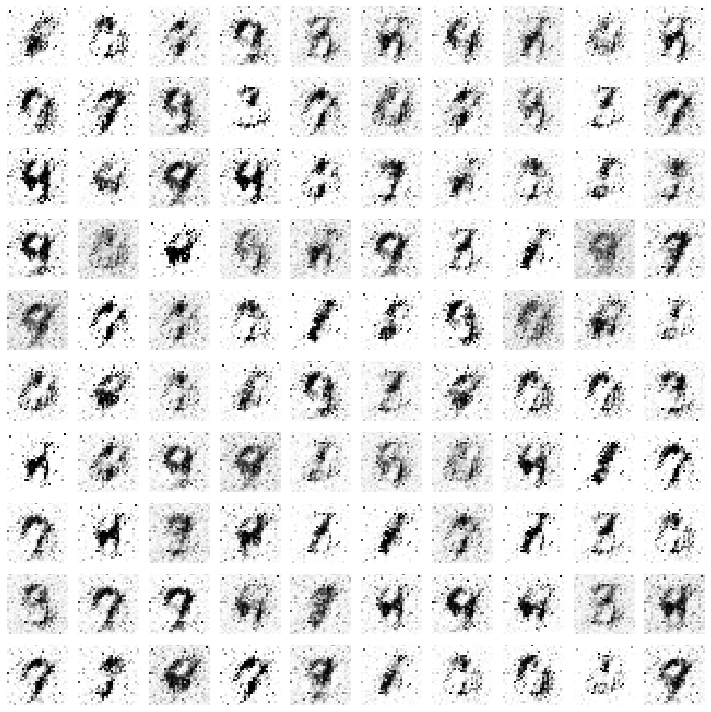

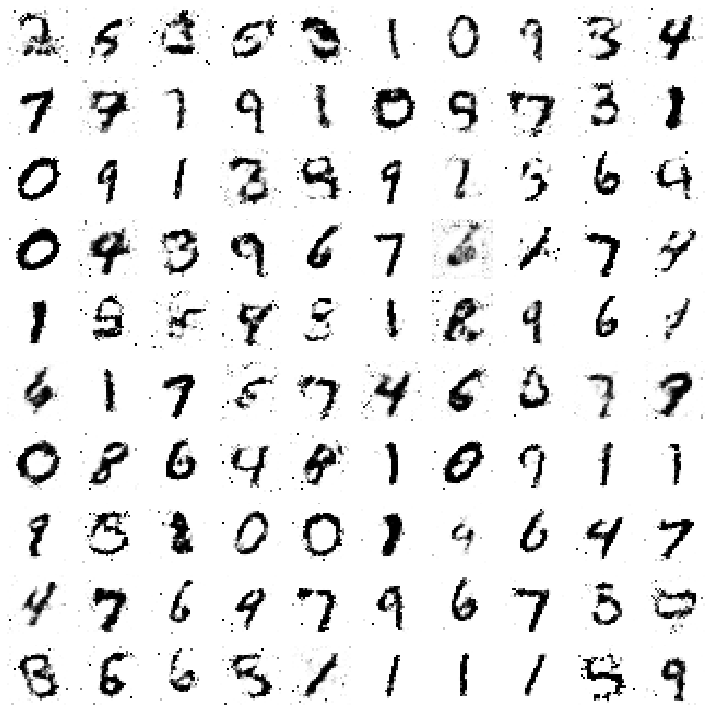

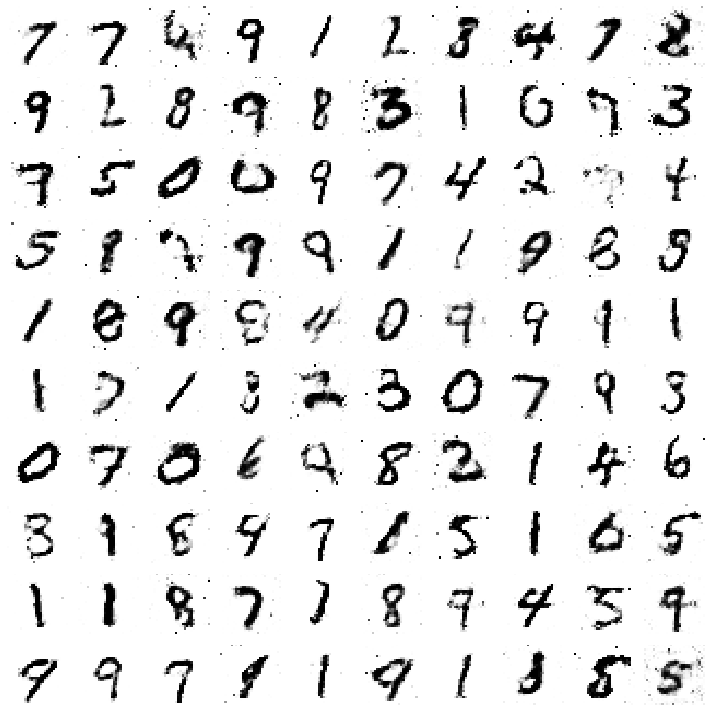

In [9]:
train(50, 128)